# **Overview**

**Challenge:** Helping an e-commerce business boost their revenue by customer and customer conversion rate.

**Goal:** Harness the power of ML and big data to create a e-commerce product recommender system.

**Data:** We utilized the Iowa Liquor Sales dataset from the Google Cloud Platform public database. There are no product ranking information so we utilized purchase history instead.

**Core ML tool:** Turicreate 

**Method:** Create 3 datasets (purchase volume, dummy and normalized purchase volume) and run them against 3 different ML models (popularity, collaborative filtering with cosine similarity and collaborative filtering with pearson similarity). This creates 9 different models where we will evaluate the RMSE and precision-recall and select the best. The best model is selected and we tuned it and observed if there are any improvements before making the final selection. 

**Output:**
1. Recommend 10 items based on matching similar users' preferences.
2. Recommend 10 items based on item selection.
3. Recommend 10 most popular items.

**Application:**
Each of the outputs are used as a different feature on our website.


---



# **First, housekeeping**

In [1]:
# Package installation
!pip install sklearn
!pip install turicreate

     |████████████████████████████████| 92.0MB 102kB/s 
     |████████████████████████████████| 327kB 40.9MB/s 
     |████████████████████████████████| 3.4MB 40.7MB/s 
     |████████████████████████████████| 86.4MB 86kB/s 
     |████████████████████████████████| 3.8MB 38.3MB/s 
     |████████████████████████████████| 450kB 29.5MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=8632f7ddc0cfa226963b523024cebb5b1e14f3a5d267f7062b7afd09ee5a569c
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320848 sha256=521bbe3e652485469b3980255615469a698371f50f176140c6c308a526a2310c
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=b

In [2]:
# Import dependencies

# For data manipulation and EDA
import numpy as np
import pandas as pd
import time

# For data visualisation
import matplotlib.pyplot as plt

# For splitting data into train and test sets
from sklearn.model_selection import train_test_split

# For machine learning modelling, model evaluation and selection
import turicreate as tc
import turicreate.aggregate as agg

# **Input Data**

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


We have queried the iowa liquor database from bigquery and inserted it into a database within our google project id. Query for reference below:

SELECT store_number, item_number, sum(volume_sold_liters) AS volume


FROM `bigquery-public-data.iowa_liquor_sales.sales`

WHERE data > date'2020-01-01' 

GROUP BY store_number, item_number

Query from own table stored in personal database

In [4]:
project_id = 'cosmic-antenna-281600'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
df = client.query('''SELECT *
  FROM `cosmic-antenna-281600.iowa_2020.iowa_liquor_2020`''').to_dataframe()

print(df.shape)
df.head()

(446139, 3)


,store_number,item_number,volume
0,4829,27066,360.00
1,4311,43031,1.35
2,2627,43040,26.25
3,2500,27175,60.00
4,5054,5037,5.00


Import drive so we can save the model later

In [5]:
# Import drive first before exporting as csv file - !need to change to read from Git/BigQuery!
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Exploratory Data Analysis**

In [6]:
sf = tc.SFrame(df)
sf.plot()

Materializing SFrame

**Total number of records:** 446,139

**Number of unique users:** 1,841

**Number of unique items:** 3,846

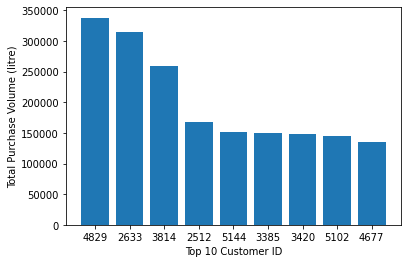

In [9]:
# Top customers by purchase volume
purchaser_by_vol = df.groupby('store_number').sum()
purchaser_by_vol = purchaser_by_vol.reset_index().sort_values(by='volume', ascending=False)

fig, ax = plt.subplots()
plt.bar(purchaser_by_vol.store_number[0:9], purchaser_by_vol.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Volume (litre)')
plt.xlabel('Top 10 Customer ID')
plt.show()

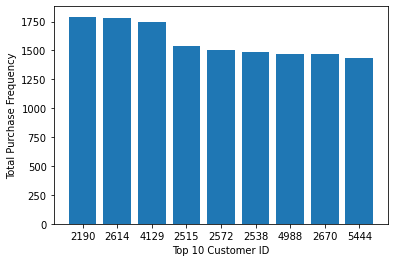

In [10]:
# Top customers by purchase frequency
purchaser_by_freq = df.groupby('store_number').count()
purchaser_by_freq = purchaser_by_freq.reset_index().sort_values(by='volume', ascending=False)
purchaser_by_freq = purchaser_by_freq[['store_number', 'volume']]

fig, ax = plt.subplots()
plt.bar(purchaser_by_freq.store_number[0:9], purchaser_by_freq.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Frequency')
plt.xlabel('Top 10 Customer ID')
plt.show()

In [151]:
# Highest purchase volume items 
item_by_vol = df.groupby('item_number').sum()
item_by_vol = item_by_vol.reset_index().sort_values(by='volume', ascending=False)
print(item_by_vol.mean())

fig, ax = plt.subplots()
plt.bar(item_by_vol.item_number[0:9], item_by_vol.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Volume (litre)')
plt.xlabel('Top 10 Stock Code')
plt.show()

KeyError: ignored

In [152]:
# Most commonly purchased items
item_by_freq = df.groupby('item_number').count()
item_by_freq = item_by_freq.reset_index().sort_values(by='volume', ascending=False)
item_by_freq = item_by_freq[['item_number', 'volume']]

fig, ax = plt.subplots()
plt.bar(item_by_freq.item_number[0:9], item_by_freq.volume[0:9], color='#dda146')
plt.ylabel('Total Purchase Frequency')
plt.xlabel('Top 10 Stock Code')
plt.show()

KeyError: ignored

# **Data Preparation**

In [13]:
# Get rename data for product/customer matrix
df.rename(columns={'store_number': 'CustomerID', \
                   'item_number': 'StockCode', \
                   'volume': 'Quantity'}, inplace=True)
data = df
print(data.shape)
data.head()

(446139, 3)


,CustomerID,StockCode,Quantity
0,4829,27066,360.00
1,4311,43031,1.35
2,2627,43040,26.25
3,2500,27175,60.00
4,5054,5037,5.00


**Create Data with User, Product and Purchase Count**

In [14]:
# Group by to get purchase quantity by customer ID and stock code
data = data.groupby(['CustomerID','StockCode']) \
    .agg({'Quantity':'sum'}) \
    .reset_index().sort_values(by=['Quantity'], ascending=False)
print(data.shape)
data.head()

(446139, 3)


,CustomerID,StockCode,Quantity
160410,3814,936600,79852.5
255205,4677,936600,41580.0
160413,3814,962094,31185.0
387312,5666,936600,28350.0
267831,4829,38177,26280.0


In [15]:
# Check to ensure no negative purchase order quantity
data[data['Quantity']<0]

,CustomerID,StockCode,Quantity


In [19]:
# Check for null values
data.isnull().sum()

CustomerID    0
StockCode     0
Quantity      0
dtype: int64

In [20]:
# Check data types for current dataframe. CustomerID must be string
data.dtypes

CustomerID     object
StockCode      object
Quantity      float64
dtype: object

**Create Dummy Dataset**

A dummy set is created where by, we assign the value 1 where a user made a purchase. In the event where a user did not make a purchase, the value is 0.

Rationale for a dummy set is so we can have a dataset that is not impacted by purchase volume and/or frequency.

In [21]:
# Define function to create dummy dataset
def create_data_dummy(data):
    data_dummy = data.copy()
    dummy_matrix = pd.pivot_table(data_dummy, values='Quantity', index='CustomerID', columns='StockCode')
    dummy = dummy_matrix.reset_index()
    dummy.index.names = ['purchase_dummy']
    data_dummy = pd.melt(dummy, id_vars=['CustomerID'], value_name='purchase_dummy')
    # Replace any purchase value as 1
    data_dummy.loc[data_dummy['purchase_dummy'] > 0, 'purchase_dummy'] = 1
    # Replace any null value as 0
    data_dummy['purchase_dummy'].fillna(0, inplace=True)
    return data_dummy

In [22]:
# Execute function
data_dummy = create_data_dummy(data)
print(data_dummy.shape)
data_dummy.head()

(7080486, 3)


,CustomerID,StockCode,purchase_dummy
0,2106,100015,0.0
1,2113,100015,0.0
2,2130,100015,0.0
3,2178,100015,0.0
4,2190,100015,0.0


**Normalize Item Values Across Users**

Purchase volume is normalised for each product interaction by calculating an interaction score for each customer as follows:

interactionScore = (interactionScore-product.minScore)/(product.maxScore-product.minScore)

This follows the feature scaling method.

In [23]:
# Define function to normalize item values across users
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='Quantity', index='CustomerID', columns='StockCode')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['CustomerID'], value_name='scaled_purchase_freq').dropna()

In [24]:
# Execute function
norm_data = normalize_data(data)
print(norm_data.shape)
norm_data.head()

(443400, 3)


,CustomerID,StockCode,scaled_purchase_freq
18,2502,100015,0.482759
20,2506,100015,0.137931
27,2515,100015,0.482759
35,2528,100015,0.586207
39,2536,100015,0.482759


# **Split Train and Test Datasets**

We use SK learn to split our 3 datasets into train and test sets at a ratio of 80:20 

In [25]:
# Declare function to split train and test data
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [26]:
# Split normalised scaled frequency data
train_data_norm, test_data_norm = split_data(norm_data)

In [27]:
# Split dummy data
train_data_dummy, test_data_dummy = split_data(data_dummy)

In [28]:
# Split purchase count data
train_data, test_data = split_data(data)

# **Define Models Using Turicreate Library**

Using Turicreate, we create 3 ML models for our datasets. 


1.   Popularity model
2.   Collaborative filtering with cosine similarity
3.   Collaborative filtering with pearson similarity



In [29]:
# Define variables for field names
user_id = 'CustomerID'
item_id = 'StockCode'
users_to_recommend = list(data['CustomerID'])
test_items = tc.SArray(sf['item_number'][10:12])
n_rec = 10 # number of items to recommend
n_display = 10 # to display the first few rows in an output dataset

In [30]:
# Declare function for all models
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)

    return model

# **Popularity Model**

Popularity model recommends the most popular items across all users. This simple model will be used as a baseline comparison and also will be used as a feature on our website (Best selling items recommendation).

**Model based on Purchase Count**

In [31]:
# Using Purchase Count
name = 'popularity'
target = 'Quantity'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3711 items.

Data prepared in: 0.492947s

356911 observations to process; with 3711 unique items.

recommendations finished on 1000/446139 queries. users per second: 19262.6

recommendations finished on 2000/446139 queries. users per second: 16479.2

recommendations finished on 3000/446139 queries. users per second: 15613.5

recommendations finished on 4000/446139 queries. users per second: 15684.4

recommendations finished on 5000/446139 queries. users per second: 15388.3

recommendations finished on 6000/446139 queries. users per second: 14813.5

recommendations finished on 7000/446139 queries. users per second: 14723.8

recommendations finished on 8000/446139 queries. users per second: 14764.2

recommendations finished on 9000/446139 queries. users per second: 15012.4

recommendations finished on 10000/446139 queries. users per second: 15113.3

recommendations finished on 11000/446139 queries. users per second: 15176.5

recommendations finished on 12000/446139 queries. users per second: 15240.1

recommendations finished on 13000/446139 queries. users per second: 15330.2

recommendations finished on 14000/446139 queries. users per second: 15240.4

recommendations finished on 15000/446139 queries. users per second: 15268.1

recommendations finished on 16000/446139 queries. users per second: 15324.6

recommendations finished on 17000/446139 queries. users per second: 15332.5

recommendations finished on 18000/446139 queries. users per second: 15293.1

recommendations finished on 19000/446139 queries. users per second: 15285.2

recommendations finished on 20000/446139 queries. users per second: 15220.6

recommendations finished on 21000/446139 queries. users per second: 15281.2

recommendations finished on 22000/446139 queries. users per second: 15296.2

recommendations finished on 23000/446139 queries. users per second: 15357.3

recommendations finished on 24000/446139 queries. users per second: 15353.9

recommendations finished on 25000/446139 queries. users per second: 15368.6

recommendations finished on 26000/446139 queries. users per second: 15379.7

recommendations finished on 27000/446139 queries. users per second: 15393.7

recommendations finished on 28000/446139 queries. users per second: 15469.4

recommendations finished on 29000/446139 queries. users per second: 15408.1

recommendations finished on 30000/446139 queries. users per second: 15253.9

recommendations finished on 31000/446139 queries. users per second: 15254.6

recommendations finished on 32000/446139 queries. users per second: 15308.1

recommendations finished on 33000/446139 queries. users per second: 15360.4

recommendations finished on 34000/446139 queries. users per second: 15357.8

recommendations finished on 35000/446139 queries. users per second: 15304.7

recommendations finished on 36000/446139 queries. users per second: 15279.6

recommendations finished on 37000/446139 queries. users per second: 15301.5

recommendations finished on 38000/446139 queries. users per second: 15342.8

recommendations finished on 39000/446139 queries. users per second: 15354.2

recommendations finished on 40000/446139 queries. users per second: 15353.7

recommendations finished on 41000/446139 queries. users per second: 15308.3

recommendations finished on 42000/446139 queries. users per second: 15161.7

recommendations finished on 43000/446139 queries. users per second: 15180.7

recommendations finished on 44000/446139 queries. users per second: 15224.7

recommendations finished on 45000/446139 queries. users per second: 15211.4

recommendations finished on 46000/446139 queries. users per second: 15192.9

recommendations finished on 47000/446139 queries. users per second: 15217.7

recommendations finished on 48000/446139 queries. users per second: 15240.3

recommendations finished on 49000/446139 queries. users per second: 15295.2

recommendations finished on 50000/446139 queries. users per second: 15312.8

recommendations finished on 51000/446139 queries. users per second: 15335.6

recommendations finished on 52000/446139 queries. users per second: 15306.9

recommendations finished on 53000/446139 queries. users per second: 15288.4

recommendations finished on 54000/446139 queries. users per second: 15241.4

recommendations finished on 55000/446139 queries. users per second: 15128.1

recommendations finished on 56000/446139 queries. users per second: 15030.5

recommendations finished on 57000/446139 queries. users per second: 14935.9

recommendations finished on 58000/446139 queries. users per second: 14889.9

recommendations finished on 59000/446139 queries. users per second: 14871.5

recommendations finished on 60000/446139 queries. users per second: 14797.8

recommendations finished on 61000/446139 queries. users per second: 14716.9

recommendations finished on 62000/446139 queries. users per second: 14680.4

recommendations finished on 63000/446139 queries. users per second: 14639.1

recommendations finished on 64000/446139 queries. users per second: 14583.7

recommendations finished on 65000/446139 queries. users per second: 14567.6

recommendations finished on 66000/446139 queries. users per second: 14469.5

recommendations finished on 67000/446139 queries. users per second: 14424.4

recommendations finished on 68000/446139 queries. users per second: 14374.6

recommendations finished on 69000/446139 queries. users per second: 14339

recommendations finished on 70000/446139 queries. users per second: 14308.1

recommendations finished on 71000/446139 queries. users per second: 14296.2

recommendations finished on 72000/446139 queries. users per second: 14268.9

recommendations finished on 73000/446139 queries. users per second: 14234.6

recommendations finished on 74000/446139 queries. users per second: 14204

recommendations finished on 75000/446139 queries. users per second: 14186

recommendations finished on 76000/446139 queries. users per second: 14132.5

recommendations finished on 77000/446139 queries. users per second: 14091.9

recommendations finished on 78000/446139 queries. users per second: 14053.3

recommendations finished on 79000/446139 queries. users per second: 14029.2

recommendations finished on 80000/446139 queries. users per second: 14000

recommendations finished on 81000/446139 queries. users per second: 13970.6

recommendations finished on 82000/446139 queries. users per second: 13937.7

recommendations finished on 83000/446139 queries. users per second: 13905.2

recommendations finished on 84000/446139 queries. users per second: 13876.7

recommendations finished on 85000/446139 queries. users per second: 13873.1

recommendations finished on 86000/446139 queries. users per second: 13859.8

recommendations finished on 87000/446139 queries. users per second: 13829.4

recommendations finished on 88000/446139 queries. users per second: 13816.9

recommendations finished on 89000/446139 queries. users per second: 13778.8

recommendations finished on 90000/446139 queries. users per second: 13755

recommendations finished on 91000/446139 queries. users per second: 13739.9

recommendations finished on 92000/446139 queries. users per second: 13711.4

recommendations finished on 93000/446139 queries. users per second: 13684.2

recommendations finished on 94000/446139 queries. users per second: 13642.4

recommendations finished on 95000/446139 queries. users per second: 13645.7

recommendations finished on 96000/446139 queries. users per second: 13633.3

recommendations finished on 97000/446139 queries. users per second: 13599.3

recommendations finished on 98000/446139 queries. users per second: 13589.1

recommendations finished on 99000/446139 queries. users per second: 13563.9

recommendations finished on 100000/446139 queries. users per second: 13546.2

recommendations finished on 101000/446139 queries. users per second: 13503.7

recommendations finished on 102000/446139 queries. users per second: 13483.7

recommendations finished on 103000/446139 queries. users per second: 13455.8

recommendations finished on 104000/446139 queries. users per second: 13436.4

recommendations finished on 105000/446139 queries. users per second: 13413.2

recommendations finished on 106000/446139 queries. users per second: 13396.1

recommendations finished on 107000/446139 queries. users per second: 13386.2

recommendations finished on 108000/446139 queries. users per second: 13357.9

recommendations finished on 109000/446139 queries. users per second: 13335.3

recommendations finished on 110000/446139 queries. users per second: 13335.5

recommendations finished on 111000/446139 queries. users per second: 13332.7

recommendations finished on 112000/446139 queries. users per second: 13333.8

recommendations finished on 113000/446139 queries. users per second: 13337.6

recommendations finished on 114000/446139 queries. users per second: 13341.8

recommendations finished on 115000/446139 queries. users per second: 13343.9

recommendations finished on 116000/446139 queries. users per second: 13349.5

recommendations finished on 117000/446139 queries. users per second: 13339.6

recommendations finished on 118000/446139 queries. users per second: 13327.4

recommendations finished on 119000/446139 queries. users per second: 13317

recommendations finished on 120000/446139 queries. users per second: 13282.6

recommendations finished on 121000/446139 queries. users per second: 13279.2

recommendations finished on 122000/446139 queries. users per second: 13284.9

recommendations finished on 123000/446139 queries. users per second: 13288.6

recommendations finished on 124000/446139 queries. users per second: 13290.4

recommendations finished on 125000/446139 queries. users per second: 13284.4

recommendations finished on 126000/446139 queries. users per second: 13271.7

recommendations finished on 127000/446139 queries. users per second: 13265.9

recommendations finished on 128000/446139 queries. users per second: 13271.1

recommendations finished on 129000/446139 queries. users per second: 13273.8

recommendations finished on 130000/446139 queries. users per second: 13271

recommendations finished on 131000/446139 queries. users per second: 13255.9

recommendations finished on 132000/446139 queries. users per second: 13233.1

recommendations finished on 133000/446139 queries. users per second: 13237

recommendations finished on 134000/446139 queries. users per second: 13239.6

recommendations finished on 135000/446139 queries. users per second: 13236.7

recommendations finished on 136000/446139 queries. users per second: 13234.3

recommendations finished on 137000/446139 queries. users per second: 13230.9

recommendations finished on 138000/446139 queries. users per second: 13221

recommendations finished on 139000/446139 queries. users per second: 13201

recommendations finished on 140000/446139 queries. users per second: 13192.8

recommendations finished on 141000/446139 queries. users per second: 13198

recommendations finished on 142000/446139 queries. users per second: 13216.4

recommendations finished on 143000/446139 queries. users per second: 13215.7

recommendations finished on 144000/446139 queries. users per second: 13241.9

recommendations finished on 145000/446139 queries. users per second: 13267.8

recommendations finished on 146000/446139 queries. users per second: 13267.1

recommendations finished on 147000/446139 queries. users per second: 13291.2

recommendations finished on 148000/446139 queries. users per second: 13308.7

recommendations finished on 149000/446139 queries. users per second: 13323.1

recommendations finished on 150000/446139 queries. users per second: 13321.6

recommendations finished on 151000/446139 queries. users per second: 13331.1

recommendations finished on 152000/446139 queries. users per second: 13344.5

recommendations finished on 153000/446139 queries. users per second: 13363.2

recommendations finished on 154000/446139 queries. users per second: 13380.2

recommendations finished on 155000/446139 queries. users per second: 13403.2

recommendations finished on 156000/446139 queries. users per second: 13424.3

recommendations finished on 157000/446139 queries. users per second: 13446.1

recommendations finished on 158000/446139 queries. users per second: 13465.7

recommendations finished on 159000/446139 queries. users per second: 13474.2

recommendations finished on 160000/446139 queries. users per second: 13454.4

recommendations finished on 161000/446139 queries. users per second: 13468.9

recommendations finished on 162000/446139 queries. users per second: 13486.2

recommendations finished on 163000/446139 queries. users per second: 13457

recommendations finished on 164000/446139 queries. users per second: 13467.7

recommendations finished on 165000/446139 queries. users per second: 13479.7

recommendations finished on 166000/446139 queries. users per second: 13476.4

recommendations finished on 167000/446139 queries. users per second: 13468.3

recommendations finished on 168000/446139 queries. users per second: 13453.5

recommendations finished on 169000/446139 queries. users per second: 13437.9

recommendations finished on 170000/446139 queries. users per second: 13443.1

recommendations finished on 171000/446139 queries. users per second: 13444.4

recommendations finished on 172000/446139 queries. users per second: 13444.1

recommendations finished on 173000/446139 queries. users per second: 13454.5

recommendations finished on 174000/446139 queries. users per second: 13453.4

recommendations finished on 175000/446139 queries. users per second: 13462.4

recommendations finished on 176000/446139 queries. users per second: 13467.4

recommendations finished on 177000/446139 queries. users per second: 13468.8

recommendations finished on 178000/446139 queries. users per second: 13476.7

recommendations finished on 179000/446139 queries. users per second: 13466.8

recommendations finished on 180000/446139 queries. users per second: 13458.9

recommendations finished on 181000/446139 queries. users per second: 13466.5

recommendations finished on 182000/446139 queries. users per second: 13462.3

recommendations finished on 183000/446139 queries. users per second: 13456.3

recommendations finished on 184000/446139 queries. users per second: 13449.9

recommendations finished on 185000/446139 queries. users per second: 13444.9

recommendations finished on 186000/446139 queries. users per second: 13445.6

recommendations finished on 187000/446139 queries. users per second: 13441.7

recommendations finished on 188000/446139 queries. users per second: 13440.8

recommendations finished on 189000/446139 queries. users per second: 13443.7

recommendations finished on 190000/446139 queries. users per second: 13413.3

recommendations finished on 191000/446139 queries. users per second: 13395.4

recommendations finished on 192000/446139 queries. users per second: 13385.8

recommendations finished on 193000/446139 queries. users per second: 13376.3

recommendations finished on 194000/446139 queries. users per second: 13381.6

recommendations finished on 195000/446139 queries. users per second: 13374.8

recommendations finished on 196000/446139 queries. users per second: 13373.8

recommendations finished on 197000/446139 queries. users per second: 13383.5

recommendations finished on 198000/446139 queries. users per second: 13386.2

recommendations finished on 199000/446139 queries. users per second: 13394

recommendations finished on 200000/446139 queries. users per second: 13401.6

recommendations finished on 201000/446139 queries. users per second: 13409.1

recommendations finished on 202000/446139 queries. users per second: 13408

recommendations finished on 203000/446139 queries. users per second: 13408.9

recommendations finished on 204000/446139 queries. users per second: 13408

recommendations finished on 205000/446139 queries. users per second: 13414.3

recommendations finished on 206000/446139 queries. users per second: 13413.4

recommendations finished on 207000/446139 queries. users per second: 13419.2

recommendations finished on 208000/446139 queries. users per second: 13428.6

recommendations finished on 209000/446139 queries. users per second: 13431.9

recommendations finished on 210000/446139 queries. users per second: 13430.4

recommendations finished on 211000/446139 queries. users per second: 13414.1

recommendations finished on 212000/446139 queries. users per second: 13419.3

recommendations finished on 213000/446139 queries. users per second: 13430.5

recommendations finished on 214000/446139 queries. users per second: 13432.2

recommendations finished on 215000/446139 queries. users per second: 13432.8

recommendations finished on 216000/446139 queries. users per second: 13432.1

recommendations finished on 217000/446139 queries. users per second: 13418.1

recommendations finished on 218000/446139 queries. users per second: 13418.8

recommendations finished on 219000/446139 queries. users per second: 13414.5

recommendations finished on 220000/446139 queries. users per second: 13408.4

recommendations finished on 221000/446139 queries. users per second: 13408.8

recommendations finished on 222000/446139 queries. users per second: 13408.3

recommendations finished on 223000/446139 queries. users per second: 13398.1

recommendations finished on 224000/446139 queries. users per second: 13397

recommendations finished on 225000/446139 queries. users per second: 13400.7

recommendations finished on 226000/446139 queries. users per second: 13403.6

recommendations finished on 227000/446139 queries. users per second: 13402.8

recommendations finished on 228000/446139 queries. users per second: 13410.3

recommendations finished on 229000/446139 queries. users per second: 13419.2

recommendations finished on 230000/446139 queries. users per second: 13423.6

recommendations finished on 231000/446139 queries. users per second: 13433.8

recommendations finished on 232000/446139 queries. users per second: 13442.8

recommendations finished on 233000/446139 queries. users per second: 13458.9

recommendations finished on 234000/446139 queries. users per second: 13471.3

recommendations finished on 235000/446139 queries. users per second: 13470.3

recommendations finished on 236000/446139 queries. users per second: 13475.3

recommendations finished on 237000/446139 queries. users per second: 13483.5

recommendations finished on 238000/446139 queries. users per second: 13486.6

recommendations finished on 239000/446139 queries. users per second: 13480.9

recommendations finished on 240000/446139 queries. users per second: 13480.1

recommendations finished on 241000/446139 queries. users per second: 13484.7

recommendations finished on 242000/446139 queries. users per second: 13486.6

recommendations finished on 243000/446139 queries. users per second: 13473.6

recommendations finished on 244000/446139 queries. users per second: 13468.9

recommendations finished on 245000/446139 queries. users per second: 13464.1

recommendations finished on 246000/446139 queries. users per second: 13463

recommendations finished on 247000/446139 queries. users per second: 13457.8

recommendations finished on 248000/446139 queries. users per second: 13455.6

recommendations finished on 249000/446139 queries. users per second: 13451.2

recommendations finished on 250000/446139 queries. users per second: 13446

recommendations finished on 251000/446139 queries. users per second: 13442.4

recommendations finished on 252000/446139 queries. users per second: 13432.9

recommendations finished on 253000/446139 queries. users per second: 13428.8

recommendations finished on 254000/446139 queries. users per second: 13429.3

recommendations finished on 255000/446139 queries. users per second: 13432.7

recommendations finished on 256000/446139 queries. users per second: 13431.9

recommendations finished on 257000/446139 queries. users per second: 13427.8

recommendations finished on 258000/446139 queries. users per second: 13419.9

recommendations finished on 259000/446139 queries. users per second: 13419.1

recommendations finished on 260000/446139 queries. users per second: 13414.5

recommendations finished on 261000/446139 queries. users per second: 13409

recommendations finished on 262000/446139 queries. users per second: 13408.8

recommendations finished on 263000/446139 queries. users per second: 13408.4

recommendations finished on 264000/446139 queries. users per second: 13408.6

recommendations finished on 265000/446139 queries. users per second: 13410.3

recommendations finished on 266000/446139 queries. users per second: 13408.2

recommendations finished on 267000/446139 queries. users per second: 13397.2

recommendations finished on 268000/446139 queries. users per second: 13398.9

recommendations finished on 269000/446139 queries. users per second: 13400

recommendations finished on 270000/446139 queries. users per second: 13399.1

recommendations finished on 271000/446139 queries. users per second: 13407.1

recommendations finished on 272000/446139 queries. users per second: 13415.3

recommendations finished on 273000/446139 queries. users per second: 13421.9

recommendations finished on 274000/446139 queries. users per second: 13424.7

recommendations finished on 275000/446139 queries. users per second: 13431.1

recommendations finished on 276000/446139 queries. users per second: 13438.9

recommendations finished on 277000/446139 queries. users per second: 13447.1

recommendations finished on 278000/446139 queries. users per second: 13451.3

recommendations finished on 279000/446139 queries. users per second: 13458.8

recommendations finished on 280000/446139 queries. users per second: 13464.9

recommendations finished on 281000/446139 queries. users per second: 13467.7

recommendations finished on 282000/446139 queries. users per second: 13470.5

recommendations finished on 283000/446139 queries. users per second: 13471.3

recommendations finished on 284000/446139 queries. users per second: 13471.8

recommendations finished on 285000/446139 queries. users per second: 13478.3

recommendations finished on 286000/446139 queries. users per second: 13487.3

recommendations finished on 287000/446139 queries. users per second: 13488

recommendations finished on 288000/446139 queries. users per second: 13495.5

recommendations finished on 289000/446139 queries. users per second: 13497

recommendations finished on 290000/446139 queries. users per second: 13496.6

recommendations finished on 291000/446139 queries. users per second: 13497.9

recommendations finished on 292000/446139 queries. users per second: 13495.7

recommendations finished on 293000/446139 queries. users per second: 13491.3

recommendations finished on 294000/446139 queries. users per second: 13484.5

recommendations finished on 295000/446139 queries. users per second: 13488.1

recommendations finished on 296000/446139 queries. users per second: 13487.6

recommendations finished on 297000/446139 queries. users per second: 13493.3

recommendations finished on 298000/446139 queries. users per second: 13489.7

recommendations finished on 299000/446139 queries. users per second: 13481.2

recommendations finished on 300000/446139 queries. users per second: 13472.9

recommendations finished on 301000/446139 queries. users per second: 13467.8

recommendations finished on 302000/446139 queries. users per second: 13462.3

recommendations finished on 303000/446139 queries. users per second: 13458.7

recommendations finished on 304000/446139 queries. users per second: 13453.8

recommendations finished on 305000/446139 queries. users per second: 13449.8

recommendations finished on 306000/446139 queries. users per second: 13444.5

recommendations finished on 307000/446139 queries. users per second: 13446.8

recommendations finished on 308000/446139 queries. users per second: 13443.7

recommendations finished on 309000/446139 queries. users per second: 13439.6

recommendations finished on 310000/446139 queries. users per second: 13434.8

recommendations finished on 311000/446139 queries. users per second: 13429.2

recommendations finished on 312000/446139 queries. users per second: 13421.4

recommendations finished on 313000/446139 queries. users per second: 13417.6

recommendations finished on 314000/446139 queries. users per second: 13411.3

recommendations finished on 315000/446139 queries. users per second: 13406.1

recommendations finished on 316000/446139 queries. users per second: 13400.9

recommendations finished on 317000/446139 queries. users per second: 13392.4

recommendations finished on 318000/446139 queries. users per second: 13381.6

recommendations finished on 319000/446139 queries. users per second: 13375.9

recommendations finished on 320000/446139 queries. users per second: 13375.3

recommendations finished on 321000/446139 queries. users per second: 13379.9

recommendations finished on 322000/446139 queries. users per second: 13385.4

recommendations finished on 323000/446139 queries. users per second: 13385.3

recommendations finished on 324000/446139 queries. users per second: 13383

recommendations finished on 325000/446139 queries. users per second: 13379.5

recommendations finished on 326000/446139 queries. users per second: 13380.7

recommendations finished on 327000/446139 queries. users per second: 13383.9

recommendations finished on 328000/446139 queries. users per second: 13383.1

recommendations finished on 329000/446139 queries. users per second: 13385.6

recommendations finished on 330000/446139 queries. users per second: 13388.7

recommendations finished on 331000/446139 queries. users per second: 13391.9

recommendations finished on 332000/446139 queries. users per second: 13390.8

recommendations finished on 333000/446139 queries. users per second: 13398.3

recommendations finished on 334000/446139 queries. users per second: 13407.5

recommendations finished on 335000/446139 queries. users per second: 13412.5

recommendations finished on 336000/446139 queries. users per second: 13411.4

recommendations finished on 337000/446139 queries. users per second: 13419.3

recommendations finished on 338000/446139 queries. users per second: 13422.6

recommendations finished on 339000/446139 queries. users per second: 13429

recommendations finished on 340000/446139 queries. users per second: 13436

recommendations finished on 341000/446139 queries. users per second: 13445.2

recommendations finished on 342000/446139 queries. users per second: 13456.1

recommendations finished on 343000/446139 queries. users per second: 13463.9

recommendations finished on 344000/446139 queries. users per second: 13474.2

recommendations finished on 345000/446139 queries. users per second: 13476

recommendations finished on 346000/446139 queries. users per second: 13485.1

recommendations finished on 347000/446139 queries. users per second: 13488.5

recommendations finished on 348000/446139 queries. users per second: 13486.9

recommendations finished on 349000/446139 queries. users per second: 13473.5

recommendations finished on 350000/446139 queries. users per second: 13470.3

recommendations finished on 351000/446139 queries. users per second: 13460.3

recommendations finished on 352000/446139 queries. users per second: 13454.9

recommendations finished on 353000/446139 queries. users per second: 13458

recommendations finished on 354000/446139 queries. users per second: 13464.5

recommendations finished on 355000/446139 queries. users per second: 13470.3

recommendations finished on 356000/446139 queries. users per second: 13476.3

recommendations finished on 357000/446139 queries. users per second: 13481.3

recommendations finished on 358000/446139 queries. users per second: 13488.9

recommendations finished on 359000/446139 queries. users per second: 13494.3

recommendations finished on 360000/446139 queries. users per second: 13500.6

recommendations finished on 361000/446139 queries. users per second: 13505.9

recommendations finished on 362000/446139 queries. users per second: 13509.8

recommendations finished on 363000/446139 queries. users per second: 13509.1

recommendations finished on 364000/446139 queries. users per second: 13512.1

recommendations finished on 365000/446139 queries. users per second: 13510.9

recommendations finished on 366000/446139 queries. users per second: 13506.3

recommendations finished on 367000/446139 queries. users per second: 13502.3

recommendations finished on 368000/446139 queries. users per second: 13498

recommendations finished on 369000/446139 queries. users per second: 13489.6

recommendations finished on 370000/446139 queries. users per second: 13483.4

recommendations finished on 371000/446139 queries. users per second: 13480.4

recommendations finished on 372000/446139 queries. users per second: 13472.1

recommendations finished on 373000/446139 queries. users per second: 13468.1

recommendations finished on 374000/446139 queries. users per second: 13459.1

recommendations finished on 375000/446139 queries. users per second: 13451.8

recommendations finished on 376000/446139 queries. users per second: 13448.6

recommendations finished on 377000/446139 queries. users per second: 13446.3

recommendations finished on 378000/446139 queries. users per second: 13440

recommendations finished on 379000/446139 queries. users per second: 13437.3

recommendations finished on 380000/446139 queries. users per second: 13431.7

recommendations finished on 381000/446139 queries. users per second: 13425.4

recommendations finished on 382000/446139 queries. users per second: 13422.4

recommendations finished on 383000/446139 queries. users per second: 13418.8

recommendations finished on 384000/446139 queries. users per second: 13417.7

recommendations finished on 385000/446139 queries. users per second: 13414.3

recommendations finished on 386000/446139 queries. users per second: 13413.5

recommendations finished on 387000/446139 queries. users per second: 13406

recommendations finished on 388000/446139 queries. users per second: 13404

recommendations finished on 389000/446139 queries. users per second: 13396.4

recommendations finished on 390000/446139 queries. users per second: 13396.4

recommendations finished on 391000/446139 queries. users per second: 13393.9

recommendations finished on 392000/446139 queries. users per second: 13392.7

recommendations finished on 393000/446139 queries. users per second: 13395.5

recommendations finished on 394000/446139 queries. users per second: 13395

recommendations finished on 395000/446139 queries. users per second: 13392.7

recommendations finished on 396000/446139 queries. users per second: 13388.2

recommendations finished on 397000/446139 queries. users per second: 13384.7

recommendations finished on 398000/446139 queries. users per second: 13380.7

recommendations finished on 399000/446139 queries. users per second: 13383.1

recommendations finished on 400000/446139 queries. users per second: 13376.6

recommendations finished on 401000/446139 queries. users per second: 13370.2

recommendations finished on 402000/446139 queries. users per second: 13368.8

recommendations finished on 403000/446139 queries. users per second: 13368.4

recommendations finished on 404000/446139 queries. users per second: 13368.4

recommendations finished on 405000/446139 queries. users per second: 13368

recommendations finished on 406000/446139 queries. users per second: 13365.6

recommendations finished on 407000/446139 queries. users per second: 13365

recommendations finished on 408000/446139 queries. users per second: 13366.8

recommendations finished on 409000/446139 queries. users per second: 13364.7

recommendations finished on 410000/446139 queries. users per second: 13366.9

recommendations finished on 411000/446139 queries. users per second: 13370

recommendations finished on 412000/446139 queries. users per second: 13370.4

recommendations finished on 413000/446139 queries. users per second: 13369.6

recommendations finished on 414000/446139 queries. users per second: 13371.6

recommendations finished on 415000/446139 queries. users per second: 13362

recommendations finished on 416000/446139 queries. users per second: 13351

recommendations finished on 417000/446139 queries. users per second: 13344.8

recommendations finished on 418000/446139 queries. users per second: 13330

recommendations finished on 419000/446139 queries. users per second: 13321.5

recommendations finished on 420000/446139 queries. users per second: 13317.3

recommendations finished on 421000/446139 queries. users per second: 13313

recommendations finished on 422000/446139 queries. users per second: 13306.6

recommendations finished on 423000/446139 queries. users per second: 13300.1

recommendations finished on 424000/446139 queries. users per second: 13299.7

recommendations finished on 425000/446139 queries. users per second: 13298.6

recommendations finished on 426000/446139 queries. users per second: 13300.3

recommendations finished on 427000/446139 queries. users per second: 13304.3

recommendations finished on 428000/446139 queries. users per second: 13306.7

recommendations finished on 429000/446139 queries. users per second: 13312.5

recommendations finished on 430000/446139 queries. users per second: 13310.4

recommendations finished on 431000/446139 queries. users per second: 13310.2

recommendations finished on 432000/446139 queries. users per second: 13312.7

recommendations finished on 433000/446139 queries. users per second: 13302.8

recommendations finished on 434000/446139 queries. users per second: 13302.8

recommendations finished on 435000/446139 queries. users per second: 13303.3

recommendations finished on 436000/446139 queries. users per second: 13297.4

recommendations finished on 437000/446139 queries. users per second: 13290.2

recommendations finished on 438000/446139 queries. users per second: 13276.2

recommendations finished on 439000/446139 queries. users per second: 13268.2

recommendations finished on 440000/446139 queries. users per second: 13264.6

recommendations finished on 441000/446139 queries. users per second: 13260.6

recommendations finished on 442000/446139 queries. users per second: 13259.3

recommendations finished on 443000/446139 queries. users per second: 13262.6

recommendations finished on 444000/446139 queries. users per second: 13270.7

recommendations finished on 445000/446139 queries. users per second: 13277.1

recommendations finished on 446000/446139 queries. users per second: 13286.8

+------------+-----------+-------------------+------+
| CustomerID | StockCode |       score       | rank |
+------------+-----------+-------------------+------+
|    3814    |   936859  | 9458.166666666666 |  1   |
|    3814    |   962476  |       3528.0      |  2   |
|    3814    |   946574  |       2520.0      |  3   |
|    3814    |   988063  |       1701.0      |  4   |
|    3814    |   77487   |       1219.8      |  5   |
|    3814    |   926875  |       1134.0      |  6   |
|    3814    |   988547  |       1092.0      |  7   |
|    3814    |   926442  |       900.0       |  8   |
|    3814    |   900138  |       896.0       |  9   |
|    3814    |   926684  |       814.5       |  10  |
+------------+-----------+-------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [32]:
# Using purchase dummy
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 7.94108s

5664388 observations to process; with 3846 unique items.

recommendations finished on 1000/446139 queries. users per second: 5505.58

recommendations finished on 2000/446139 queries. users per second: 4757.8

recommendations finished on 3000/446139 queries. users per second: 4706.64

recommendations finished on 4000/446139 queries. users per second: 4593.94

recommendations finished on 5000/446139 queries. users per second: 4687.11

recommendations finished on 6000/446139 queries. users per second: 4898.84

recommendations finished on 7000/446139 queries. users per second: 4954.16

recommendations finished on 8000/446139 queries. users per second: 4961.61

recommendations finished on 9000/446139 queries. users per second: 5043.16

recommendations finished on 10000/446139 queries. users per second: 5027.04

recommendations finished on 11000/446139 queries. users per second: 5071.16

recommendations finished on 12000/446139 queries. users per second: 5134.31

recommendations finished on 13000/446139 queries. users per second: 5175.87

recommendations finished on 14000/446139 queries. users per second: 5124.46

recommendations finished on 15000/446139 queries. users per second: 5151.82

recommendations finished on 16000/446139 queries. users per second: 5059.98

recommendations finished on 17000/446139 queries. users per second: 5014.19

recommendations finished on 18000/446139 queries. users per second: 4964.08

recommendations finished on 19000/446139 queries. users per second: 4956.06

recommendations finished on 20000/446139 queries. users per second: 4909.89

recommendations finished on 21000/446139 queries. users per second: 4871.2

recommendations finished on 22000/446139 queries. users per second: 4866.96

recommendations finished on 23000/446139 queries. users per second: 4889.86

recommendations finished on 24000/446139 queries. users per second: 4870.16

recommendations finished on 25000/446139 queries. users per second: 4901.7

recommendations finished on 26000/446139 queries. users per second: 4930.33

recommendations finished on 27000/446139 queries. users per second: 4969.09

recommendations finished on 28000/446139 queries. users per second: 4991.07

recommendations finished on 29000/446139 queries. users per second: 5014.78

recommendations finished on 30000/446139 queries. users per second: 5002.14

recommendations finished on 31000/446139 queries. users per second: 4989.63

recommendations finished on 32000/446139 queries. users per second: 5008.88

recommendations finished on 33000/446139 queries. users per second: 5034.57

recommendations finished on 34000/446139 queries. users per second: 5072.98

recommendations finished on 35000/446139 queries. users per second: 5085.05

recommendations finished on 36000/446139 queries. users per second: 5097.53

recommendations finished on 37000/446139 queries. users per second: 5127.71

recommendations finished on 38000/446139 queries. users per second: 5107.56

recommendations finished on 39000/446139 queries. users per second: 5136.25

recommendations finished on 40000/446139 queries. users per second: 5151.78

recommendations finished on 41000/446139 queries. users per second: 5172.97

recommendations finished on 42000/446139 queries. users per second: 5198.2

recommendations finished on 43000/446139 queries. users per second: 5156.24

recommendations finished on 44000/446139 queries. users per second: 5157.43

recommendations finished on 45000/446139 queries. users per second: 5131.52

recommendations finished on 46000/446139 queries. users per second: 5111.12

recommendations finished on 47000/446139 queries. users per second: 5075.36

recommendations finished on 48000/446139 queries. users per second: 5041.98

recommendations finished on 49000/446139 queries. users per second: 5012.73

recommendations finished on 50000/446139 queries. users per second: 4975.74

recommendations finished on 51000/446139 queries. users per second: 4901.71

recommendations finished on 52000/446139 queries. users per second: 4839.18

recommendations finished on 53000/446139 queries. users per second: 4782.9

recommendations finished on 54000/446139 queries. users per second: 4737.23

recommendations finished on 55000/446139 queries. users per second: 4685.72

recommendations finished on 56000/446139 queries. users per second: 4639.55

recommendations finished on 57000/446139 queries. users per second: 4582.42

recommendations finished on 58000/446139 queries. users per second: 4530.16

recommendations finished on 59000/446139 queries. users per second: 4483.18

recommendations finished on 60000/446139 queries. users per second: 4433.89

recommendations finished on 61000/446139 queries. users per second: 4402.38

recommendations finished on 62000/446139 queries. users per second: 4372.84

recommendations finished on 63000/446139 queries. users per second: 4339.69

recommendations finished on 64000/446139 queries. users per second: 4309.16

recommendations finished on 65000/446139 queries. users per second: 4282.59

recommendations finished on 66000/446139 queries. users per second: 4253.98

recommendations finished on 67000/446139 queries. users per second: 4218.62

recommendations finished on 68000/446139 queries. users per second: 4188.04

recommendations finished on 69000/446139 queries. users per second: 4165.77

recommendations finished on 70000/446139 queries. users per second: 4144.12

recommendations finished on 71000/446139 queries. users per second: 4116.6

recommendations finished on 72000/446139 queries. users per second: 4086.21

recommendations finished on 73000/446139 queries. users per second: 4063.51

recommendations finished on 74000/446139 queries. users per second: 4042.26

recommendations finished on 75000/446139 queries. users per second: 4021.12

recommendations finished on 76000/446139 queries. users per second: 4001.33

recommendations finished on 77000/446139 queries. users per second: 3980.27

recommendations finished on 78000/446139 queries. users per second: 3957.6

recommendations finished on 79000/446139 queries. users per second: 3939.05

recommendations finished on 80000/446139 queries. users per second: 3918.82

recommendations finished on 81000/446139 queries. users per second: 3901.02

recommendations finished on 82000/446139 queries. users per second: 3885.63

recommendations finished on 83000/446139 queries. users per second: 3873.32

recommendations finished on 84000/446139 queries. users per second: 3858.78

recommendations finished on 85000/446139 queries. users per second: 3841.22

recommendations finished on 86000/446139 queries. users per second: 3827.08

recommendations finished on 87000/446139 queries. users per second: 3812.34

recommendations finished on 88000/446139 queries. users per second: 3802.93

recommendations finished on 89000/446139 queries. users per second: 3791.51

recommendations finished on 90000/446139 queries. users per second: 3781.82

recommendations finished on 91000/446139 queries. users per second: 3770.1

recommendations finished on 92000/446139 queries. users per second: 3757.44

recommendations finished on 93000/446139 queries. users per second: 3743.99

recommendations finished on 94000/446139 queries. users per second: 3730.48

recommendations finished on 95000/446139 queries. users per second: 3717.58

recommendations finished on 96000/446139 queries. users per second: 3706.07

recommendations finished on 97000/446139 queries. users per second: 3697.3

recommendations finished on 98000/446139 queries. users per second: 3687.49

recommendations finished on 99000/446139 queries. users per second: 3677.29

recommendations finished on 100000/446139 queries. users per second: 3669.99

recommendations finished on 101000/446139 queries. users per second: 3665.74

recommendations finished on 102000/446139 queries. users per second: 3660.31

recommendations finished on 103000/446139 queries. users per second: 3656.45

recommendations finished on 104000/446139 queries. users per second: 3649.33

recommendations finished on 105000/446139 queries. users per second: 3645.1

recommendations finished on 106000/446139 queries. users per second: 3637.31

recommendations finished on 107000/446139 queries. users per second: 3626.73

recommendations finished on 108000/446139 queries. users per second: 3615.97

recommendations finished on 109000/446139 queries. users per second: 3606.44

recommendations finished on 110000/446139 queries. users per second: 3597.78

recommendations finished on 111000/446139 queries. users per second: 3591.37

recommendations finished on 112000/446139 queries. users per second: 3583.78

recommendations finished on 113000/446139 queries. users per second: 3575.18

recommendations finished on 114000/446139 queries. users per second: 3566.93

recommendations finished on 115000/446139 queries. users per second: 3563.45

recommendations finished on 116000/446139 queries. users per second: 3558.57

recommendations finished on 117000/446139 queries. users per second: 3555.17

recommendations finished on 118000/446139 queries. users per second: 3554.44

recommendations finished on 119000/446139 queries. users per second: 3554.65

recommendations finished on 120000/446139 queries. users per second: 3554.61

recommendations finished on 121000/446139 queries. users per second: 3553.22

recommendations finished on 122000/446139 queries. users per second: 3553.58

recommendations finished on 123000/446139 queries. users per second: 3554.6

recommendations finished on 124000/446139 queries. users per second: 3555.85

recommendations finished on 125000/446139 queries. users per second: 3555.57

recommendations finished on 126000/446139 queries. users per second: 3555.72

recommendations finished on 127000/446139 queries. users per second: 3555.63

recommendations finished on 128000/446139 queries. users per second: 3554.41

recommendations finished on 129000/446139 queries. users per second: 3552.17

recommendations finished on 130000/446139 queries. users per second: 3564.96

recommendations finished on 131000/446139 queries. users per second: 3579.87

recommendations finished on 132000/446139 queries. users per second: 3589.23

recommendations finished on 133000/446139 queries. users per second: 3595.7

recommendations finished on 134000/446139 queries. users per second: 3604.57

recommendations finished on 135000/446139 queries. users per second: 3611.69

recommendations finished on 136000/446139 queries. users per second: 3621.51

recommendations finished on 137000/446139 queries. users per second: 3629.72

recommendations finished on 138000/446139 queries. users per second: 3634.97

recommendations finished on 139000/446139 queries. users per second: 3645.23

recommendations finished on 140000/446139 queries. users per second: 3656.57

recommendations finished on 141000/446139 queries. users per second: 3670.26

recommendations finished on 142000/446139 queries. users per second: 3679.45

recommendations finished on 143000/446139 queries. users per second: 3696.17

recommendations finished on 144000/446139 queries. users per second: 3713.43

recommendations finished on 145000/446139 queries. users per second: 3720.63

recommendations finished on 146000/446139 queries. users per second: 3734.94

recommendations finished on 147000/446139 queries. users per second: 3742.47

recommendations finished on 148000/446139 queries. users per second: 3753.41

recommendations finished on 149000/446139 queries. users per second: 3754.37

recommendations finished on 150000/446139 queries. users per second: 3752.44

recommendations finished on 151000/446139 queries. users per second: 3744.21

recommendations finished on 152000/446139 queries. users per second: 3736.66

recommendations finished on 153000/446139 queries. users per second: 3729.92

recommendations finished on 154000/446139 queries. users per second: 3723.89

recommendations finished on 155000/446139 queries. users per second: 3717.39

recommendations finished on 156000/446139 queries. users per second: 3715.24

recommendations finished on 157000/446139 queries. users per second: 3713.65

recommendations finished on 158000/446139 queries. users per second: 3713.49

recommendations finished on 159000/446139 queries. users per second: 3713.2

recommendations finished on 160000/446139 queries. users per second: 3712.18

recommendations finished on 161000/446139 queries. users per second: 3708.83

recommendations finished on 162000/446139 queries. users per second: 3707.43

recommendations finished on 163000/446139 queries. users per second: 3707.79

recommendations finished on 164000/446139 queries. users per second: 3705.97

recommendations finished on 165000/446139 queries. users per second: 3704.52

recommendations finished on 166000/446139 queries. users per second: 3700.95

recommendations finished on 167000/446139 queries. users per second: 3693.96

recommendations finished on 168000/446139 queries. users per second: 3688.41

recommendations finished on 169000/446139 queries. users per second: 3685.26

recommendations finished on 170000/446139 queries. users per second: 3681.58

recommendations finished on 171000/446139 queries. users per second: 3678.73

recommendations finished on 172000/446139 queries. users per second: 3677.24

recommendations finished on 173000/446139 queries. users per second: 3672.12

recommendations finished on 174000/446139 queries. users per second: 3666.12

recommendations finished on 175000/446139 queries. users per second: 3662.82

recommendations finished on 176000/446139 queries. users per second: 3663.23

recommendations finished on 177000/446139 queries. users per second: 3663.08

recommendations finished on 178000/446139 queries. users per second: 3662.51

recommendations finished on 179000/446139 queries. users per second: 3664.3

recommendations finished on 180000/446139 queries. users per second: 3665.4

recommendations finished on 181000/446139 queries. users per second: 3665.37

recommendations finished on 182000/446139 queries. users per second: 3666.3

recommendations finished on 183000/446139 queries. users per second: 3668.05

recommendations finished on 184000/446139 queries. users per second: 3672.1

recommendations finished on 185000/446139 queries. users per second: 3676.38

recommendations finished on 186000/446139 queries. users per second: 3678.09

recommendations finished on 187000/446139 queries. users per second: 3681.39

recommendations finished on 188000/446139 queries. users per second: 3685.09

recommendations finished on 189000/446139 queries. users per second: 3686.73

recommendations finished on 190000/446139 queries. users per second: 3687.27

recommendations finished on 191000/446139 queries. users per second: 3687.79

recommendations finished on 192000/446139 queries. users per second: 3690.42

recommendations finished on 193000/446139 queries. users per second: 3694.34

recommendations finished on 194000/446139 queries. users per second: 3696.81

recommendations finished on 195000/446139 queries. users per second: 3698.31

recommendations finished on 196000/446139 queries. users per second: 3696.3

recommendations finished on 197000/446139 queries. users per second: 3693.94

recommendations finished on 198000/446139 queries. users per second: 3691.56

recommendations finished on 199000/446139 queries. users per second: 3687.84

recommendations finished on 200000/446139 queries. users per second: 3685.07

recommendations finished on 201000/446139 queries. users per second: 3681.02

recommendations finished on 202000/446139 queries. users per second: 3681.83

recommendations finished on 203000/446139 queries. users per second: 3682.55

recommendations finished on 204000/446139 queries. users per second: 3683.65

recommendations finished on 205000/446139 queries. users per second: 3684.37

recommendations finished on 206000/446139 queries. users per second: 3683.84

recommendations finished on 207000/446139 queries. users per second: 3685.89

recommendations finished on 208000/446139 queries. users per second: 3690.18

recommendations finished on 209000/446139 queries. users per second: 3690.7

recommendations finished on 210000/446139 queries. users per second: 3692.35

recommendations finished on 211000/446139 queries. users per second: 3695.75

recommendations finished on 212000/446139 queries. users per second: 3698.88

recommendations finished on 213000/446139 queries. users per second: 3701.52

recommendations finished on 214000/446139 queries. users per second: 3707.01

recommendations finished on 215000/446139 queries. users per second: 3711.34

recommendations finished on 216000/446139 queries. users per second: 3711.24

recommendations finished on 217000/446139 queries. users per second: 3712.39

recommendations finished on 218000/446139 queries. users per second: 3714.7

recommendations finished on 219000/446139 queries. users per second: 3717.27

recommendations finished on 220000/446139 queries. users per second: 3717.61

recommendations finished on 221000/446139 queries. users per second: 3715.08

recommendations finished on 222000/446139 queries. users per second: 3713.03

recommendations finished on 223000/446139 queries. users per second: 3710.78

recommendations finished on 224000/446139 queries. users per second: 3709.79

recommendations finished on 225000/446139 queries. users per second: 3707.44

recommendations finished on 226000/446139 queries. users per second: 3706.99

recommendations finished on 227000/446139 queries. users per second: 3705.27

recommendations finished on 228000/446139 queries. users per second: 3704.21

recommendations finished on 229000/446139 queries. users per second: 3701.03

recommendations finished on 230000/446139 queries. users per second: 3698.89

recommendations finished on 231000/446139 queries. users per second: 3695.55

recommendations finished on 232000/446139 queries. users per second: 3694.71

recommendations finished on 233000/446139 queries. users per second: 3693.51

recommendations finished on 234000/446139 queries. users per second: 3692.87

recommendations finished on 235000/446139 queries. users per second: 3691.42

recommendations finished on 236000/446139 queries. users per second: 3690.61

recommendations finished on 237000/446139 queries. users per second: 3689.81

recommendations finished on 238000/446139 queries. users per second: 3691.27

recommendations finished on 239000/446139 queries. users per second: 3690.98

recommendations finished on 240000/446139 queries. users per second: 3690.01

recommendations finished on 241000/446139 queries. users per second: 3689.65

recommendations finished on 242000/446139 queries. users per second: 3689.36

recommendations finished on 243000/446139 queries. users per second: 3688.46

recommendations finished on 244000/446139 queries. users per second: 3684.52

recommendations finished on 245000/446139 queries. users per second: 3679.81

recommendations finished on 246000/446139 queries. users per second: 3677

recommendations finished on 247000/446139 queries. users per second: 3676.23

recommendations finished on 248000/446139 queries. users per second: 3675.97

recommendations finished on 249000/446139 queries. users per second: 3676.04

recommendations finished on 250000/446139 queries. users per second: 3677.81

recommendations finished on 251000/446139 queries. users per second: 3678.53

recommendations finished on 252000/446139 queries. users per second: 3680.33

recommendations finished on 253000/446139 queries. users per second: 3685.72

recommendations finished on 254000/446139 queries. users per second: 3691.74

recommendations finished on 255000/446139 queries. users per second: 3697

recommendations finished on 256000/446139 queries. users per second: 3704.1

recommendations finished on 257000/446139 queries. users per second: 3710.13

recommendations finished on 258000/446139 queries. users per second: 3716.29

recommendations finished on 259000/446139 queries. users per second: 3719.08

recommendations finished on 260000/446139 queries. users per second: 3723.21

recommendations finished on 261000/446139 queries. users per second: 3726.64

recommendations finished on 262000/446139 queries. users per second: 3731.62

recommendations finished on 263000/446139 queries. users per second: 3735.59

recommendations finished on 264000/446139 queries. users per second: 3740.25

recommendations finished on 265000/446139 queries. users per second: 3741.56

recommendations finished on 266000/446139 queries. users per second: 3741.38

recommendations finished on 267000/446139 queries. users per second: 3740.23

recommendations finished on 268000/446139 queries. users per second: 3738.14

recommendations finished on 269000/446139 queries. users per second: 3738.89

recommendations finished on 270000/446139 queries. users per second: 3737.31

recommendations finished on 271000/446139 queries. users per second: 3735.57

recommendations finished on 272000/446139 queries. users per second: 3733.59

recommendations finished on 273000/446139 queries. users per second: 3731.28

recommendations finished on 274000/446139 queries. users per second: 3728.01

recommendations finished on 275000/446139 queries. users per second: 3723.14

recommendations finished on 276000/446139 queries. users per second: 3719.28

recommendations finished on 277000/446139 queries. users per second: 3714.67

recommendations finished on 278000/446139 queries. users per second: 3710.65

recommendations finished on 279000/446139 queries. users per second: 3708.11

recommendations finished on 280000/446139 queries. users per second: 3706.61

recommendations finished on 281000/446139 queries. users per second: 3704.69

recommendations finished on 282000/446139 queries. users per second: 3702.97

recommendations finished on 283000/446139 queries. users per second: 3702.92

recommendations finished on 284000/446139 queries. users per second: 3701.11

recommendations finished on 285000/446139 queries. users per second: 3699.58

recommendations finished on 286000/446139 queries. users per second: 3696.8

recommendations finished on 287000/446139 queries. users per second: 3693.87

recommendations finished on 288000/446139 queries. users per second: 3691.28

recommendations finished on 289000/446139 queries. users per second: 3689.37

recommendations finished on 290000/446139 queries. users per second: 3687.9

recommendations finished on 291000/446139 queries. users per second: 3686.39

recommendations finished on 292000/446139 queries. users per second: 3685.05

recommendations finished on 293000/446139 queries. users per second: 3683.29

recommendations finished on 294000/446139 queries. users per second: 3680.07

recommendations finished on 295000/446139 queries. users per second: 3677.14

recommendations finished on 296000/446139 queries. users per second: 3675.2

recommendations finished on 297000/446139 queries. users per second: 3673.05

recommendations finished on 298000/446139 queries. users per second: 3670.54

recommendations finished on 299000/446139 queries. users per second: 3668.5

recommendations finished on 300000/446139 queries. users per second: 3667.9

recommendations finished on 301000/446139 queries. users per second: 3666.45

recommendations finished on 302000/446139 queries. users per second: 3664.53

recommendations finished on 303000/446139 queries. users per second: 3662.89

recommendations finished on 304000/446139 queries. users per second: 3660.37

recommendations finished on 305000/446139 queries. users per second: 3659.85

recommendations finished on 306000/446139 queries. users per second: 3658.08

recommendations finished on 307000/446139 queries. users per second: 3655.95

recommendations finished on 308000/446139 queries. users per second: 3654.82

recommendations finished on 309000/446139 queries. users per second: 3653.58

recommendations finished on 310000/446139 queries. users per second: 3653.64

recommendations finished on 311000/446139 queries. users per second: 3654.13

recommendations finished on 312000/446139 queries. users per second: 3654.58

recommendations finished on 313000/446139 queries. users per second: 3654.58

recommendations finished on 314000/446139 queries. users per second: 3656.55

recommendations finished on 315000/446139 queries. users per second: 3655.89

recommendations finished on 316000/446139 queries. users per second: 3655.04

recommendations finished on 317000/446139 queries. users per second: 3654.24

recommendations finished on 318000/446139 queries. users per second: 3652.75

recommendations finished on 319000/446139 queries. users per second: 3652.05

recommendations finished on 320000/446139 queries. users per second: 3651.38

recommendations finished on 321000/446139 queries. users per second: 3650.29

recommendations finished on 322000/446139 queries. users per second: 3649.07

recommendations finished on 323000/446139 queries. users per second: 3648.27

recommendations finished on 324000/446139 queries. users per second: 3644.71

recommendations finished on 325000/446139 queries. users per second: 3640.11

recommendations finished on 326000/446139 queries. users per second: 3635.22

recommendations finished on 327000/446139 queries. users per second: 3632.72

recommendations finished on 328000/446139 queries. users per second: 3631

recommendations finished on 329000/446139 queries. users per second: 3629.9

recommendations finished on 330000/446139 queries. users per second: 3630.44

recommendations finished on 331000/446139 queries. users per second: 3630.24

recommendations finished on 332000/446139 queries. users per second: 3630.11

recommendations finished on 333000/446139 queries. users per second: 3629.77

recommendations finished on 334000/446139 queries. users per second: 3629

recommendations finished on 335000/446139 queries. users per second: 3626.55

recommendations finished on 336000/446139 queries. users per second: 3624.12

recommendations finished on 337000/446139 queries. users per second: 3621.3

recommendations finished on 338000/446139 queries. users per second: 3619.68

recommendations finished on 339000/446139 queries. users per second: 3617.64

recommendations finished on 340000/446139 queries. users per second: 3615.91

recommendations finished on 341000/446139 queries. users per second: 3612.29

recommendations finished on 342000/446139 queries. users per second: 3608.53

recommendations finished on 343000/446139 queries. users per second: 3604.94

recommendations finished on 344000/446139 queries. users per second: 3601.6

recommendations finished on 345000/446139 queries. users per second: 3598.27

recommendations finished on 346000/446139 queries. users per second: 3595.11

recommendations finished on 347000/446139 queries. users per second: 3592.8

recommendations finished on 348000/446139 queries. users per second: 3590.2

recommendations finished on 349000/446139 queries. users per second: 3587.28

recommendations finished on 350000/446139 queries. users per second: 3584.29

recommendations finished on 351000/446139 queries. users per second: 3581.79

recommendations finished on 352000/446139 queries. users per second: 3579.29

recommendations finished on 353000/446139 queries. users per second: 3576.51

recommendations finished on 354000/446139 queries. users per second: 3574.37

recommendations finished on 355000/446139 queries. users per second: 3572.41

recommendations finished on 356000/446139 queries. users per second: 3569.88

recommendations finished on 357000/446139 queries. users per second: 3567.9

recommendations finished on 358000/446139 queries. users per second: 3567.01

recommendations finished on 359000/446139 queries. users per second: 3568.41

recommendations finished on 360000/446139 queries. users per second: 3570.15

recommendations finished on 361000/446139 queries. users per second: 3570.55

recommendations finished on 362000/446139 queries. users per second: 3569.51

recommendations finished on 363000/446139 queries. users per second: 3568.92

recommendations finished on 364000/446139 queries. users per second: 3568.15

recommendations finished on 365000/446139 queries. users per second: 3569.2

recommendations finished on 366000/446139 queries. users per second: 3571.34

recommendations finished on 367000/446139 queries. users per second: 3572.88

recommendations finished on 368000/446139 queries. users per second: 3575.11

recommendations finished on 369000/446139 queries. users per second: 3577.04

recommendations finished on 370000/446139 queries. users per second: 3579.3

recommendations finished on 371000/446139 queries. users per second: 3581.03

recommendations finished on 372000/446139 queries. users per second: 3584.4

recommendations finished on 373000/446139 queries. users per second: 3584.84

recommendations finished on 374000/446139 queries. users per second: 3586.59

recommendations finished on 375000/446139 queries. users per second: 3589.51

recommendations finished on 376000/446139 queries. users per second: 3592.24

recommendations finished on 377000/446139 queries. users per second: 3594.78

recommendations finished on 378000/446139 queries. users per second: 3597.56

recommendations finished on 379000/446139 queries. users per second: 3600.23

recommendations finished on 380000/446139 queries. users per second: 3602.65

recommendations finished on 381000/446139 queries. users per second: 3604.67

recommendations finished on 382000/446139 queries. users per second: 3606.5

recommendations finished on 383000/446139 queries. users per second: 3608.78

recommendations finished on 384000/446139 queries. users per second: 3608.69

recommendations finished on 385000/446139 queries. users per second: 3606.14

recommendations finished on 386000/446139 queries. users per second: 3604.32

recommendations finished on 387000/446139 queries. users per second: 3602.65

recommendations finished on 388000/446139 queries. users per second: 3601.58

recommendations finished on 389000/446139 queries. users per second: 3601.49

recommendations finished on 390000/446139 queries. users per second: 3601.11

recommendations finished on 391000/446139 queries. users per second: 3599.4

recommendations finished on 392000/446139 queries. users per second: 3598.97

recommendations finished on 393000/446139 queries. users per second: 3597.57

recommendations finished on 394000/446139 queries. users per second: 3593.21

recommendations finished on 395000/446139 queries. users per second: 3588.31

recommendations finished on 396000/446139 queries. users per second: 3582.29

recommendations finished on 397000/446139 queries. users per second: 3577.77

recommendations finished on 398000/446139 queries. users per second: 3572.6

recommendations finished on 399000/446139 queries. users per second: 3568.61

recommendations finished on 400000/446139 queries. users per second: 3563.9

recommendations finished on 401000/446139 queries. users per second: 3560.15

recommendations finished on 402000/446139 queries. users per second: 3558.71

recommendations finished on 403000/446139 queries. users per second: 3557.48

recommendations finished on 404000/446139 queries. users per second: 3556.31

recommendations finished on 405000/446139 queries. users per second: 3554.77

recommendations finished on 406000/446139 queries. users per second: 3553.69

recommendations finished on 407000/446139 queries. users per second: 3551.52

recommendations finished on 408000/446139 queries. users per second: 3546.55

recommendations finished on 409000/446139 queries. users per second: 3543.13

recommendations finished on 410000/446139 queries. users per second: 3539.13

recommendations finished on 411000/446139 queries. users per second: 3537.93

recommendations finished on 412000/446139 queries. users per second: 3537.61

recommendations finished on 413000/446139 queries. users per second: 3538.12

recommendations finished on 414000/446139 queries. users per second: 3537.58

recommendations finished on 415000/446139 queries. users per second: 3535.63

recommendations finished on 416000/446139 queries. users per second: 3532.66

recommendations finished on 417000/446139 queries. users per second: 3530.34

recommendations finished on 418000/446139 queries. users per second: 3525.36

recommendations finished on 419000/446139 queries. users per second: 3522.91

recommendations finished on 420000/446139 queries. users per second: 3520.03

recommendations finished on 421000/446139 queries. users per second: 3517.16

recommendations finished on 422000/446139 queries. users per second: 3511.38

recommendations finished on 423000/446139 queries. users per second: 3512.23

recommendations finished on 424000/446139 queries. users per second: 3514.64

recommendations finished on 425000/446139 queries. users per second: 3516.48

recommendations finished on 426000/446139 queries. users per second: 3519.13

recommendations finished on 427000/446139 queries. users per second: 3521.21

recommendations finished on 428000/446139 queries. users per second: 3522.78

recommendations finished on 429000/446139 queries. users per second: 3524.36

recommendations finished on 430000/446139 queries. users per second: 3523.88

recommendations finished on 431000/446139 queries. users per second: 3524.53

recommendations finished on 432000/446139 queries. users per second: 3525.33

recommendations finished on 433000/446139 queries. users per second: 3524.07

recommendations finished on 434000/446139 queries. users per second: 3523.1

recommendations finished on 435000/446139 queries. users per second: 3521.64

recommendations finished on 436000/446139 queries. users per second: 3516.53

recommendations finished on 437000/446139 queries. users per second: 3512.75

recommendations finished on 438000/446139 queries. users per second: 3510.31

recommendations finished on 439000/446139 queries. users per second: 3507.75

recommendations finished on 440000/446139 queries. users per second: 3504.73

recommendations finished on 441000/446139 queries. users per second: 3501.63

recommendations finished on 442000/446139 queries. users per second: 3505.04

recommendations finished on 443000/446139 queries. users per second: 3508.84

recommendations finished on 444000/446139 queries. users per second: 3511.94

recommendations finished on 445000/446139 queries. users per second: 3514.1

recommendations finished on 446000/446139 queries. users per second: 3518.24

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    3814    |   89196   |  0.7237113402061855 |  1   |
|    3814    |   11774   |  0.7214334009465855 |  2   |
|    3814    |   43026   |  0.5505770536320435 |  3   |
|    3814    |   35918   |  0.5235880398671097 |  4   |
|    3814    |   43124   |  0.5114029025570145 |  5   |
|    3814    |   64868   |  0.4774657086871326 |  6   |
|    3814    |   68036   |  0.4489247311827957 |  7   |
|    3814    |   25608   |  0.4369127516778524 |  8   |
|    3814    |   34820   | 0.43208191126279866 |  9   |
|    3814    |   32236   |       0.421875      |  10  |
+------------+-----------+---------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [33]:
# Using scaled purchase count
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3040 items.

Data prepared in: 0.505278s

354720 observations to process; with 3040 unique items.

recommendations finished on 1000/446139 queries. users per second: 15141.4

recommendations finished on 2000/446139 queries. users per second: 13808.5

recommendations finished on 3000/446139 queries. users per second: 13336.6

recommendations finished on 4000/446139 queries. users per second: 13271.5

recommendations finished on 5000/446139 queries. users per second: 13341.6

recommendations finished on 6000/446139 queries. users per second: 13595.1

recommendations finished on 7000/446139 queries. users per second: 13800.9

recommendations finished on 8000/446139 queries. users per second: 14122.8

recommendations finished on 9000/446139 queries. users per second: 14159.1

recommendations finished on 10000/446139 queries. users per second: 14161.3

recommendations finished on 11000/446139 queries. users per second: 14143.3

recommendations finished on 12000/446139 queries. users per second: 14204.7

recommendations finished on 13000/446139 queries. users per second: 14133.5

recommendations finished on 14000/446139 queries. users per second: 14158

recommendations finished on 15000/446139 queries. users per second: 14267.4

recommendations finished on 16000/446139 queries. users per second: 14224.5

recommendations finished on 17000/446139 queries. users per second: 14273.9

recommendations finished on 18000/446139 queries. users per second: 14377.6

recommendations finished on 19000/446139 queries. users per second: 14359.1

recommendations finished on 20000/446139 queries. users per second: 14321.5

recommendations finished on 21000/446139 queries. users per second: 14256.5

recommendations finished on 22000/446139 queries. users per second: 14266.5

recommendations finished on 23000/446139 queries. users per second: 14308.6

recommendations finished on 24000/446139 queries. users per second: 14366.3

recommendations finished on 25000/446139 queries. users per second: 14343.5

recommendations finished on 26000/446139 queries. users per second: 14323.5

recommendations finished on 27000/446139 queries. users per second: 14395.6

recommendations finished on 28000/446139 queries. users per second: 14396.8

recommendations finished on 29000/446139 queries. users per second: 14351.2

recommendations finished on 30000/446139 queries. users per second: 14357.1

recommendations finished on 31000/446139 queries. users per second: 14450.2

recommendations finished on 32000/446139 queries. users per second: 14527.4

recommendations finished on 33000/446139 queries. users per second: 14549.4

recommendations finished on 34000/446139 queries. users per second: 14613.9

recommendations finished on 35000/446139 queries. users per second: 14658.9

recommendations finished on 36000/446139 queries. users per second: 14718.5

recommendations finished on 37000/446139 queries. users per second: 14777.3

recommendations finished on 38000/446139 queries. users per second: 14694.3

recommendations finished on 39000/446139 queries. users per second: 14598.6

recommendations finished on 40000/446139 queries. users per second: 14580.5

recommendations finished on 41000/446139 queries. users per second: 14523

recommendations finished on 42000/446139 queries. users per second: 14568.5

recommendations finished on 43000/446139 queries. users per second: 14537.9

recommendations finished on 44000/446139 queries. users per second: 14540.3

recommendations finished on 45000/446139 queries. users per second: 14529.1

recommendations finished on 46000/446139 queries. users per second: 14535.2

recommendations finished on 47000/446139 queries. users per second: 14416.6

recommendations finished on 48000/446139 queries. users per second: 14398.5

recommendations finished on 49000/446139 queries. users per second: 14302.7

recommendations finished on 50000/446139 queries. users per second: 14283.2

recommendations finished on 51000/446139 queries. users per second: 14268.4

recommendations finished on 52000/446139 queries. users per second: 14247

recommendations finished on 53000/446139 queries. users per second: 14230.5

recommendations finished on 54000/446139 queries. users per second: 14206.9

recommendations finished on 55000/446139 queries. users per second: 14188

recommendations finished on 56000/446139 queries. users per second: 14169.5

recommendations finished on 57000/446139 queries. users per second: 14086.1

recommendations finished on 58000/446139 queries. users per second: 14004.8

recommendations finished on 59000/446139 queries. users per second: 13915.2

recommendations finished on 60000/446139 queries. users per second: 13835.7

recommendations finished on 61000/446139 queries. users per second: 13785.9

recommendations finished on 62000/446139 queries. users per second: 13736.7

recommendations finished on 63000/446139 queries. users per second: 13665.5

recommendations finished on 64000/446139 queries. users per second: 13617.5

recommendations finished on 65000/446139 queries. users per second: 13574

recommendations finished on 66000/446139 queries. users per second: 13514.3

recommendations finished on 67000/446139 queries. users per second: 13464.4

recommendations finished on 68000/446139 queries. users per second: 13404.7

recommendations finished on 69000/446139 queries. users per second: 13316.7

recommendations finished on 70000/446139 queries. users per second: 13290.3

recommendations finished on 71000/446139 queries. users per second: 13257.6

recommendations finished on 72000/446139 queries. users per second: 13209.5

recommendations finished on 73000/446139 queries. users per second: 13160.2

recommendations finished on 74000/446139 queries. users per second: 13122.5

recommendations finished on 75000/446139 queries. users per second: 13088.9

recommendations finished on 76000/446139 queries. users per second: 13057.3

recommendations finished on 77000/446139 queries. users per second: 13016.9

recommendations finished on 78000/446139 queries. users per second: 12982.7

recommendations finished on 79000/446139 queries. users per second: 12945.5

recommendations finished on 80000/446139 queries. users per second: 12908.9

recommendations finished on 81000/446139 queries. users per second: 12863.5

recommendations finished on 82000/446139 queries. users per second: 12830.9

recommendations finished on 83000/446139 queries. users per second: 12817.7

recommendations finished on 84000/446139 queries. users per second: 12781

recommendations finished on 85000/446139 queries. users per second: 12741.7

recommendations finished on 86000/446139 queries. users per second: 12699.7

recommendations finished on 87000/446139 queries. users per second: 12673.8

recommendations finished on 88000/446139 queries. users per second: 12642.8

recommendations finished on 89000/446139 queries. users per second: 12596.3

recommendations finished on 90000/446139 queries. users per second: 12557.9

recommendations finished on 91000/446139 queries. users per second: 12530.7

recommendations finished on 92000/446139 queries. users per second: 12514.9

recommendations finished on 93000/446139 queries. users per second: 12501.2

recommendations finished on 94000/446139 queries. users per second: 12472.7

recommendations finished on 95000/446139 queries. users per second: 12455.3

recommendations finished on 96000/446139 queries. users per second: 12431.9

recommendations finished on 97000/446139 queries. users per second: 12416.8

recommendations finished on 98000/446139 queries. users per second: 12404.2

recommendations finished on 99000/446139 queries. users per second: 12382.8

recommendations finished on 100000/446139 queries. users per second: 12353.5

recommendations finished on 101000/446139 queries. users per second: 12334.5

recommendations finished on 102000/446139 queries. users per second: 12308

recommendations finished on 103000/446139 queries. users per second: 12291.4

recommendations finished on 104000/446139 queries. users per second: 12280.1

recommendations finished on 105000/446139 queries. users per second: 12268.7

recommendations finished on 106000/446139 queries. users per second: 12253.2

recommendations finished on 107000/446139 queries. users per second: 12235.8

recommendations finished on 108000/446139 queries. users per second: 12224.6

recommendations finished on 109000/446139 queries. users per second: 12214.2

recommendations finished on 110000/446139 queries. users per second: 12208.6

recommendations finished on 111000/446139 queries. users per second: 12189.5

recommendations finished on 112000/446139 queries. users per second: 12188.3

recommendations finished on 113000/446139 queries. users per second: 12165.1

recommendations finished on 114000/446139 queries. users per second: 12153.3

recommendations finished on 115000/446139 queries. users per second: 12152.5

recommendations finished on 116000/446139 queries. users per second: 12143.5

recommendations finished on 117000/446139 queries. users per second: 12135.1

recommendations finished on 118000/446139 queries. users per second: 12122.2

recommendations finished on 119000/446139 queries. users per second: 12106.2

recommendations finished on 120000/446139 queries. users per second: 12100.1

recommendations finished on 121000/446139 queries. users per second: 12084.4

recommendations finished on 122000/446139 queries. users per second: 12067.2

recommendations finished on 123000/446139 queries. users per second: 12047.1

recommendations finished on 124000/446139 queries. users per second: 12046.1

recommendations finished on 125000/446139 queries. users per second: 12051.2

recommendations finished on 126000/446139 queries. users per second: 12059.9

recommendations finished on 127000/446139 queries. users per second: 12061.4

recommendations finished on 128000/446139 queries. users per second: 12067.3

recommendations finished on 129000/446139 queries. users per second: 12073

recommendations finished on 130000/446139 queries. users per second: 12062.3

recommendations finished on 131000/446139 queries. users per second: 12074.2

recommendations finished on 132000/446139 queries. users per second: 12077.6

recommendations finished on 133000/446139 queries. users per second: 12065.5

recommendations finished on 134000/446139 queries. users per second: 12057.8

recommendations finished on 135000/446139 queries. users per second: 12050.7

recommendations finished on 136000/446139 queries. users per second: 12051.8

recommendations finished on 137000/446139 queries. users per second: 12059.3

recommendations finished on 138000/446139 queries. users per second: 12065.7

recommendations finished on 139000/446139 queries. users per second: 12071.9

recommendations finished on 140000/446139 queries. users per second: 12064.2

recommendations finished on 141000/446139 queries. users per second: 12062.8

recommendations finished on 142000/446139 queries. users per second: 12079.8

recommendations finished on 143000/446139 queries. users per second: 12077.6

recommendations finished on 144000/446139 queries. users per second: 12096.2

recommendations finished on 145000/446139 queries. users per second: 12112.6

recommendations finished on 146000/446139 queries. users per second: 12134.1

recommendations finished on 147000/446139 queries. users per second: 12149.3

recommendations finished on 148000/446139 queries. users per second: 12166

recommendations finished on 149000/446139 queries. users per second: 12192.4

recommendations finished on 150000/446139 queries. users per second: 12212.6

recommendations finished on 151000/446139 queries. users per second: 12231.2

recommendations finished on 152000/446139 queries. users per second: 12246.2

recommendations finished on 153000/446139 queries. users per second: 12262.9

recommendations finished on 154000/446139 queries. users per second: 12282.9

recommendations finished on 155000/446139 queries. users per second: 12287.7

recommendations finished on 156000/446139 queries. users per second: 12315.1

recommendations finished on 157000/446139 queries. users per second: 12334.7

recommendations finished on 158000/446139 queries. users per second: 12362.1

recommendations finished on 159000/446139 queries. users per second: 12387.4

recommendations finished on 160000/446139 queries. users per second: 12406.7

recommendations finished on 161000/446139 queries. users per second: 12417.2

recommendations finished on 162000/446139 queries. users per second: 12425.4

recommendations finished on 163000/446139 queries. users per second: 12412.9

recommendations finished on 164000/446139 queries. users per second: 12388.2

recommendations finished on 165000/446139 queries. users per second: 12372.7

recommendations finished on 166000/446139 queries. users per second: 12364.9

recommendations finished on 167000/446139 queries. users per second: 12348.3

recommendations finished on 168000/446139 queries. users per second: 12333.4

recommendations finished on 169000/446139 queries. users per second: 12330.3

recommendations finished on 170000/446139 queries. users per second: 12334.2

recommendations finished on 171000/446139 queries. users per second: 12316.5

recommendations finished on 172000/446139 queries. users per second: 12315.1

recommendations finished on 173000/446139 queries. users per second: 12316.3

recommendations finished on 174000/446139 queries. users per second: 12307.7

recommendations finished on 175000/446139 queries. users per second: 12298.7

recommendations finished on 176000/446139 queries. users per second: 12310.6

recommendations finished on 177000/446139 queries. users per second: 12305.7

recommendations finished on 178000/446139 queries. users per second: 12312.9

recommendations finished on 179000/446139 queries. users per second: 12313.6

recommendations finished on 180000/446139 queries. users per second: 12311.8

recommendations finished on 181000/446139 queries. users per second: 12313

recommendations finished on 182000/446139 queries. users per second: 12313.9

recommendations finished on 183000/446139 queries. users per second: 12315.3

recommendations finished on 184000/446139 queries. users per second: 12296.3

recommendations finished on 185000/446139 queries. users per second: 12282.4

recommendations finished on 186000/446139 queries. users per second: 12267

recommendations finished on 187000/446139 queries. users per second: 12236.6

recommendations finished on 188000/446139 queries. users per second: 12231.1

recommendations finished on 189000/446139 queries. users per second: 12235.8

recommendations finished on 190000/446139 queries. users per second: 12240.9

recommendations finished on 191000/446139 queries. users per second: 12230.9

recommendations finished on 192000/446139 queries. users per second: 12236

recommendations finished on 193000/446139 queries. users per second: 12245.3

recommendations finished on 194000/446139 queries. users per second: 12249.4

recommendations finished on 195000/446139 queries. users per second: 12251.9

recommendations finished on 196000/446139 queries. users per second: 12256.1

recommendations finished on 197000/446139 queries. users per second: 12254.3

recommendations finished on 198000/446139 queries. users per second: 12258

recommendations finished on 199000/446139 queries. users per second: 12250.4

recommendations finished on 200000/446139 queries. users per second: 12253.5

recommendations finished on 201000/446139 queries. users per second: 12259.8

recommendations finished on 202000/446139 queries. users per second: 12264.8

recommendations finished on 203000/446139 queries. users per second: 12273.4

recommendations finished on 204000/446139 queries. users per second: 12279

recommendations finished on 205000/446139 queries. users per second: 12272

recommendations finished on 206000/446139 queries. users per second: 12270.5

recommendations finished on 207000/446139 queries. users per second: 12273

recommendations finished on 208000/446139 queries. users per second: 12276.9

recommendations finished on 209000/446139 queries. users per second: 12272.3

recommendations finished on 210000/446139 queries. users per second: 12263.3

recommendations finished on 211000/446139 queries. users per second: 12254.9

recommendations finished on 212000/446139 queries. users per second: 12245.9

recommendations finished on 213000/446139 queries. users per second: 12241.8

recommendations finished on 214000/446139 queries. users per second: 12234.6

recommendations finished on 215000/446139 queries. users per second: 12235.5

recommendations finished on 216000/446139 queries. users per second: 12244.4

recommendations finished on 217000/446139 queries. users per second: 12256.1

recommendations finished on 218000/446139 queries. users per second: 12264.6

recommendations finished on 219000/446139 queries. users per second: 12281.1

recommendations finished on 220000/446139 queries. users per second: 12288.6

recommendations finished on 221000/446139 queries. users per second: 12293.7

recommendations finished on 222000/446139 queries. users per second: 12298.9

recommendations finished on 223000/446139 queries. users per second: 12304

recommendations finished on 224000/446139 queries. users per second: 12310.7

recommendations finished on 225000/446139 queries. users per second: 12308.6

recommendations finished on 226000/446139 queries. users per second: 12312.9

recommendations finished on 227000/446139 queries. users per second: 12322.8

recommendations finished on 228000/446139 queries. users per second: 12321.7

recommendations finished on 229000/446139 queries. users per second: 12319.8

recommendations finished on 230000/446139 queries. users per second: 12325.2

recommendations finished on 231000/446139 queries. users per second: 12330.4

recommendations finished on 232000/446139 queries. users per second: 12334.2

recommendations finished on 233000/446139 queries. users per second: 12343.7

recommendations finished on 234000/446139 queries. users per second: 12346.3

recommendations finished on 235000/446139 queries. users per second: 12354.2

recommendations finished on 236000/446139 queries. users per second: 12369.3

recommendations finished on 237000/446139 queries. users per second: 12370.2

recommendations finished on 238000/446139 queries. users per second: 12370.1

recommendations finished on 239000/446139 queries. users per second: 12370.2

recommendations finished on 240000/446139 queries. users per second: 12369.3

recommendations finished on 241000/446139 queries. users per second: 12368.4

recommendations finished on 242000/446139 queries. users per second: 12363.9

recommendations finished on 243000/446139 queries. users per second: 12367

recommendations finished on 244000/446139 queries. users per second: 12368.6

recommendations finished on 245000/446139 queries. users per second: 12364.1

recommendations finished on 246000/446139 queries. users per second: 12358.3

recommendations finished on 247000/446139 queries. users per second: 12344.8

recommendations finished on 248000/446139 queries. users per second: 12336.6

recommendations finished on 249000/446139 queries. users per second: 12329.8

recommendations finished on 250000/446139 queries. users per second: 12323.1

recommendations finished on 251000/446139 queries. users per second: 12310.3

recommendations finished on 252000/446139 queries. users per second: 12307.3

recommendations finished on 253000/446139 queries. users per second: 12301.6

recommendations finished on 254000/446139 queries. users per second: 12296.5

recommendations finished on 255000/446139 queries. users per second: 12291.3

recommendations finished on 256000/446139 queries. users per second: 12285.4

recommendations finished on 257000/446139 queries. users per second: 12280.8

recommendations finished on 258000/446139 queries. users per second: 12277.1

recommendations finished on 259000/446139 queries. users per second: 12278.8

recommendations finished on 260000/446139 queries. users per second: 12277.2

recommendations finished on 261000/446139 queries. users per second: 12269.1

recommendations finished on 262000/446139 queries. users per second: 12258.6

recommendations finished on 263000/446139 queries. users per second: 12257.6

recommendations finished on 264000/446139 queries. users per second: 12264.1

recommendations finished on 265000/446139 queries. users per second: 12270.9

recommendations finished on 266000/446139 queries. users per second: 12274.4

recommendations finished on 267000/446139 queries. users per second: 12280.4

recommendations finished on 268000/446139 queries. users per second: 12286.5

recommendations finished on 269000/446139 queries. users per second: 12294.7

recommendations finished on 270000/446139 queries. users per second: 12308.6

recommendations finished on 271000/446139 queries. users per second: 12324.2

recommendations finished on 272000/446139 queries. users per second: 12331

recommendations finished on 273000/446139 queries. users per second: 12336.7

recommendations finished on 274000/446139 queries. users per second: 12344.7

recommendations finished on 275000/446139 queries. users per second: 12359.3

recommendations finished on 276000/446139 queries. users per second: 12374.7

recommendations finished on 277000/446139 queries. users per second: 12380.1

recommendations finished on 278000/446139 queries. users per second: 12388.7

recommendations finished on 279000/446139 queries. users per second: 12396.1

recommendations finished on 280000/446139 queries. users per second: 12405

recommendations finished on 281000/446139 queries. users per second: 12395.5

recommendations finished on 282000/446139 queries. users per second: 12396.3

recommendations finished on 283000/446139 queries. users per second: 12401.9

recommendations finished on 284000/446139 queries. users per second: 12395.9

recommendations finished on 285000/446139 queries. users per second: 12393.4

recommendations finished on 286000/446139 queries. users per second: 12387

recommendations finished on 287000/446139 queries. users per second: 12384.7

recommendations finished on 288000/446139 queries. users per second: 12390.4

recommendations finished on 289000/446139 queries. users per second: 12392.8

recommendations finished on 290000/446139 queries. users per second: 12384.4

recommendations finished on 291000/446139 queries. users per second: 12381.7

recommendations finished on 292000/446139 queries. users per second: 12377

recommendations finished on 293000/446139 queries. users per second: 12367.8

recommendations finished on 294000/446139 queries. users per second: 12357.2

recommendations finished on 295000/446139 queries. users per second: 12337.1

recommendations finished on 296000/446139 queries. users per second: 12326.9

recommendations finished on 297000/446139 queries. users per second: 12316.6

recommendations finished on 298000/446139 queries. users per second: 12306.1

recommendations finished on 299000/446139 queries. users per second: 12296.5

recommendations finished on 300000/446139 queries. users per second: 12277.9

recommendations finished on 301000/446139 queries. users per second: 12272.3

recommendations finished on 302000/446139 queries. users per second: 12266.5

recommendations finished on 303000/446139 queries. users per second: 12261.4

recommendations finished on 304000/446139 queries. users per second: 12252.1

recommendations finished on 305000/446139 queries. users per second: 12242

recommendations finished on 306000/446139 queries. users per second: 12236.1

recommendations finished on 307000/446139 queries. users per second: 12233.2

recommendations finished on 308000/446139 queries. users per second: 12230.9

recommendations finished on 309000/446139 queries. users per second: 12229.7

recommendations finished on 310000/446139 queries. users per second: 12223.5

recommendations finished on 311000/446139 queries. users per second: 12217.5

recommendations finished on 312000/446139 queries. users per second: 12215.6

recommendations finished on 313000/446139 queries. users per second: 12208.5

recommendations finished on 314000/446139 queries. users per second: 12201.7

recommendations finished on 315000/446139 queries. users per second: 12195.1

recommendations finished on 316000/446139 queries. users per second: 12194.1

recommendations finished on 317000/446139 queries. users per second: 12193.1

recommendations finished on 318000/446139 queries. users per second: 12191.8

recommendations finished on 319000/446139 queries. users per second: 12190.8

recommendations finished on 320000/446139 queries. users per second: 12187.5

recommendations finished on 321000/446139 queries. users per second: 12183.3

recommendations finished on 322000/446139 queries. users per second: 12174.2

recommendations finished on 323000/446139 queries. users per second: 12168.2

recommendations finished on 324000/446139 queries. users per second: 12165.3

recommendations finished on 325000/446139 queries. users per second: 12161.2

recommendations finished on 326000/446139 queries. users per second: 12161.9

recommendations finished on 327000/446139 queries. users per second: 12162.3

recommendations finished on 328000/446139 queries. users per second: 12162.4

recommendations finished on 329000/446139 queries. users per second: 12164.5

recommendations finished on 330000/446139 queries. users per second: 12164.4

recommendations finished on 331000/446139 queries. users per second: 12159.8

recommendations finished on 332000/446139 queries. users per second: 12156.9

recommendations finished on 333000/446139 queries. users per second: 12157.5

recommendations finished on 334000/446139 queries. users per second: 12152.6

recommendations finished on 335000/446139 queries. users per second: 12152.3

recommendations finished on 336000/446139 queries. users per second: 12155.8

recommendations finished on 337000/446139 queries. users per second: 12158.4

recommendations finished on 338000/446139 queries. users per second: 12163.6

recommendations finished on 339000/446139 queries. users per second: 12161.4

recommendations finished on 340000/446139 queries. users per second: 12164.3

recommendations finished on 341000/446139 queries. users per second: 12171.5

recommendations finished on 342000/446139 queries. users per second: 12178.3

recommendations finished on 343000/446139 queries. users per second: 12178

recommendations finished on 344000/446139 queries. users per second: 12177.9

recommendations finished on 345000/446139 queries. users per second: 12175.6

recommendations finished on 346000/446139 queries. users per second: 12183.1

recommendations finished on 347000/446139 queries. users per second: 12187.4

recommendations finished on 348000/446139 queries. users per second: 12193.3

recommendations finished on 349000/446139 queries. users per second: 12197

recommendations finished on 350000/446139 queries. users per second: 12204.1

recommendations finished on 351000/446139 queries. users per second: 12213.4

recommendations finished on 352000/446139 queries. users per second: 12219.9

recommendations finished on 353000/446139 queries. users per second: 12218.5

recommendations finished on 354000/446139 queries. users per second: 12229.3

recommendations finished on 355000/446139 queries. users per second: 12239

recommendations finished on 356000/446139 queries. users per second: 12245.1

recommendations finished on 357000/446139 queries. users per second: 12243.3

recommendations finished on 358000/446139 queries. users per second: 12249

recommendations finished on 359000/446139 queries. users per second: 12251.8

recommendations finished on 360000/446139 queries. users per second: 12255.1

recommendations finished on 361000/446139 queries. users per second: 12261.4

recommendations finished on 362000/446139 queries. users per second: 12264.6

recommendations finished on 363000/446139 queries. users per second: 12265.2

recommendations finished on 364000/446139 queries. users per second: 12268.3

recommendations finished on 365000/446139 queries. users per second: 12269.2

recommendations finished on 366000/446139 queries. users per second: 12271.6

recommendations finished on 367000/446139 queries. users per second: 12263.8

recommendations finished on 368000/446139 queries. users per second: 12257

recommendations finished on 369000/446139 queries. users per second: 12252

recommendations finished on 370000/446139 queries. users per second: 12247.7

recommendations finished on 371000/446139 queries. users per second: 12243.7

recommendations finished on 372000/446139 queries. users per second: 12237.1

recommendations finished on 373000/446139 queries. users per second: 12232.7

recommendations finished on 374000/446139 queries. users per second: 12225.3

recommendations finished on 375000/446139 queries. users per second: 12220.5

recommendations finished on 376000/446139 queries. users per second: 12212.6

recommendations finished on 377000/446139 queries. users per second: 12206.2

recommendations finished on 378000/446139 queries. users per second: 12198

recommendations finished on 379000/446139 queries. users per second: 12195.7

recommendations finished on 380000/446139 queries. users per second: 12186.8

recommendations finished on 381000/446139 queries. users per second: 12181.7

recommendations finished on 382000/446139 queries. users per second: 12184.8

recommendations finished on 383000/446139 queries. users per second: 12181.7

recommendations finished on 384000/446139 queries. users per second: 12174.6

recommendations finished on 385000/446139 queries. users per second: 12170

recommendations finished on 386000/446139 queries. users per second: 12162.9

recommendations finished on 387000/446139 queries. users per second: 12154.3

recommendations finished on 388000/446139 queries. users per second: 12148.2

recommendations finished on 389000/446139 queries. users per second: 12144.6

recommendations finished on 390000/446139 queries. users per second: 12142.2

recommendations finished on 391000/446139 queries. users per second: 12141.6

recommendations finished on 392000/446139 queries. users per second: 12138

recommendations finished on 393000/446139 queries. users per second: 12136.7

recommendations finished on 394000/446139 queries. users per second: 12135.7

recommendations finished on 395000/446139 queries. users per second: 12129.2

recommendations finished on 396000/446139 queries. users per second: 12133.2

recommendations finished on 397000/446139 queries. users per second: 12135

recommendations finished on 398000/446139 queries. users per second: 12135.6

recommendations finished on 399000/446139 queries. users per second: 12137.4

recommendations finished on 400000/446139 queries. users per second: 12135.8

recommendations finished on 401000/446139 queries. users per second: 12132.4

recommendations finished on 402000/446139 queries. users per second: 12131.3

recommendations finished on 403000/446139 queries. users per second: 12123

recommendations finished on 404000/446139 queries. users per second: 12120.6

recommendations finished on 405000/446139 queries. users per second: 12121.3

recommendations finished on 406000/446139 queries. users per second: 12120.6

recommendations finished on 407000/446139 queries. users per second: 12121.6

recommendations finished on 408000/446139 queries. users per second: 12122.2

recommendations finished on 409000/446139 queries. users per second: 12121.5

recommendations finished on 410000/446139 queries. users per second: 12117.4

recommendations finished on 411000/446139 queries. users per second: 12112

recommendations finished on 412000/446139 queries. users per second: 12110.4

recommendations finished on 413000/446139 queries. users per second: 12111.5

recommendations finished on 414000/446139 queries. users per second: 12109.7

recommendations finished on 415000/446139 queries. users per second: 12101.3

recommendations finished on 416000/446139 queries. users per second: 12095.8

recommendations finished on 417000/446139 queries. users per second: 12091.6

recommendations finished on 418000/446139 queries. users per second: 12078.1

recommendations finished on 419000/446139 queries. users per second: 12074.6

recommendations finished on 420000/446139 queries. users per second: 12070.5

recommendations finished on 421000/446139 queries. users per second: 12064

recommendations finished on 422000/446139 queries. users per second: 12051.7

recommendations finished on 423000/446139 queries. users per second: 12056.2

recommendations finished on 424000/446139 queries. users per second: 12060.3

recommendations finished on 425000/446139 queries. users per second: 12063.5

recommendations finished on 426000/446139 queries. users per second: 12070.5

recommendations finished on 427000/446139 queries. users per second: 12077.6

recommendations finished on 428000/446139 queries. users per second: 12082

recommendations finished on 429000/446139 queries. users per second: 12086.9

recommendations finished on 430000/446139 queries. users per second: 12086.3

recommendations finished on 431000/446139 queries. users per second: 12084.4

recommendations finished on 432000/446139 queries. users per second: 12082.4

recommendations finished on 433000/446139 queries. users per second: 12069.8

recommendations finished on 434000/446139 queries. users per second: 12072.2

recommendations finished on 435000/446139 queries. users per second: 12072.2

recommendations finished on 436000/446139 queries. users per second: 12057

recommendations finished on 437000/446139 queries. users per second: 12050.4

recommendations finished on 438000/446139 queries. users per second: 12040.8

recommendations finished on 439000/446139 queries. users per second: 12034

recommendations finished on 440000/446139 queries. users per second: 12027.8

recommendations finished on 441000/446139 queries. users per second: 12019.5

recommendations finished on 442000/446139 queries. users per second: 12025.7

recommendations finished on 443000/446139 queries. users per second: 12035.9

recommendations finished on 444000/446139 queries. users per second: 12047

recommendations finished on 445000/446139 queries. users per second: 12053

recommendations finished on 446000/446139 queries. users per second: 12064

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    3814    |   994972  |  1.0  |  1   |
|    3814    |   927372  |  1.0  |  2   |
|    3814    |   28770   |  1.0  |  3   |
|    3814    |   901915  |  1.0  |  4   |
|    3814    |   100210  |  1.0  |  5   |
|    3814    |   903837  |  1.0  |  6   |
|    3814    |   902806  |  1.0  |  7   |
|    3814    |   994768  |  1.0  |  8   |
|    3814    |   88949   |  1.0  |  9   |
|    3814    |   921970  |  1.0  |  10  |
+------------+-----------+-------+------+
[4461390 rows x 4 columns]



**Baseline Summary**

As we predicted the recommendation items using popularity scores, the popularity models will recommend the same 10 items for all customers. This is expected as popularity score is calculated by taking the most popular items across all customers.

Our 3 popularity models will have calculated different recommendation lists. The results can be verified against calculated list of the most popular products across customers.

In [34]:
# Show recommendation for popularity model (on purchase count)
popularity.recommend()

recommendations finished on 1000/1841 queries. users per second: 22473.4

CustomerID,StockCode,score,rank
2637,936600,60716.25,1
2637,962094,21420.0,2
2637,936859,9458.166666666666,3
2637,908806,8127.0,4
2637,989291,7056.0,5
2637,989289,7056.0,6
2637,944650,5208.0,7
2637,930746,4368.0,8
2637,987514,3780.0,9
2637,989292,3696.0,10


In [35]:
# Calculate mean quantity by stock code (on purchase count)
train_data.groupby(key_column_names='StockCode', operations={'mean_qty': agg.MEAN('Quantity')}).sort('mean_qty', ascending = False).head()

StockCode,mean_qty
936600,60716.25
962094,21420.0
936859,9458.166666666666
908806,8127.0
989289,7056.0
989291,7056.0
944650,5208.0
930746,4368.0
987514,3780.0
989292,3696.0


# **Collaborative Filtering Model**

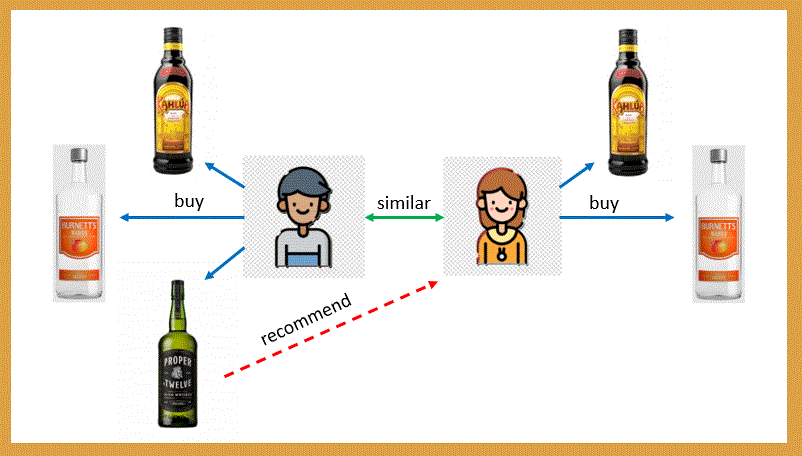

Collaborative filtering recommends items based on similar users' preferences. To calculate the similarities between the vectors, we will be using both cosine similarity and pearson similarity for comparison.

## Cosine Similarity

**Model based on Purchase Count**

In [36]:
# Using purchase count
name = 'cosine'
target = 'Quantity'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3711 items.

Data prepared in: 0.517921s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 17.81ms                        | 54.25      |

| 26.595ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 46.269ms                            | 0                | 0               |

| 1.63s                               | 100              | 3711            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.68448s

recommendations finished on 1000/446139 queries. users per second: 3539.91

recommendations finished on 2000/446139 queries. users per second: 3398.29

recommendations finished on 3000/446139 queries. users per second: 3357.21

recommendations finished on 4000/446139 queries. users per second: 3266.94

recommendations finished on 5000/446139 queries. users per second: 3216.85

recommendations finished on 6000/446139 queries. users per second: 3203.03

recommendations finished on 7000/446139 queries. users per second: 3241.52

recommendations finished on 8000/446139 queries. users per second: 3223.66

recommendations finished on 9000/446139 queries. users per second: 3230.86

recommendations finished on 10000/446139 queries. users per second: 3242.02

recommendations finished on 11000/446139 queries. users per second: 3225.37

recommendations finished on 12000/446139 queries. users per second: 3229.14

recommendations finished on 13000/446139 queries. users per second: 3273.71

recommendations finished on 14000/446139 queries. users per second: 3261.15

recommendations finished on 15000/446139 queries. users per second: 3256.89

recommendations finished on 16000/446139 queries. users per second: 3248.88

recommendations finished on 17000/446139 queries. users per second: 3245.91

recommendations finished on 18000/446139 queries. users per second: 3246.17

recommendations finished on 19000/446139 queries. users per second: 3277.32

recommendations finished on 20000/446139 queries. users per second: 3301.57

recommendations finished on 21000/446139 queries. users per second: 3313.98

recommendations finished on 22000/446139 queries. users per second: 3319.87

recommendations finished on 23000/446139 queries. users per second: 3334.49

recommendations finished on 24000/446139 queries. users per second: 3348.37

recommendations finished on 25000/446139 queries. users per second: 3363.63

recommendations finished on 26000/446139 queries. users per second: 3358.56

recommendations finished on 27000/446139 queries. users per second: 3374.72

recommendations finished on 28000/446139 queries. users per second: 3374.47

recommendations finished on 29000/446139 queries. users per second: 3386.7

recommendations finished on 30000/446139 queries. users per second: 3402.96

recommendations finished on 31000/446139 queries. users per second: 3424.42

recommendations finished on 32000/446139 queries. users per second: 3436.72

recommendations finished on 33000/446139 queries. users per second: 3450.26

recommendations finished on 34000/446139 queries. users per second: 3449.29

recommendations finished on 35000/446139 queries. users per second: 3465.59

recommendations finished on 36000/446139 queries. users per second: 3458.04

recommendations finished on 37000/446139 queries. users per second: 3467.72

recommendations finished on 38000/446139 queries. users per second: 3496.6

recommendations finished on 39000/446139 queries. users per second: 3519.87

recommendations finished on 40000/446139 queries. users per second: 3521.7

recommendations finished on 41000/446139 queries. users per second: 3536.39

recommendations finished on 42000/446139 queries. users per second: 3539.11

recommendations finished on 43000/446139 queries. users per second: 3550.24

recommendations finished on 44000/446139 queries. users per second: 3560.42

recommendations finished on 45000/446139 queries. users per second: 3552.24

recommendations finished on 46000/446139 queries. users per second: 3566.7

recommendations finished on 47000/446139 queries. users per second: 3576.26

recommendations finished on 48000/446139 queries. users per second: 3577.35

recommendations finished on 49000/446139 queries. users per second: 3580.61

recommendations finished on 50000/446139 queries. users per second: 3594.31

recommendations finished on 51000/446139 queries. users per second: 3609.01

recommendations finished on 52000/446139 queries. users per second: 3603.26

recommendations finished on 53000/446139 queries. users per second: 3605.94

recommendations finished on 54000/446139 queries. users per second: 3603.77

recommendations finished on 55000/446139 queries. users per second: 3609.53

recommendations finished on 56000/446139 queries. users per second: 3603.3

recommendations finished on 57000/446139 queries. users per second: 3597.3

recommendations finished on 58000/446139 queries. users per second: 3586.62

recommendations finished on 59000/446139 queries. users per second: 3585.33

recommendations finished on 60000/446139 queries. users per second: 3588.69

recommendations finished on 61000/446139 queries. users per second: 3597.96

recommendations finished on 62000/446139 queries. users per second: 3606.16

recommendations finished on 63000/446139 queries. users per second: 3608.42

recommendations finished on 64000/446139 queries. users per second: 3598.79

recommendations finished on 65000/446139 queries. users per second: 3593.24

recommendations finished on 66000/446139 queries. users per second: 3585.6

recommendations finished on 67000/446139 queries. users per second: 3578.26

recommendations finished on 68000/446139 queries. users per second: 3575.2

recommendations finished on 69000/446139 queries. users per second: 3566.7

recommendations finished on 70000/446139 queries. users per second: 3556.84

recommendations finished on 71000/446139 queries. users per second: 3550.83

recommendations finished on 72000/446139 queries. users per second: 3546.68

recommendations finished on 73000/446139 queries. users per second: 3545.19

recommendations finished on 74000/446139 queries. users per second: 3537.29

recommendations finished on 75000/446139 queries. users per second: 3531.06

recommendations finished on 76000/446139 queries. users per second: 3524.52

recommendations finished on 77000/446139 queries. users per second: 3513.98

recommendations finished on 78000/446139 queries. users per second: 3512

recommendations finished on 79000/446139 queries. users per second: 3505.54

recommendations finished on 80000/446139 queries. users per second: 3500.86

recommendations finished on 81000/446139 queries. users per second: 3498.61

recommendations finished on 82000/446139 queries. users per second: 3497.31

recommendations finished on 83000/446139 queries. users per second: 3495.57

recommendations finished on 84000/446139 queries. users per second: 3491.67

recommendations finished on 85000/446139 queries. users per second: 3488.25

recommendations finished on 86000/446139 queries. users per second: 3488.04

recommendations finished on 87000/446139 queries. users per second: 3482.77

recommendations finished on 88000/446139 queries. users per second: 3480.19

recommendations finished on 89000/446139 queries. users per second: 3475.01

recommendations finished on 90000/446139 queries. users per second: 3466.02

recommendations finished on 91000/446139 queries. users per second: 3462.92

recommendations finished on 92000/446139 queries. users per second: 3457.62

recommendations finished on 93000/446139 queries. users per second: 3453.42

recommendations finished on 94000/446139 queries. users per second: 3451.72

recommendations finished on 95000/446139 queries. users per second: 3448.66

recommendations finished on 96000/446139 queries. users per second: 3441.97

recommendations finished on 97000/446139 queries. users per second: 3438.25

recommendations finished on 98000/446139 queries. users per second: 3437.52

recommendations finished on 99000/446139 queries. users per second: 3434.92

recommendations finished on 100000/446139 queries. users per second: 3431.45

recommendations finished on 101000/446139 queries. users per second: 3428.96

recommendations finished on 102000/446139 queries. users per second: 3427.4

recommendations finished on 103000/446139 queries. users per second: 3425.18

recommendations finished on 104000/446139 queries. users per second: 3424.31

recommendations finished on 105000/446139 queries. users per second: 3420.85

recommendations finished on 106000/446139 queries. users per second: 3417.64

recommendations finished on 107000/446139 queries. users per second: 3416.69

recommendations finished on 108000/446139 queries. users per second: 3416.79

recommendations finished on 109000/446139 queries. users per second: 3415.01

recommendations finished on 110000/446139 queries. users per second: 3412.2

recommendations finished on 111000/446139 queries. users per second: 3408.82

recommendations finished on 112000/446139 queries. users per second: 3404.68

recommendations finished on 113000/446139 queries. users per second: 3405.18

recommendations finished on 114000/446139 queries. users per second: 3403.55

recommendations finished on 115000/446139 queries. users per second: 3403.34

recommendations finished on 116000/446139 queries. users per second: 3403.26

recommendations finished on 117000/446139 queries. users per second: 3401.05

recommendations finished on 118000/446139 queries. users per second: 3401.79

recommendations finished on 119000/446139 queries. users per second: 3401.25

recommendations finished on 120000/446139 queries. users per second: 3400.23

recommendations finished on 121000/446139 queries. users per second: 3397.66

recommendations finished on 122000/446139 queries. users per second: 3396.74

recommendations finished on 123000/446139 queries. users per second: 3396.51

recommendations finished on 124000/446139 queries. users per second: 3397.05

recommendations finished on 125000/446139 queries. users per second: 3397.2

recommendations finished on 126000/446139 queries. users per second: 3398.12

recommendations finished on 127000/446139 queries. users per second: 3398.36

recommendations finished on 128000/446139 queries. users per second: 3397.12

recommendations finished on 129000/446139 queries. users per second: 3399.46

recommendations finished on 130000/446139 queries. users per second: 3401.27

recommendations finished on 131000/446139 queries. users per second: 3404.88

recommendations finished on 132000/446139 queries. users per second: 3411.15

recommendations finished on 133000/446139 queries. users per second: 3414.15

recommendations finished on 134000/446139 queries. users per second: 3414.44

recommendations finished on 135000/446139 queries. users per second: 3417.5

recommendations finished on 136000/446139 queries. users per second: 3424.02

recommendations finished on 137000/446139 queries. users per second: 3426.49

recommendations finished on 138000/446139 queries. users per second: 3430.38

recommendations finished on 139000/446139 queries. users per second: 3437.7

recommendations finished on 140000/446139 queries. users per second: 3440.96

recommendations finished on 141000/446139 queries. users per second: 3443.33

recommendations finished on 142000/446139 queries. users per second: 3446.92

recommendations finished on 143000/446139 queries. users per second: 3452.08

recommendations finished on 144000/446139 queries. users per second: 3453.85

recommendations finished on 145000/446139 queries. users per second: 3453.65

recommendations finished on 146000/446139 queries. users per second: 3449.82

recommendations finished on 147000/446139 queries. users per second: 3450.63

recommendations finished on 148000/446139 queries. users per second: 3453.01

recommendations finished on 149000/446139 queries. users per second: 3455.56

recommendations finished on 150000/446139 queries. users per second: 3455.88

recommendations finished on 151000/446139 queries. users per second: 3461.57

recommendations finished on 152000/446139 queries. users per second: 3469.61

recommendations finished on 153000/446139 queries. users per second: 3475.76

recommendations finished on 154000/446139 queries. users per second: 3478.6

recommendations finished on 155000/446139 queries. users per second: 3484.02

recommendations finished on 156000/446139 queries. users per second: 3481.85

recommendations finished on 157000/446139 queries. users per second: 3474.89

recommendations finished on 158000/446139 queries. users per second: 3467.86

recommendations finished on 159000/446139 queries. users per second: 3462.08

recommendations finished on 160000/446139 queries. users per second: 3455.36

recommendations finished on 161000/446139 queries. users per second: 3444.74

recommendations finished on 162000/446139 queries. users per second: 3441.24

recommendations finished on 163000/446139 queries. users per second: 3437.09

recommendations finished on 164000/446139 queries. users per second: 3433.55

recommendations finished on 165000/446139 queries. users per second: 3429.32

recommendations finished on 166000/446139 queries. users per second: 3426.24

recommendations finished on 167000/446139 queries. users per second: 3429.06

recommendations finished on 168000/446139 queries. users per second: 3425.48

recommendations finished on 169000/446139 queries. users per second: 3419.68

recommendations finished on 170000/446139 queries. users per second: 3417.13

recommendations finished on 171000/446139 queries. users per second: 3411.34

recommendations finished on 172000/446139 queries. users per second: 3404.67

recommendations finished on 173000/446139 queries. users per second: 3403.23

recommendations finished on 174000/446139 queries. users per second: 3406.73

recommendations finished on 175000/446139 queries. users per second: 3405.55

recommendations finished on 176000/446139 queries. users per second: 3406.56

recommendations finished on 177000/446139 queries. users per second: 3407.68

recommendations finished on 178000/446139 queries. users per second: 3408.71

recommendations finished on 179000/446139 queries. users per second: 3409.27

recommendations finished on 180000/446139 queries. users per second: 3409.27

recommendations finished on 181000/446139 queries. users per second: 3408.57

recommendations finished on 182000/446139 queries. users per second: 3407.56

recommendations finished on 183000/446139 queries. users per second: 3405.86

recommendations finished on 184000/446139 queries. users per second: 3405.48

recommendations finished on 185000/446139 queries. users per second: 3402.86

recommendations finished on 186000/446139 queries. users per second: 3401.52

recommendations finished on 187000/446139 queries. users per second: 3401.86

recommendations finished on 188000/446139 queries. users per second: 3399.22

recommendations finished on 189000/446139 queries. users per second: 3396.85

recommendations finished on 190000/446139 queries. users per second: 3395.8

recommendations finished on 191000/446139 queries. users per second: 3395.88

recommendations finished on 192000/446139 queries. users per second: 3396.83

recommendations finished on 193000/446139 queries. users per second: 3399.04

recommendations finished on 194000/446139 queries. users per second: 3401.3

recommendations finished on 195000/446139 queries. users per second: 3402.54

recommendations finished on 196000/446139 queries. users per second: 3404.53

recommendations finished on 197000/446139 queries. users per second: 3406.91

recommendations finished on 198000/446139 queries. users per second: 3409.5

recommendations finished on 199000/446139 queries. users per second: 3411.85

recommendations finished on 200000/446139 queries. users per second: 3411.13

recommendations finished on 201000/446139 queries. users per second: 3412.62

recommendations finished on 202000/446139 queries. users per second: 3414.14

recommendations finished on 203000/446139 queries. users per second: 3415.52

recommendations finished on 204000/446139 queries. users per second: 3416.2

recommendations finished on 205000/446139 queries. users per second: 3417.52

recommendations finished on 206000/446139 queries. users per second: 3417.87

recommendations finished on 207000/446139 queries. users per second: 3418.17

recommendations finished on 208000/446139 queries. users per second: 3417.23

recommendations finished on 209000/446139 queries. users per second: 3416.15

recommendations finished on 210000/446139 queries. users per second: 3417.25

recommendations finished on 211000/446139 queries. users per second: 3417.34

recommendations finished on 212000/446139 queries. users per second: 3415.12

recommendations finished on 213000/446139 queries. users per second: 3415.72

recommendations finished on 214000/446139 queries. users per second: 3414.74

recommendations finished on 215000/446139 queries. users per second: 3413.07

recommendations finished on 216000/446139 queries. users per second: 3412.76

recommendations finished on 217000/446139 queries. users per second: 3413.27

recommendations finished on 218000/446139 queries. users per second: 3413.19

recommendations finished on 219000/446139 queries. users per second: 3411.95

recommendations finished on 220000/446139 queries. users per second: 3410.57

recommendations finished on 221000/446139 queries. users per second: 3408.45

recommendations finished on 222000/446139 queries. users per second: 3407.65

recommendations finished on 223000/446139 queries. users per second: 3407.11

recommendations finished on 224000/446139 queries. users per second: 3405.79

recommendations finished on 225000/446139 queries. users per second: 3405.15

recommendations finished on 226000/446139 queries. users per second: 3405.44

recommendations finished on 227000/446139 queries. users per second: 3404.48

recommendations finished on 228000/446139 queries. users per second: 3403.58

recommendations finished on 229000/446139 queries. users per second: 3403.47

recommendations finished on 230000/446139 queries. users per second: 3402.4

recommendations finished on 231000/446139 queries. users per second: 3401.63

recommendations finished on 232000/446139 queries. users per second: 3400.27

recommendations finished on 233000/446139 queries. users per second: 3401.86

recommendations finished on 234000/446139 queries. users per second: 3401.51

recommendations finished on 235000/446139 queries. users per second: 3401.7

recommendations finished on 236000/446139 queries. users per second: 3402.34

recommendations finished on 237000/446139 queries. users per second: 3400.89

recommendations finished on 238000/446139 queries. users per second: 3401.63

recommendations finished on 239000/446139 queries. users per second: 3401.99

recommendations finished on 240000/446139 queries. users per second: 3402.72

recommendations finished on 241000/446139 queries. users per second: 3403.07

recommendations finished on 242000/446139 queries. users per second: 3401.83

recommendations finished on 243000/446139 queries. users per second: 3403.06

recommendations finished on 244000/446139 queries. users per second: 3404.57

recommendations finished on 245000/446139 queries. users per second: 3405.46

recommendations finished on 246000/446139 queries. users per second: 3406.54

recommendations finished on 247000/446139 queries. users per second: 3408.21

recommendations finished on 248000/446139 queries. users per second: 3408.38

recommendations finished on 249000/446139 queries. users per second: 3409.29

recommendations finished on 250000/446139 queries. users per second: 3408.51

recommendations finished on 251000/446139 queries. users per second: 3407.67

recommendations finished on 252000/446139 queries. users per second: 3406.64

recommendations finished on 253000/446139 queries. users per second: 3407

recommendations finished on 254000/446139 queries. users per second: 3407.06

recommendations finished on 255000/446139 queries. users per second: 3409.11

recommendations finished on 256000/446139 queries. users per second: 3411.5

recommendations finished on 257000/446139 queries. users per second: 3413.05

recommendations finished on 258000/446139 queries. users per second: 3415.37

recommendations finished on 259000/446139 queries. users per second: 3417.52

recommendations finished on 260000/446139 queries. users per second: 3419.27

recommendations finished on 261000/446139 queries. users per second: 3420.82

recommendations finished on 262000/446139 queries. users per second: 3420.7

recommendations finished on 263000/446139 queries. users per second: 3419.75

recommendations finished on 264000/446139 queries. users per second: 3418.57

recommendations finished on 265000/446139 queries. users per second: 3417.91

recommendations finished on 266000/446139 queries. users per second: 3417.85

recommendations finished on 267000/446139 queries. users per second: 3418.11

recommendations finished on 268000/446139 queries. users per second: 3418.52

recommendations finished on 269000/446139 queries. users per second: 3418.45

recommendations finished on 270000/446139 queries. users per second: 3417.94

recommendations finished on 271000/446139 queries. users per second: 3418.03

recommendations finished on 272000/446139 queries. users per second: 3417.81

recommendations finished on 273000/446139 queries. users per second: 3418.11

recommendations finished on 274000/446139 queries. users per second: 3418.44

recommendations finished on 275000/446139 queries. users per second: 3417.2

recommendations finished on 276000/446139 queries. users per second: 3417.45

recommendations finished on 277000/446139 queries. users per second: 3417.43

recommendations finished on 278000/446139 queries. users per second: 3416.87

recommendations finished on 279000/446139 queries. users per second: 3416.73

recommendations finished on 280000/446139 queries. users per second: 3415.91

recommendations finished on 281000/446139 queries. users per second: 3415.43

recommendations finished on 282000/446139 queries. users per second: 3416.09

recommendations finished on 283000/446139 queries. users per second: 3416.24

recommendations finished on 284000/446139 queries. users per second: 3415.76

recommendations finished on 285000/446139 queries. users per second: 3415.06

recommendations finished on 286000/446139 queries. users per second: 3413.59

recommendations finished on 287000/446139 queries. users per second: 3413.72

recommendations finished on 288000/446139 queries. users per second: 3414.34

recommendations finished on 289000/446139 queries. users per second: 3413.57

recommendations finished on 290000/446139 queries. users per second: 3413.96

recommendations finished on 291000/446139 queries. users per second: 3412.39

recommendations finished on 292000/446139 queries. users per second: 3412.49

recommendations finished on 293000/446139 queries. users per second: 3411.75

recommendations finished on 294000/446139 queries. users per second: 3411.41

recommendations finished on 295000/446139 queries. users per second: 3411.53

recommendations finished on 296000/446139 queries. users per second: 3411.98

recommendations finished on 297000/446139 queries. users per second: 3412.18

recommendations finished on 298000/446139 queries. users per second: 3412.75

recommendations finished on 299000/446139 queries. users per second: 3413.43

recommendations finished on 300000/446139 queries. users per second: 3412.67

recommendations finished on 301000/446139 queries. users per second: 3412.51

recommendations finished on 302000/446139 queries. users per second: 3412.07

recommendations finished on 303000/446139 queries. users per second: 3411.58

recommendations finished on 304000/446139 queries. users per second: 3411.77

recommendations finished on 305000/446139 queries. users per second: 3411.03

recommendations finished on 306000/446139 queries. users per second: 3410.11

recommendations finished on 307000/446139 queries. users per second: 3408.11

recommendations finished on 308000/446139 queries. users per second: 3408.58

recommendations finished on 309000/446139 queries. users per second: 3410.61

recommendations finished on 310000/446139 queries. users per second: 3411.44

recommendations finished on 311000/446139 queries. users per second: 3410.77

recommendations finished on 312000/446139 queries. users per second: 3410.29

recommendations finished on 313000/446139 queries. users per second: 3410.89

recommendations finished on 314000/446139 queries. users per second: 3412.27

recommendations finished on 315000/446139 queries. users per second: 3413.06

recommendations finished on 316000/446139 queries. users per second: 3414.89

recommendations finished on 317000/446139 queries. users per second: 3416.04

recommendations finished on 318000/446139 queries. users per second: 3417.4

recommendations finished on 319000/446139 queries. users per second: 3418.02

recommendations finished on 320000/446139 queries. users per second: 3419.41

recommendations finished on 321000/446139 queries. users per second: 3420.68

recommendations finished on 322000/446139 queries. users per second: 3421.3

recommendations finished on 323000/446139 queries. users per second: 3421.87

recommendations finished on 324000/446139 queries. users per second: 3422.55

recommendations finished on 325000/446139 queries. users per second: 3424.05

recommendations finished on 326000/446139 queries. users per second: 3425.47

recommendations finished on 327000/446139 queries. users per second: 3426.71

recommendations finished on 328000/446139 queries. users per second: 3428.32

recommendations finished on 329000/446139 queries. users per second: 3429.4

recommendations finished on 330000/446139 queries. users per second: 3430.75

recommendations finished on 331000/446139 queries. users per second: 3433.26

recommendations finished on 332000/446139 queries. users per second: 3435.15

recommendations finished on 333000/446139 queries. users per second: 3436.01

recommendations finished on 334000/446139 queries. users per second: 3435.8

recommendations finished on 335000/446139 queries. users per second: 3434.29

recommendations finished on 336000/446139 queries. users per second: 3433.02

recommendations finished on 337000/446139 queries. users per second: 3433.25

recommendations finished on 338000/446139 queries. users per second: 3431.33

recommendations finished on 339000/446139 queries. users per second: 3432.25

recommendations finished on 340000/446139 queries. users per second: 3432.55

recommendations finished on 341000/446139 queries. users per second: 3432.66

recommendations finished on 342000/446139 queries. users per second: 3432.23

recommendations finished on 343000/446139 queries. users per second: 3432.51

recommendations finished on 344000/446139 queries. users per second: 3432.88

recommendations finished on 345000/446139 queries. users per second: 3433.13

recommendations finished on 346000/446139 queries. users per second: 3433.98

recommendations finished on 347000/446139 queries. users per second: 3434.72

recommendations finished on 348000/446139 queries. users per second: 3435.28

recommendations finished on 349000/446139 queries. users per second: 3436

recommendations finished on 350000/446139 queries. users per second: 3435.57

recommendations finished on 351000/446139 queries. users per second: 3435.11

recommendations finished on 352000/446139 queries. users per second: 3434.88

recommendations finished on 353000/446139 queries. users per second: 3434.57

recommendations finished on 354000/446139 queries. users per second: 3434.07

recommendations finished on 355000/446139 queries. users per second: 3433.63

recommendations finished on 356000/446139 queries. users per second: 3433.4

recommendations finished on 357000/446139 queries. users per second: 3433.04

recommendations finished on 358000/446139 queries. users per second: 3432.26

recommendations finished on 359000/446139 queries. users per second: 3432.58

recommendations finished on 360000/446139 queries. users per second: 3432.02

recommendations finished on 361000/446139 queries. users per second: 3431.46

recommendations finished on 362000/446139 queries. users per second: 3430.54

recommendations finished on 363000/446139 queries. users per second: 3429.59

recommendations finished on 364000/446139 queries. users per second: 3429.02

recommendations finished on 365000/446139 queries. users per second: 3428.73

recommendations finished on 366000/446139 queries. users per second: 3428.64

recommendations finished on 367000/446139 queries. users per second: 3429.36

recommendations finished on 368000/446139 queries. users per second: 3430.29

recommendations finished on 369000/446139 queries. users per second: 3430.79

recommendations finished on 370000/446139 queries. users per second: 3431.98

recommendations finished on 371000/446139 queries. users per second: 3432.96

recommendations finished on 372000/446139 queries. users per second: 3434.53

recommendations finished on 373000/446139 queries. users per second: 3435.82

recommendations finished on 374000/446139 queries. users per second: 3436.85

recommendations finished on 375000/446139 queries. users per second: 3437.37

recommendations finished on 376000/446139 queries. users per second: 3439.1

recommendations finished on 377000/446139 queries. users per second: 3440.61

recommendations finished on 378000/446139 queries. users per second: 3443.19

recommendations finished on 379000/446139 queries. users per second: 3445.32

recommendations finished on 380000/446139 queries. users per second: 3445.43

recommendations finished on 381000/446139 queries. users per second: 3444.06

recommendations finished on 382000/446139 queries. users per second: 3443.77

recommendations finished on 383000/446139 queries. users per second: 3442.98

recommendations finished on 384000/446139 queries. users per second: 3441.73

recommendations finished on 385000/446139 queries. users per second: 3440.43

recommendations finished on 386000/446139 queries. users per second: 3439.53

recommendations finished on 387000/446139 queries. users per second: 3438.65

recommendations finished on 388000/446139 queries. users per second: 3438.13

recommendations finished on 389000/446139 queries. users per second: 3438.19

recommendations finished on 390000/446139 queries. users per second: 3438.47

recommendations finished on 391000/446139 queries. users per second: 3438.28

recommendations finished on 392000/446139 queries. users per second: 3438.67

recommendations finished on 393000/446139 queries. users per second: 3438.95

recommendations finished on 394000/446139 queries. users per second: 3438.72

recommendations finished on 395000/446139 queries. users per second: 3438.99

recommendations finished on 396000/446139 queries. users per second: 3439.31

recommendations finished on 397000/446139 queries. users per second: 3439.91

recommendations finished on 398000/446139 queries. users per second: 3441.09

recommendations finished on 399000/446139 queries. users per second: 3441.3

recommendations finished on 400000/446139 queries. users per second: 3441.51

recommendations finished on 401000/446139 queries. users per second: 3441.45

recommendations finished on 402000/446139 queries. users per second: 3441.76

recommendations finished on 403000/446139 queries. users per second: 3441.99

recommendations finished on 404000/446139 queries. users per second: 3441.87

recommendations finished on 405000/446139 queries. users per second: 3441.52

recommendations finished on 406000/446139 queries. users per second: 3441.48

recommendations finished on 407000/446139 queries. users per second: 3441.64

recommendations finished on 408000/446139 queries. users per second: 3442.19

recommendations finished on 409000/446139 queries. users per second: 3442.15

recommendations finished on 410000/446139 queries. users per second: 3442.44

recommendations finished on 411000/446139 queries. users per second: 3442.59

recommendations finished on 412000/446139 queries. users per second: 3443.55

recommendations finished on 413000/446139 queries. users per second: 3443.8

recommendations finished on 414000/446139 queries. users per second: 3443.75

recommendations finished on 415000/446139 queries. users per second: 3443.88

recommendations finished on 416000/446139 queries. users per second: 3444.12

recommendations finished on 417000/446139 queries. users per second: 3444.72

recommendations finished on 418000/446139 queries. users per second: 3445.05

recommendations finished on 419000/446139 queries. users per second: 3444.73

recommendations finished on 420000/446139 queries. users per second: 3445.38

recommendations finished on 421000/446139 queries. users per second: 3445.48

recommendations finished on 422000/446139 queries. users per second: 3446.04

recommendations finished on 423000/446139 queries. users per second: 3446.48

recommendations finished on 424000/446139 queries. users per second: 3444.6

recommendations finished on 425000/446139 queries. users per second: 3444.37

recommendations finished on 426000/446139 queries. users per second: 3442.02

recommendations finished on 427000/446139 queries. users per second: 3440.94

recommendations finished on 428000/446139 queries. users per second: 3439.53

recommendations finished on 429000/446139 queries. users per second: 3439.13

recommendations finished on 430000/446139 queries. users per second: 3438.33

recommendations finished on 431000/446139 queries. users per second: 3436.44

recommendations finished on 432000/446139 queries. users per second: 3434

recommendations finished on 433000/446139 queries. users per second: 3432.84

recommendations finished on 434000/446139 queries. users per second: 3431.42

recommendations finished on 435000/446139 queries. users per second: 3429.95

recommendations finished on 436000/446139 queries. users per second: 3427.19

recommendations finished on 437000/446139 queries. users per second: 3424.14

recommendations finished on 438000/446139 queries. users per second: 3419.76

recommendations finished on 439000/446139 queries. users per second: 3419.06

recommendations finished on 440000/446139 queries. users per second: 3418.64

recommendations finished on 441000/446139 queries. users per second: 3417.5

recommendations finished on 442000/446139 queries. users per second: 3417.03

recommendations finished on 443000/446139 queries. users per second: 3417.11

recommendations finished on 444000/446139 queries. users per second: 3415.81

recommendations finished on 445000/446139 queries. users per second: 3414.97

recommendations finished on 446000/446139 queries. users per second: 3414.55

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |    4000   | 1349.4779419964011 |  1   |
|    3814    |    4184   | 1269.533804178238  |  2   |
|    3814    |   19478   | 1046.8913627310233 |  3   |
|    3814    |    4356   | 1046.3909264553677 |  4   |
|    3814    |    4716   | 895.1923491564664  |  5   |
|    3814    |   11298   | 751.1514960928397  |  6   |
|    3814    |   43128   | 693.7259296319702  |  7   |
|    3814    |   38178   | 478.9781338041479  |  8   |
|    3814    |   43338   | 370.8882424235344  |  9   |
|    3814    |   15884   | 354.5847125226801  |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [37]:
# Using purchase dummy
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 8.01829s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 109.428ms                      | 54.25      |

| 194.103ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 209.813ms                           | 0                | 2               |

| 3.26s                               | 2.75             | 110             |

| 6.25s                               | 5.5              | 216             |

| 9.25s                               | 8.25             | 323             |

| 12.23s                              | 11               | 429             |

| 15.24s                              | 13.75            | 536             |

| 18.21s                              | 16.5             | 642             |

| 21.21s                              | 19.25            | 749             |

| 24.22s                              | 22.25            | 856             |

| 27.22s                              | 25               | 963             |

| 30.24s                              | 27.75            | 1069            |

| 33.30s                              | 30.5             | 1178            |

| 36.24s                              | 33.25            | 1282            |

| 39.24s                              | 36               | 1388            |

| 42.28s                              | 38.75            | 1497            |

| 45.24s                              | 41.5             | 1601            |

| 48.28s                              | 44.25            | 1710            |

| 51.26s                              | 47               | 1816            |

| 54.25s                              | 50               | 1923            |

| 57.27s                              | 52.75            | 2030            |

| 1m 0s                               | 55.5             | 2136            |

| 1m 3s                               | 58.25            | 2243            |

| 1m 6s                               | 61               | 2349            |

| 1m 9s                               | 63.75            | 2454            |

| 1m 12s                              | 66.5             | 2563            |

| 1m 15s                              | 69.25            | 2669            |

| 1m 18s                              | 72               | 2776            |

| 1m 21s                              | 74.75            | 2882            |

| 1m 24s                              | 77.5             | 2989            |

| 1m 27s                              | 80.25            | 3095            |

| 1m 30s                              | 83               | 3200            |

| 1m 33s                              | 86               | 3308            |

| 1m 36s                              | 88.75            | 3415            |

| 1m 39s                              | 91.5             | 3520            |

| 1m 42s                              | 94.25            | 3629            |

| 1m 45s                              | 97               | 3732            |

| 1m 48s                              | 99.75            | 3839            |

| 1m 48s                              | 100              | 3846            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 109.005s

recommendations finished on 1000/446139 queries. users per second: 587.375

recommendations finished on 2000/446139 queries. users per second: 577

recommendations finished on 3000/446139 queries. users per second: 574.642

recommendations finished on 4000/446139 queries. users per second: 574.354

recommendations finished on 5000/446139 queries. users per second: 573.1

recommendations finished on 6000/446139 queries. users per second: 573.088

recommendations finished on 7000/446139 queries. users per second: 573.812

recommendations finished on 8000/446139 queries. users per second: 575.061

recommendations finished on 9000/446139 queries. users per second: 576.757

recommendations finished on 10000/446139 queries. users per second: 576.881

recommendations finished on 11000/446139 queries. users per second: 577.998

recommendations finished on 12000/446139 queries. users per second: 578.365

recommendations finished on 13000/446139 queries. users per second: 578.374

recommendations finished on 14000/446139 queries. users per second: 578.699

recommendations finished on 15000/446139 queries. users per second: 578.814

recommendations finished on 16000/446139 queries. users per second: 579.005

recommendations finished on 17000/446139 queries. users per second: 579.232

recommendations finished on 18000/446139 queries. users per second: 579.031

recommendations finished on 19000/446139 queries. users per second: 578.748

recommendations finished on 20000/446139 queries. users per second: 578.899

recommendations finished on 21000/446139 queries. users per second: 578.721

recommendations finished on 22000/446139 queries. users per second: 578.177

recommendations finished on 23000/446139 queries. users per second: 578.281

recommendations finished on 24000/446139 queries. users per second: 578.306

recommendations finished on 25000/446139 queries. users per second: 578.386

recommendations finished on 26000/446139 queries. users per second: 578.298

recommendations finished on 27000/446139 queries. users per second: 578.244

recommendations finished on 28000/446139 queries. users per second: 578.21

recommendations finished on 29000/446139 queries. users per second: 578.225

recommendations finished on 30000/446139 queries. users per second: 578.234

recommendations finished on 31000/446139 queries. users per second: 578.319

recommendations finished on 32000/446139 queries. users per second: 578.737

recommendations finished on 33000/446139 queries. users per second: 578.803

recommendations finished on 34000/446139 queries. users per second: 579.043

recommendations finished on 35000/446139 queries. users per second: 579.303

recommendations finished on 36000/446139 queries. users per second: 579.376

recommendations finished on 37000/446139 queries. users per second: 579.544

recommendations finished on 38000/446139 queries. users per second: 579.665

recommendations finished on 39000/446139 queries. users per second: 579.498

recommendations finished on 40000/446139 queries. users per second: 579.617

recommendations finished on 41000/446139 queries. users per second: 579.746

recommendations finished on 42000/446139 queries. users per second: 579.883

recommendations finished on 43000/446139 queries. users per second: 579.83

recommendations finished on 44000/446139 queries. users per second: 579.888

recommendations finished on 45000/446139 queries. users per second: 579.976

recommendations finished on 46000/446139 queries. users per second: 580.091

recommendations finished on 47000/446139 queries. users per second: 580.214

recommendations finished on 48000/446139 queries. users per second: 580.423

recommendations finished on 49000/446139 queries. users per second: 580.578

recommendations finished on 50000/446139 queries. users per second: 580.719

recommendations finished on 51000/446139 queries. users per second: 580.852

recommendations finished on 52000/446139 queries. users per second: 580.834

recommendations finished on 53000/446139 queries. users per second: 580.769

recommendations finished on 54000/446139 queries. users per second: 580.67

recommendations finished on 55000/446139 queries. users per second: 580.711

recommendations finished on 56000/446139 queries. users per second: 580.766

recommendations finished on 57000/446139 queries. users per second: 580.668

recommendations finished on 58000/446139 queries. users per second: 580.399

recommendations finished on 59000/446139 queries. users per second: 580.387

recommendations finished on 60000/446139 queries. users per second: 580.304

recommendations finished on 61000/446139 queries. users per second: 580.375

recommendations finished on 62000/446139 queries. users per second: 580.347

recommendations finished on 63000/446139 queries. users per second: 580.353

recommendations finished on 64000/446139 queries. users per second: 580.312

recommendations finished on 65000/446139 queries. users per second: 580.1

recommendations finished on 66000/446139 queries. users per second: 580.036

recommendations finished on 67000/446139 queries. users per second: 579.946

recommendations finished on 68000/446139 queries. users per second: 579.906

recommendations finished on 69000/446139 queries. users per second: 579.568

recommendations finished on 70000/446139 queries. users per second: 579.21

recommendations finished on 71000/446139 queries. users per second: 578.976

recommendations finished on 72000/446139 queries. users per second: 578.708

recommendations finished on 73000/446139 queries. users per second: 578.391

recommendations finished on 74000/446139 queries. users per second: 578.117

recommendations finished on 75000/446139 queries. users per second: 577.931

recommendations finished on 76000/446139 queries. users per second: 577.643

recommendations finished on 77000/446139 queries. users per second: 577.303

recommendations finished on 78000/446139 queries. users per second: 577.074

recommendations finished on 79000/446139 queries. users per second: 576.808

recommendations finished on 80000/446139 queries. users per second: 576.577

recommendations finished on 81000/446139 queries. users per second: 576.396

recommendations finished on 82000/446139 queries. users per second: 576.242

recommendations finished on 83000/446139 queries. users per second: 576.031

recommendations finished on 84000/446139 queries. users per second: 575.825

recommendations finished on 85000/446139 queries. users per second: 575.622

recommendations finished on 86000/446139 queries. users per second: 575.373

recommendations finished on 87000/446139 queries. users per second: 575.156

recommendations finished on 88000/446139 queries. users per second: 574.997

recommendations finished on 89000/446139 queries. users per second: 574.841

recommendations finished on 90000/446139 queries. users per second: 574.719

recommendations finished on 91000/446139 queries. users per second: 574.573

recommendations finished on 92000/446139 queries. users per second: 574.404

recommendations finished on 93000/446139 queries. users per second: 574.247

recommendations finished on 94000/446139 queries. users per second: 574.179

recommendations finished on 95000/446139 queries. users per second: 574.026

recommendations finished on 96000/446139 queries. users per second: 573.873

recommendations finished on 97000/446139 queries. users per second: 573.682

recommendations finished on 98000/446139 queries. users per second: 573.542

recommendations finished on 99000/446139 queries. users per second: 573.376

recommendations finished on 100000/446139 queries. users per second: 573.177

recommendations finished on 101000/446139 queries. users per second: 573.076

recommendations finished on 102000/446139 queries. users per second: 573.043

recommendations finished on 103000/446139 queries. users per second: 572.948

recommendations finished on 104000/446139 queries. users per second: 572.894

recommendations finished on 105000/446139 queries. users per second: 572.789

recommendations finished on 106000/446139 queries. users per second: 572.674

recommendations finished on 107000/446139 queries. users per second: 572.539

recommendations finished on 108000/446139 queries. users per second: 572.392

recommendations finished on 109000/446139 queries. users per second: 572.335

recommendations finished on 110000/446139 queries. users per second: 572.322

recommendations finished on 111000/446139 queries. users per second: 572.308

recommendations finished on 112000/446139 queries. users per second: 572.278

recommendations finished on 113000/446139 queries. users per second: 572.255

recommendations finished on 114000/446139 queries. users per second: 572.167

recommendations finished on 115000/446139 queries. users per second: 572.036

recommendations finished on 116000/446139 queries. users per second: 571.978

recommendations finished on 117000/446139 queries. users per second: 571.94

recommendations finished on 118000/446139 queries. users per second: 571.909

recommendations finished on 119000/446139 queries. users per second: 571.863

recommendations finished on 120000/446139 queries. users per second: 571.791

recommendations finished on 121000/446139 queries. users per second: 571.688

recommendations finished on 122000/446139 queries. users per second: 571.645

recommendations finished on 123000/446139 queries. users per second: 571.626

recommendations finished on 124000/446139 queries. users per second: 571.586

recommendations finished on 125000/446139 queries. users per second: 571.529

recommendations finished on 126000/446139 queries. users per second: 571.47

recommendations finished on 127000/446139 queries. users per second: 571.388

recommendations finished on 128000/446139 queries. users per second: 571.304

recommendations finished on 129000/446139 queries. users per second: 571.3

recommendations finished on 130000/446139 queries. users per second: 571.184

recommendations finished on 131000/446139 queries. users per second: 571.131

recommendations finished on 132000/446139 queries. users per second: 571.09

recommendations finished on 133000/446139 queries. users per second: 571.043

recommendations finished on 134000/446139 queries. users per second: 570.964

recommendations finished on 135000/446139 queries. users per second: 570.944

recommendations finished on 136000/446139 queries. users per second: 570.956

recommendations finished on 137000/446139 queries. users per second: 570.915

recommendations finished on 138000/446139 queries. users per second: 570.955

recommendations finished on 139000/446139 queries. users per second: 570.956

recommendations finished on 140000/446139 queries. users per second: 571.029

recommendations finished on 141000/446139 queries. users per second: 571.078

recommendations finished on 142000/446139 queries. users per second: 571.05

recommendations finished on 143000/446139 queries. users per second: 571.042

recommendations finished on 144000/446139 queries. users per second: 571.013

recommendations finished on 145000/446139 queries. users per second: 571

recommendations finished on 146000/446139 queries. users per second: 571.012

recommendations finished on 147000/446139 queries. users per second: 571.032

recommendations finished on 148000/446139 queries. users per second: 570.988

recommendations finished on 149000/446139 queries. users per second: 570.982

recommendations finished on 150000/446139 queries. users per second: 570.944

recommendations finished on 151000/446139 queries. users per second: 570.897

recommendations finished on 152000/446139 queries. users per second: 570.856

recommendations finished on 153000/446139 queries. users per second: 571.001

recommendations finished on 154000/446139 queries. users per second: 571.204

recommendations finished on 155000/446139 queries. users per second: 571.405

recommendations finished on 156000/446139 queries. users per second: 571.597

recommendations finished on 157000/446139 queries. users per second: 571.797

recommendations finished on 158000/446139 queries. users per second: 571.965

recommendations finished on 159000/446139 queries. users per second: 572.076

recommendations finished on 160000/446139 queries. users per second: 572.19

recommendations finished on 161000/446139 queries. users per second: 572.302

recommendations finished on 162000/446139 queries. users per second: 572.385

recommendations finished on 163000/446139 queries. users per second: 572.492

recommendations finished on 164000/446139 queries. users per second: 572.571

recommendations finished on 165000/446139 queries. users per second: 572.624

recommendations finished on 166000/446139 queries. users per second: 572.659

recommendations finished on 167000/446139 queries. users per second: 572.79

recommendations finished on 168000/446139 queries. users per second: 572.864

recommendations finished on 169000/446139 queries. users per second: 573.014

recommendations finished on 170000/446139 queries. users per second: 573.105

recommendations finished on 171000/446139 queries. users per second: 573.269

recommendations finished on 172000/446139 queries. users per second: 573.41

recommendations finished on 173000/446139 queries. users per second: 573.56

recommendations finished on 174000/446139 queries. users per second: 573.653

recommendations finished on 175000/446139 queries. users per second: 573.708

recommendations finished on 176000/446139 queries. users per second: 573.812

recommendations finished on 177000/446139 queries. users per second: 573.874

recommendations finished on 178000/446139 queries. users per second: 573.974

recommendations finished on 179000/446139 queries. users per second: 573.958

recommendations finished on 180000/446139 queries. users per second: 573.907

recommendations finished on 181000/446139 queries. users per second: 573.856

recommendations finished on 182000/446139 queries. users per second: 573.777

recommendations finished on 183000/446139 queries. users per second: 573.666

recommendations finished on 184000/446139 queries. users per second: 573.581

recommendations finished on 185000/446139 queries. users per second: 573.576

recommendations finished on 186000/446139 queries. users per second: 573.545

recommendations finished on 187000/446139 queries. users per second: 573.582

recommendations finished on 188000/446139 queries. users per second: 573.61

recommendations finished on 189000/446139 queries. users per second: 573.652

recommendations finished on 190000/446139 queries. users per second: 573.681

recommendations finished on 191000/446139 queries. users per second: 573.738

recommendations finished on 192000/446139 queries. users per second: 573.779

recommendations finished on 193000/446139 queries. users per second: 573.815

recommendations finished on 194000/446139 queries. users per second: 573.844

recommendations finished on 195000/446139 queries. users per second: 573.899

recommendations finished on 196000/446139 queries. users per second: 573.973

recommendations finished on 197000/446139 queries. users per second: 573.977

recommendations finished on 198000/446139 queries. users per second: 573.984

recommendations finished on 199000/446139 queries. users per second: 573.942

recommendations finished on 200000/446139 queries. users per second: 573.919

recommendations finished on 201000/446139 queries. users per second: 573.915

recommendations finished on 202000/446139 queries. users per second: 573.847

recommendations finished on 203000/446139 queries. users per second: 573.804

recommendations finished on 204000/446139 queries. users per second: 573.756

recommendations finished on 205000/446139 queries. users per second: 573.664

recommendations finished on 206000/446139 queries. users per second: 573.579

recommendations finished on 207000/446139 queries. users per second: 573.492

recommendations finished on 208000/446139 queries. users per second: 573.462

recommendations finished on 209000/446139 queries. users per second: 573.487

recommendations finished on 210000/446139 queries. users per second: 573.531

recommendations finished on 211000/446139 queries. users per second: 573.552

recommendations finished on 212000/446139 queries. users per second: 573.602

recommendations finished on 213000/446139 queries. users per second: 573.665

recommendations finished on 214000/446139 queries. users per second: 573.723

recommendations finished on 215000/446139 queries. users per second: 573.75

recommendations finished on 216000/446139 queries. users per second: 573.803

recommendations finished on 217000/446139 queries. users per second: 573.869

recommendations finished on 218000/446139 queries. users per second: 573.94

recommendations finished on 219000/446139 queries. users per second: 573.986

recommendations finished on 220000/446139 queries. users per second: 574.001

recommendations finished on 221000/446139 queries. users per second: 574.017

recommendations finished on 222000/446139 queries. users per second: 574.049

recommendations finished on 223000/446139 queries. users per second: 574.06

recommendations finished on 224000/446139 queries. users per second: 574.064

recommendations finished on 225000/446139 queries. users per second: 574.061

recommendations finished on 226000/446139 queries. users per second: 574.063

recommendations finished on 227000/446139 queries. users per second: 574.063

recommendations finished on 228000/446139 queries. users per second: 574.09

recommendations finished on 229000/446139 queries. users per second: 574.11

recommendations finished on 230000/446139 queries. users per second: 574.103

recommendations finished on 231000/446139 queries. users per second: 574.1

recommendations finished on 232000/446139 queries. users per second: 574.043

recommendations finished on 233000/446139 queries. users per second: 573.974

recommendations finished on 234000/446139 queries. users per second: 573.932

recommendations finished on 235000/446139 queries. users per second: 573.861

recommendations finished on 236000/446139 queries. users per second: 573.805

recommendations finished on 237000/446139 queries. users per second: 573.779

recommendations finished on 238000/446139 queries. users per second: 573.804

recommendations finished on 239000/446139 queries. users per second: 573.843

recommendations finished on 240000/446139 queries. users per second: 573.891

recommendations finished on 241000/446139 queries. users per second: 573.94

recommendations finished on 242000/446139 queries. users per second: 573.97

recommendations finished on 243000/446139 queries. users per second: 574.005

recommendations finished on 244000/446139 queries. users per second: 574.049

recommendations finished on 245000/446139 queries. users per second: 574.147

recommendations finished on 246000/446139 queries. users per second: 574.198

recommendations finished on 247000/446139 queries. users per second: 574.238

recommendations finished on 248000/446139 queries. users per second: 574.268

recommendations finished on 249000/446139 queries. users per second: 574.305

recommendations finished on 250000/446139 queries. users per second: 574.367

recommendations finished on 251000/446139 queries. users per second: 574.422

recommendations finished on 252000/446139 queries. users per second: 574.478

recommendations finished on 253000/446139 queries. users per second: 574.506

recommendations finished on 254000/446139 queries. users per second: 574.531

recommendations finished on 255000/446139 queries. users per second: 574.519

recommendations finished on 256000/446139 queries. users per second: 574.53

recommendations finished on 257000/446139 queries. users per second: 574.546

recommendations finished on 258000/446139 queries. users per second: 574.544

recommendations finished on 259000/446139 queries. users per second: 574.524

recommendations finished on 260000/446139 queries. users per second: 574.557

recommendations finished on 261000/446139 queries. users per second: 574.541

recommendations finished on 262000/446139 queries. users per second: 574.522

recommendations finished on 263000/446139 queries. users per second: 574.508

recommendations finished on 264000/446139 queries. users per second: 574.482

recommendations finished on 265000/446139 queries. users per second: 574.476

recommendations finished on 266000/446139 queries. users per second: 574.423

recommendations finished on 267000/446139 queries. users per second: 574.393

recommendations finished on 268000/446139 queries. users per second: 574.37

recommendations finished on 269000/446139 queries. users per second: 574.337

recommendations finished on 270000/446139 queries. users per second: 574.296

recommendations finished on 271000/446139 queries. users per second: 574.246

recommendations finished on 272000/446139 queries. users per second: 574.174

recommendations finished on 273000/446139 queries. users per second: 574.13

recommendations finished on 274000/446139 queries. users per second: 574.069

recommendations finished on 275000/446139 queries. users per second: 574.017

recommendations finished on 276000/446139 queries. users per second: 573.953

recommendations finished on 277000/446139 queries. users per second: 573.883

recommendations finished on 278000/446139 queries. users per second: 573.834

recommendations finished on 279000/446139 queries. users per second: 573.776

recommendations finished on 280000/446139 queries. users per second: 573.731

recommendations finished on 281000/446139 queries. users per second: 573.717

recommendations finished on 282000/446139 queries. users per second: 573.703

recommendations finished on 283000/446139 queries. users per second: 573.68

recommendations finished on 284000/446139 queries. users per second: 573.654

recommendations finished on 285000/446139 queries. users per second: 573.578

recommendations finished on 286000/446139 queries. users per second: 573.513

recommendations finished on 287000/446139 queries. users per second: 573.511

recommendations finished on 288000/446139 queries. users per second: 573.521

recommendations finished on 289000/446139 queries. users per second: 573.485

recommendations finished on 290000/446139 queries. users per second: 573.484

recommendations finished on 291000/446139 queries. users per second: 573.488

recommendations finished on 292000/446139 queries. users per second: 573.477

recommendations finished on 293000/446139 queries. users per second: 573.451

recommendations finished on 294000/446139 queries. users per second: 573.464

recommendations finished on 295000/446139 queries. users per second: 573.491

recommendations finished on 296000/446139 queries. users per second: 573.539

recommendations finished on 297000/446139 queries. users per second: 573.576

recommendations finished on 298000/446139 queries. users per second: 573.624

recommendations finished on 299000/446139 queries. users per second: 573.666

recommendations finished on 300000/446139 queries. users per second: 573.682

recommendations finished on 301000/446139 queries. users per second: 573.723

recommendations finished on 302000/446139 queries. users per second: 573.763

recommendations finished on 303000/446139 queries. users per second: 573.796

recommendations finished on 304000/446139 queries. users per second: 573.818

recommendations finished on 305000/446139 queries. users per second: 573.865

recommendations finished on 306000/446139 queries. users per second: 573.922

recommendations finished on 307000/446139 queries. users per second: 573.962

recommendations finished on 308000/446139 queries. users per second: 573.974

recommendations finished on 309000/446139 queries. users per second: 574.017

recommendations finished on 310000/446139 queries. users per second: 574.054

recommendations finished on 311000/446139 queries. users per second: 574.082

recommendations finished on 312000/446139 queries. users per second: 574.125

recommendations finished on 313000/446139 queries. users per second: 574.136

recommendations finished on 314000/446139 queries. users per second: 574.148

recommendations finished on 315000/446139 queries. users per second: 574.168

recommendations finished on 316000/446139 queries. users per second: 574.212

recommendations finished on 317000/446139 queries. users per second: 574.256

recommendations finished on 318000/446139 queries. users per second: 574.296

recommendations finished on 319000/446139 queries. users per second: 574.36

recommendations finished on 320000/446139 queries. users per second: 574.407

recommendations finished on 321000/446139 queries. users per second: 574.419

recommendations finished on 322000/446139 queries. users per second: 574.431

recommendations finished on 323000/446139 queries. users per second: 574.438

recommendations finished on 324000/446139 queries. users per second: 574.455

recommendations finished on 325000/446139 queries. users per second: 574.462

recommendations finished on 326000/446139 queries. users per second: 574.492

recommendations finished on 327000/446139 queries. users per second: 574.509

recommendations finished on 328000/446139 queries. users per second: 574.513

recommendations finished on 329000/446139 queries. users per second: 574.544

recommendations finished on 330000/446139 queries. users per second: 574.582

recommendations finished on 331000/446139 queries. users per second: 574.617

recommendations finished on 332000/446139 queries. users per second: 574.644

recommendations finished on 333000/446139 queries. users per second: 574.645

recommendations finished on 334000/446139 queries. users per second: 574.668

recommendations finished on 335000/446139 queries. users per second: 574.668

recommendations finished on 336000/446139 queries. users per second: 574.695

recommendations finished on 337000/446139 queries. users per second: 574.714

recommendations finished on 338000/446139 queries. users per second: 574.729

recommendations finished on 339000/446139 queries. users per second: 574.742

recommendations finished on 340000/446139 queries. users per second: 574.755

recommendations finished on 341000/446139 queries. users per second: 574.7

recommendations finished on 342000/446139 queries. users per second: 574.665

recommendations finished on 343000/446139 queries. users per second: 574.617

recommendations finished on 344000/446139 queries. users per second: 574.595

recommendations finished on 345000/446139 queries. users per second: 574.58

recommendations finished on 346000/446139 queries. users per second: 574.563

recommendations finished on 347000/446139 queries. users per second: 574.548

recommendations finished on 348000/446139 queries. users per second: 574.525

recommendations finished on 349000/446139 queries. users per second: 574.509

recommendations finished on 350000/446139 queries. users per second: 574.509

recommendations finished on 351000/446139 queries. users per second: 574.506

recommendations finished on 352000/446139 queries. users per second: 574.462

recommendations finished on 353000/446139 queries. users per second: 574.446

recommendations finished on 354000/446139 queries. users per second: 574.413

recommendations finished on 355000/446139 queries. users per second: 574.395

recommendations finished on 356000/446139 queries. users per second: 574.383

recommendations finished on 357000/446139 queries. users per second: 574.364

recommendations finished on 358000/446139 queries. users per second: 574.344

recommendations finished on 359000/446139 queries. users per second: 574.348

recommendations finished on 360000/446139 queries. users per second: 574.357

recommendations finished on 361000/446139 queries. users per second: 574.372

recommendations finished on 362000/446139 queries. users per second: 574.386

recommendations finished on 363000/446139 queries. users per second: 574.371

recommendations finished on 364000/446139 queries. users per second: 574.367

recommendations finished on 365000/446139 queries. users per second: 574.385

recommendations finished on 366000/446139 queries. users per second: 574.393

recommendations finished on 367000/446139 queries. users per second: 574.402

recommendations finished on 368000/446139 queries. users per second: 574.427

recommendations finished on 369000/446139 queries. users per second: 574.436

recommendations finished on 370000/446139 queries. users per second: 574.429

recommendations finished on 371000/446139 queries. users per second: 574.443

recommendations finished on 372000/446139 queries. users per second: 574.455

recommendations finished on 373000/446139 queries. users per second: 574.421

recommendations finished on 374000/446139 queries. users per second: 574.384

recommendations finished on 375000/446139 queries. users per second: 574.367

recommendations finished on 376000/446139 queries. users per second: 574.349

recommendations finished on 377000/446139 queries. users per second: 574.331

recommendations finished on 378000/446139 queries. users per second: 574.303

recommendations finished on 379000/446139 queries. users per second: 574.299

recommendations finished on 380000/446139 queries. users per second: 574.288

recommendations finished on 381000/446139 queries. users per second: 574.287

recommendations finished on 382000/446139 queries. users per second: 574.245

recommendations finished on 383000/446139 queries. users per second: 574.242

recommendations finished on 384000/446139 queries. users per second: 574.218

recommendations finished on 385000/446139 queries. users per second: 574.199

recommendations finished on 386000/446139 queries. users per second: 574.18

recommendations finished on 387000/446139 queries. users per second: 574.148

recommendations finished on 388000/446139 queries. users per second: 574.137

recommendations finished on 389000/446139 queries. users per second: 574.145

recommendations finished on 390000/446139 queries. users per second: 574.133

recommendations finished on 391000/446139 queries. users per second: 574.12

recommendations finished on 392000/446139 queries. users per second: 574.09

recommendations finished on 393000/446139 queries. users per second: 574.048

recommendations finished on 394000/446139 queries. users per second: 574.026

recommendations finished on 395000/446139 queries. users per second: 573.99

recommendations finished on 396000/446139 queries. users per second: 573.957

recommendations finished on 397000/446139 queries. users per second: 573.913

recommendations finished on 398000/446139 queries. users per second: 573.874

recommendations finished on 399000/446139 queries. users per second: 573.838

recommendations finished on 400000/446139 queries. users per second: 573.817

recommendations finished on 401000/446139 queries. users per second: 573.788

recommendations finished on 402000/446139 queries. users per second: 573.763

recommendations finished on 403000/446139 queries. users per second: 573.726

recommendations finished on 404000/446139 queries. users per second: 573.7

recommendations finished on 405000/446139 queries. users per second: 573.646

recommendations finished on 406000/446139 queries. users per second: 573.609

recommendations finished on 407000/446139 queries. users per second: 573.558

recommendations finished on 408000/446139 queries. users per second: 573.562

recommendations finished on 409000/446139 queries. users per second: 573.589

recommendations finished on 410000/446139 queries. users per second: 573.616

recommendations finished on 411000/446139 queries. users per second: 573.593

recommendations finished on 412000/446139 queries. users per second: 573.578

recommendations finished on 413000/446139 queries. users per second: 573.563

recommendations finished on 414000/446139 queries. users per second: 573.538

recommendations finished on 415000/446139 queries. users per second: 573.535

recommendations finished on 416000/446139 queries. users per second: 573.523

recommendations finished on 417000/446139 queries. users per second: 573.524

recommendations finished on 418000/446139 queries. users per second: 573.531

recommendations finished on 419000/446139 queries. users per second: 573.548

recommendations finished on 420000/446139 queries. users per second: 573.566

recommendations finished on 421000/446139 queries. users per second: 573.562

recommendations finished on 422000/446139 queries. users per second: 573.567

recommendations finished on 423000/446139 queries. users per second: 573.559

recommendations finished on 424000/446139 queries. users per second: 573.556

recommendations finished on 425000/446139 queries. users per second: 573.566

recommendations finished on 426000/446139 queries. users per second: 573.579

recommendations finished on 427000/446139 queries. users per second: 573.565

recommendations finished on 428000/446139 queries. users per second: 573.548

recommendations finished on 429000/446139 queries. users per second: 573.542

recommendations finished on 430000/446139 queries. users per second: 573.533

recommendations finished on 431000/446139 queries. users per second: 573.537

recommendations finished on 432000/446139 queries. users per second: 573.529

recommendations finished on 433000/446139 queries. users per second: 573.53

recommendations finished on 434000/446139 queries. users per second: 573.522

recommendations finished on 435000/446139 queries. users per second: 573.511

recommendations finished on 436000/446139 queries. users per second: 573.5

recommendations finished on 437000/446139 queries. users per second: 573.491

recommendations finished on 438000/446139 queries. users per second: 573.243

recommendations finished on 439000/446139 queries. users per second: 572.86

recommendations finished on 440000/446139 queries. users per second: 572.468

recommendations finished on 441000/446139 queries. users per second: 572.094

recommendations finished on 442000/446139 queries. users per second: 571.889

recommendations finished on 443000/446139 queries. users per second: 571.712

recommendations finished on 444000/446139 queries. users per second: 571.529

recommendations finished on 445000/446139 queries. users per second: 571.321

recommendations finished on 446000/446139 queries. users per second: 571.149

+------------+-----------+-----------------------+------+
| CustomerID | StockCode |         score         | rank |
+------------+-----------+-----------------------+------+
|    3814    |   989289  | 0.0030527418034738923 |  1   |
|    3814    |   908806  | 0.0030527418034738923 |  2   |
|    3814    |   25608   | 0.0026219756003118657 |  3   |
|    3814    |   68036   |  0.002424510555521978 |  4   |
|    3814    |   14192   | 0.0023333955882465906 |  5   |
|    3814    |   989288  | 0.0021947646948461304 |  6   |
|    3814    |   19486   | 0.0021693637610956888 |  7   |
|    3814    |   65416   |  0.00214007666661428  |  8   |
|    3814    |   28238   |  0.002117349440792957 |  9   |
|    3814    |   28890   | 0.0020589724265570285 |  10  |
+------------+-----------+-----------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [38]:
# Using scaled purchase count
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3040 items.

Data prepared in: 0.536519s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 27.486ms                       | 54.25      |

| 34.797ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 44.406ms                            | 0                | 0               |

| 1.59s                               | 100              | 3040            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.63945s

recommendations finished on 1000/446139 queries. users per second: 3527.16

recommendations finished on 2000/446139 queries. users per second: 3401.51

recommendations finished on 3000/446139 queries. users per second: 3319.78

recommendations finished on 4000/446139 queries. users per second: 3239.19

recommendations finished on 5000/446139 queries. users per second: 3195.34

recommendations finished on 6000/446139 queries. users per second: 3182.68

recommendations finished on 7000/446139 queries. users per second: 3204.26

recommendations finished on 8000/446139 queries. users per second: 3205.32

recommendations finished on 9000/446139 queries. users per second: 3203.76

recommendations finished on 10000/446139 queries. users per second: 3210.33

recommendations finished on 11000/446139 queries. users per second: 3201.21

recommendations finished on 12000/446139 queries. users per second: 3205.4

recommendations finished on 13000/446139 queries. users per second: 3230.49

recommendations finished on 14000/446139 queries. users per second: 3205.22

recommendations finished on 15000/446139 queries. users per second: 3206.64

recommendations finished on 16000/446139 queries. users per second: 3187.22

recommendations finished on 17000/446139 queries. users per second: 3180.37

recommendations finished on 18000/446139 queries. users per second: 3193.26

recommendations finished on 19000/446139 queries. users per second: 3212.33

recommendations finished on 20000/446139 queries. users per second: 3246.76

recommendations finished on 21000/446139 queries. users per second: 3263.48

recommendations finished on 22000/446139 queries. users per second: 3273.48

recommendations finished on 23000/446139 queries. users per second: 3285.6

recommendations finished on 24000/446139 queries. users per second: 3301.48

recommendations finished on 25000/446139 queries. users per second: 3318.6

recommendations finished on 26000/446139 queries. users per second: 3322.17

recommendations finished on 27000/446139 queries. users per second: 3329.19

recommendations finished on 28000/446139 queries. users per second: 3341.22

recommendations finished on 29000/446139 queries. users per second: 3354.5

recommendations finished on 30000/446139 queries. users per second: 3377.33

recommendations finished on 31000/446139 queries. users per second: 3384.33

recommendations finished on 32000/446139 queries. users per second: 3404.74

recommendations finished on 33000/446139 queries. users per second: 3411.21

recommendations finished on 34000/446139 queries. users per second: 3421.56

recommendations finished on 35000/446139 queries. users per second: 3419.61

recommendations finished on 36000/446139 queries. users per second: 3420.99

recommendations finished on 37000/446139 queries. users per second: 3455.36

recommendations finished on 38000/446139 queries. users per second: 3484.44

recommendations finished on 39000/446139 queries. users per second: 3485.03

recommendations finished on 40000/446139 queries. users per second: 3505.1

recommendations finished on 41000/446139 queries. users per second: 3507.61

recommendations finished on 42000/446139 queries. users per second: 3519.65

recommendations finished on 43000/446139 queries. users per second: 3531.21

recommendations finished on 44000/446139 queries. users per second: 3527.53

recommendations finished on 45000/446139 queries. users per second: 3542.12

recommendations finished on 46000/446139 queries. users per second: 3554.29

recommendations finished on 47000/446139 queries. users per second: 3557.93

recommendations finished on 48000/446139 queries. users per second: 3570.97

recommendations finished on 49000/446139 queries. users per second: 3582.77

recommendations finished on 50000/446139 queries. users per second: 3597.57

recommendations finished on 51000/446139 queries. users per second: 3578.62

recommendations finished on 52000/446139 queries. users per second: 3591.05

recommendations finished on 53000/446139 queries. users per second: 3588.36

recommendations finished on 54000/446139 queries. users per second: 3586.62

recommendations finished on 55000/446139 queries. users per second: 3581.41

recommendations finished on 56000/446139 queries. users per second: 3572.26

recommendations finished on 57000/446139 queries. users per second: 3569.6

recommendations finished on 58000/446139 queries. users per second: 3573.77

recommendations finished on 59000/446139 queries. users per second: 3582.29

recommendations finished on 60000/446139 queries. users per second: 3588.16

recommendations finished on 61000/446139 queries. users per second: 3586.07

recommendations finished on 62000/446139 queries. users per second: 3580.21

recommendations finished on 63000/446139 queries. users per second: 3572.7

recommendations finished on 64000/446139 queries. users per second: 3563.57

recommendations finished on 65000/446139 queries. users per second: 3552.19

recommendations finished on 66000/446139 queries. users per second: 3543.02

recommendations finished on 67000/446139 queries. users per second: 3538.04

recommendations finished on 68000/446139 queries. users per second: 3526.19

recommendations finished on 69000/446139 queries. users per second: 3520.19

recommendations finished on 70000/446139 queries. users per second: 3516.63

recommendations finished on 71000/446139 queries. users per second: 3507.44

recommendations finished on 72000/446139 queries. users per second: 3500.78

recommendations finished on 73000/446139 queries. users per second: 3493.67

recommendations finished on 74000/446139 queries. users per second: 3485.14

recommendations finished on 75000/446139 queries. users per second: 3478.84

recommendations finished on 76000/446139 queries. users per second: 3473

recommendations finished on 77000/446139 queries. users per second: 3464.92

recommendations finished on 78000/446139 queries. users per second: 3459.5

recommendations finished on 79000/446139 queries. users per second: 3455.88

recommendations finished on 80000/446139 queries. users per second: 3452.12

recommendations finished on 81000/446139 queries. users per second: 3449.02

recommendations finished on 82000/446139 queries. users per second: 3443.81

recommendations finished on 83000/446139 queries. users per second: 3438.73

recommendations finished on 84000/446139 queries. users per second: 3438.19

recommendations finished on 85000/446139 queries. users per second: 3429.22

recommendations finished on 86000/446139 queries. users per second: 3425.08

recommendations finished on 87000/446139 queries. users per second: 3419.71

recommendations finished on 88000/446139 queries. users per second: 3413.54

recommendations finished on 89000/446139 queries. users per second: 3410.18

recommendations finished on 90000/446139 queries. users per second: 3404.71

recommendations finished on 91000/446139 queries. users per second: 3399.03

recommendations finished on 92000/446139 queries. users per second: 3395.69

recommendations finished on 93000/446139 queries. users per second: 3390.4

recommendations finished on 94000/446139 queries. users per second: 3383.92

recommendations finished on 95000/446139 queries. users per second: 3381.37

recommendations finished on 96000/446139 queries. users per second: 3378.82

recommendations finished on 97000/446139 queries. users per second: 3376.93

recommendations finished on 98000/446139 queries. users per second: 3375.37

recommendations finished on 99000/446139 queries. users per second: 3374.08

recommendations finished on 100000/446139 queries. users per second: 3373.18

recommendations finished on 101000/446139 queries. users per second: 3369.68

recommendations finished on 102000/446139 queries. users per second: 3365.11

recommendations finished on 103000/446139 queries. users per second: 3360.91

recommendations finished on 104000/446139 queries. users per second: 3357.68

recommendations finished on 105000/446139 queries. users per second: 3355.46

recommendations finished on 106000/446139 queries. users per second: 3354.94

recommendations finished on 107000/446139 queries. users per second: 3353.28

recommendations finished on 108000/446139 queries. users per second: 3350.18

recommendations finished on 109000/446139 queries. users per second: 3347.09

recommendations finished on 110000/446139 queries. users per second: 3346.52

recommendations finished on 111000/446139 queries. users per second: 3347.74

recommendations finished on 112000/446139 queries. users per second: 3346.81

recommendations finished on 113000/446139 queries. users per second: 3347.27

recommendations finished on 114000/446139 queries. users per second: 3345.59

recommendations finished on 115000/446139 queries. users per second: 3343.45

recommendations finished on 116000/446139 queries. users per second: 3342.35

recommendations finished on 117000/446139 queries. users per second: 3336.78

recommendations finished on 118000/446139 queries. users per second: 3334.29

recommendations finished on 119000/446139 queries. users per second: 3332.35

recommendations finished on 120000/446139 queries. users per second: 3332.5

recommendations finished on 121000/446139 queries. users per second: 3332.12

recommendations finished on 122000/446139 queries. users per second: 3332.32

recommendations finished on 123000/446139 queries. users per second: 3334.29

recommendations finished on 124000/446139 queries. users per second: 3335.01

recommendations finished on 125000/446139 queries. users per second: 3335.39

recommendations finished on 126000/446139 queries. users per second: 3336.76

recommendations finished on 127000/446139 queries. users per second: 3341.24

recommendations finished on 128000/446139 queries. users per second: 3344.89

recommendations finished on 129000/446139 queries. users per second: 3349.32

recommendations finished on 130000/446139 queries. users per second: 3353.52

recommendations finished on 131000/446139 queries. users per second: 3355.24

recommendations finished on 132000/446139 queries. users per second: 3356.59

recommendations finished on 133000/446139 queries. users per second: 3360.6

recommendations finished on 134000/446139 queries. users per second: 3363.47

recommendations finished on 135000/446139 queries. users per second: 3367.79

recommendations finished on 136000/446139 queries. users per second: 3374.01

recommendations finished on 137000/446139 queries. users per second: 3375.27

recommendations finished on 138000/446139 queries. users per second: 3376.71

recommendations finished on 139000/446139 queries. users per second: 3380.67

recommendations finished on 140000/446139 queries. users per second: 3386.06

recommendations finished on 141000/446139 queries. users per second: 3387.69

recommendations finished on 142000/446139 queries. users per second: 3389.32

recommendations finished on 143000/446139 queries. users per second: 3388.72

recommendations finished on 144000/446139 queries. users per second: 3390

recommendations finished on 145000/446139 queries. users per second: 3390.83

recommendations finished on 146000/446139 queries. users per second: 3392.59

recommendations finished on 147000/446139 queries. users per second: 3393.52

recommendations finished on 148000/446139 queries. users per second: 3402.06

recommendations finished on 149000/446139 queries. users per second: 3406.07

recommendations finished on 150000/446139 queries. users per second: 3414.82

recommendations finished on 151000/446139 queries. users per second: 3419.22

recommendations finished on 152000/446139 queries. users per second: 3424.54

recommendations finished on 153000/446139 queries. users per second: 3423.03

recommendations finished on 154000/446139 queries. users per second: 3420.13

recommendations finished on 155000/446139 queries. users per second: 3416.39

recommendations finished on 156000/446139 queries. users per second: 3411.5

recommendations finished on 157000/446139 queries. users per second: 3403.94

recommendations finished on 158000/446139 queries. users per second: 3394.23

recommendations finished on 159000/446139 queries. users per second: 3388.91

recommendations finished on 160000/446139 queries. users per second: 3382.23

recommendations finished on 161000/446139 queries. users per second: 3374.99

recommendations finished on 162000/446139 queries. users per second: 3369.37

recommendations finished on 163000/446139 queries. users per second: 3370.72

recommendations finished on 164000/446139 queries. users per second: 3365.91

recommendations finished on 165000/446139 queries. users per second: 3361.18

recommendations finished on 166000/446139 queries. users per second: 3359.13

recommendations finished on 167000/446139 queries. users per second: 3356.56

recommendations finished on 168000/446139 queries. users per second: 3352.73

recommendations finished on 169000/446139 queries. users per second: 3351.49

recommendations finished on 170000/446139 queries. users per second: 3353.12

recommendations finished on 171000/446139 queries. users per second: 3356.01

recommendations finished on 172000/446139 queries. users per second: 3356.12

recommendations finished on 173000/446139 queries. users per second: 3356.75

recommendations finished on 174000/446139 queries. users per second: 3356.66

recommendations finished on 175000/446139 queries. users per second: 3358.09

recommendations finished on 176000/446139 queries. users per second: 3356.43

recommendations finished on 177000/446139 queries. users per second: 3354.82

recommendations finished on 178000/446139 queries. users per second: 3355.06

recommendations finished on 179000/446139 queries. users per second: 3355.68

recommendations finished on 180000/446139 queries. users per second: 3354.91

recommendations finished on 181000/446139 queries. users per second: 3355.69

recommendations finished on 182000/446139 queries. users per second: 3355.04

recommendations finished on 183000/446139 queries. users per second: 3355.04

recommendations finished on 184000/446139 queries. users per second: 3354.53

recommendations finished on 185000/446139 queries. users per second: 3351.85

recommendations finished on 186000/446139 queries. users per second: 3349.55

recommendations finished on 187000/446139 queries. users per second: 3347.15

recommendations finished on 188000/446139 queries. users per second: 3345.47

recommendations finished on 189000/446139 queries. users per second: 3343.51

recommendations finished on 190000/446139 queries. users per second: 3342.14

recommendations finished on 191000/446139 queries. users per second: 3342.15

recommendations finished on 192000/446139 queries. users per second: 3341.42

recommendations finished on 193000/446139 queries. users per second: 3340.82

recommendations finished on 194000/446139 queries. users per second: 3340.51

recommendations finished on 195000/446139 queries. users per second: 3341.68

recommendations finished on 196000/446139 queries. users per second: 3342.28

recommendations finished on 197000/446139 queries. users per second: 3344.44

recommendations finished on 198000/446139 queries. users per second: 3348.03

recommendations finished on 199000/446139 queries. users per second: 3350.99

recommendations finished on 200000/446139 queries. users per second: 3353.64

recommendations finished on 201000/446139 queries. users per second: 3355.9

recommendations finished on 202000/446139 queries. users per second: 3359.22

recommendations finished on 203000/446139 queries. users per second: 3362.56

recommendations finished on 204000/446139 queries. users per second: 3363.59

recommendations finished on 205000/446139 queries. users per second: 3363.33

recommendations finished on 206000/446139 queries. users per second: 3362.76

recommendations finished on 207000/446139 queries. users per second: 3364.1

recommendations finished on 208000/446139 queries. users per second: 3364.16

recommendations finished on 209000/446139 queries. users per second: 3363.99

recommendations finished on 210000/446139 queries. users per second: 3363.74

recommendations finished on 211000/446139 queries. users per second: 3363.51

recommendations finished on 212000/446139 queries. users per second: 3361.35

recommendations finished on 213000/446139 queries. users per second: 3360.52

recommendations finished on 214000/446139 queries. users per second: 3360.4

recommendations finished on 215000/446139 queries. users per second: 3358.03

recommendations finished on 216000/446139 queries. users per second: 3356.32

recommendations finished on 217000/446139 queries. users per second: 3353.97

recommendations finished on 218000/446139 queries. users per second: 3352.13

recommendations finished on 219000/446139 queries. users per second: 3350.02

recommendations finished on 220000/446139 queries. users per second: 3350.97

recommendations finished on 221000/446139 queries. users per second: 3351.23

recommendations finished on 222000/446139 queries. users per second: 3349.8

recommendations finished on 223000/446139 queries. users per second: 3349.19

recommendations finished on 224000/446139 queries. users per second: 3348.81

recommendations finished on 225000/446139 queries. users per second: 3349.28

recommendations finished on 226000/446139 queries. users per second: 3349.78

recommendations finished on 227000/446139 queries. users per second: 3350.55

recommendations finished on 228000/446139 queries. users per second: 3350.36

recommendations finished on 229000/446139 queries. users per second: 3350.73

recommendations finished on 230000/446139 queries. users per second: 3352.16

recommendations finished on 231000/446139 queries. users per second: 3351.78

recommendations finished on 232000/446139 queries. users per second: 3352.16

recommendations finished on 233000/446139 queries. users per second: 3351.42

recommendations finished on 234000/446139 queries. users per second: 3348.78

recommendations finished on 235000/446139 queries. users per second: 3347.68

recommendations finished on 236000/446139 queries. users per second: 3346.92

recommendations finished on 237000/446139 queries. users per second: 3348.74

recommendations finished on 238000/446139 queries. users per second: 3346.01

recommendations finished on 239000/446139 queries. users per second: 3345.35

recommendations finished on 240000/446139 queries. users per second: 3343.79

recommendations finished on 241000/446139 queries. users per second: 3344.04

recommendations finished on 242000/446139 queries. users per second: 3344.93

recommendations finished on 243000/446139 queries. users per second: 3346.19

recommendations finished on 244000/446139 queries. users per second: 3347.38

recommendations finished on 245000/446139 queries. users per second: 3348.63

recommendations finished on 246000/446139 queries. users per second: 3348.8

recommendations finished on 247000/446139 queries. users per second: 3349.5

recommendations finished on 248000/446139 queries. users per second: 3349.94

recommendations finished on 249000/446139 queries. users per second: 3350.3

recommendations finished on 250000/446139 queries. users per second: 3351.55

recommendations finished on 251000/446139 queries. users per second: 3353.48

recommendations finished on 252000/446139 queries. users per second: 3355.09

recommendations finished on 253000/446139 queries. users per second: 3357.01

recommendations finished on 254000/446139 queries. users per second: 3359.54

recommendations finished on 255000/446139 queries. users per second: 3361.35

recommendations finished on 256000/446139 queries. users per second: 3362.76

recommendations finished on 257000/446139 queries. users per second: 3365.21

recommendations finished on 258000/446139 queries. users per second: 3367.05

recommendations finished on 259000/446139 queries. users per second: 3366.64

recommendations finished on 260000/446139 queries. users per second: 3366.39

recommendations finished on 261000/446139 queries. users per second: 3366.29

recommendations finished on 262000/446139 queries. users per second: 3366.4

recommendations finished on 263000/446139 queries. users per second: 3367.14

recommendations finished on 264000/446139 queries. users per second: 3367.24

recommendations finished on 265000/446139 queries. users per second: 3366.95

recommendations finished on 266000/446139 queries. users per second: 3366.45

recommendations finished on 267000/446139 queries. users per second: 3366.04

recommendations finished on 268000/446139 queries. users per second: 3365.61

recommendations finished on 269000/446139 queries. users per second: 3365.49

recommendations finished on 270000/446139 queries. users per second: 3364.79

recommendations finished on 271000/446139 queries. users per second: 3364.49

recommendations finished on 272000/446139 queries. users per second: 3364

recommendations finished on 273000/446139 queries. users per second: 3363.65

recommendations finished on 274000/446139 queries. users per second: 3363.62

recommendations finished on 275000/446139 queries. users per second: 3363.44

recommendations finished on 276000/446139 queries. users per second: 3363.43

recommendations finished on 277000/446139 queries. users per second: 3363.07

recommendations finished on 278000/446139 queries. users per second: 3363.17

recommendations finished on 279000/446139 queries. users per second: 3363.87

recommendations finished on 280000/446139 queries. users per second: 3364.56

recommendations finished on 281000/446139 queries. users per second: 3364.93

recommendations finished on 282000/446139 queries. users per second: 3364.11

recommendations finished on 283000/446139 queries. users per second: 3361.99

recommendations finished on 284000/446139 queries. users per second: 3361.41

recommendations finished on 285000/446139 queries. users per second: 3360.34

recommendations finished on 286000/446139 queries. users per second: 3359.32

recommendations finished on 287000/446139 queries. users per second: 3358.57

recommendations finished on 288000/446139 queries. users per second: 3357.25

recommendations finished on 289000/446139 queries. users per second: 3356.38

recommendations finished on 290000/446139 queries. users per second: 3356.23

recommendations finished on 291000/446139 queries. users per second: 3356.17

recommendations finished on 292000/446139 queries. users per second: 3355.82

recommendations finished on 293000/446139 queries. users per second: 3354.79

recommendations finished on 294000/446139 queries. users per second: 3355.04

recommendations finished on 295000/446139 queries. users per second: 3354.48

recommendations finished on 296000/446139 queries. users per second: 3353.51

recommendations finished on 297000/446139 queries. users per second: 3353.79

recommendations finished on 298000/446139 queries. users per second: 3354.1

recommendations finished on 299000/446139 queries. users per second: 3354.12

recommendations finished on 300000/446139 queries. users per second: 3355.29

recommendations finished on 301000/446139 queries. users per second: 3355.59

recommendations finished on 302000/446139 queries. users per second: 3356.29

recommendations finished on 303000/446139 queries. users per second: 3356.51

recommendations finished on 304000/446139 queries. users per second: 3356.13

recommendations finished on 305000/446139 queries. users per second: 3355.79

recommendations finished on 306000/446139 queries. users per second: 3355.83

recommendations finished on 307000/446139 queries. users per second: 3355.62

recommendations finished on 308000/446139 queries. users per second: 3355.46

recommendations finished on 309000/446139 queries. users per second: 3354.42

recommendations finished on 310000/446139 queries. users per second: 3353.48

recommendations finished on 311000/446139 queries. users per second: 3352.69

recommendations finished on 312000/446139 queries. users per second: 3353.47

recommendations finished on 313000/446139 queries. users per second: 3355.06

recommendations finished on 314000/446139 queries. users per second: 3355.72

recommendations finished on 315000/446139 queries. users per second: 3355.3

recommendations finished on 316000/446139 queries. users per second: 3355.7

recommendations finished on 317000/446139 queries. users per second: 3355.72

recommendations finished on 318000/446139 queries. users per second: 3356.74

recommendations finished on 319000/446139 queries. users per second: 3357.35

recommendations finished on 320000/446139 queries. users per second: 3358.49

recommendations finished on 321000/446139 queries. users per second: 3359.06

recommendations finished on 322000/446139 queries. users per second: 3359.57

recommendations finished on 323000/446139 queries. users per second: 3360.61

recommendations finished on 324000/446139 queries. users per second: 3361.59

recommendations finished on 325000/446139 queries. users per second: 3362.06

recommendations finished on 326000/446139 queries. users per second: 3362.72

recommendations finished on 327000/446139 queries. users per second: 3363.26

recommendations finished on 328000/446139 queries. users per second: 3363.14

recommendations finished on 329000/446139 queries. users per second: 3363.57

recommendations finished on 330000/446139 queries. users per second: 3364.84

recommendations finished on 331000/446139 queries. users per second: 3365.18

recommendations finished on 332000/446139 queries. users per second: 3366.26

recommendations finished on 333000/446139 queries. users per second: 3367.78

recommendations finished on 334000/446139 queries. users per second: 3368.92

recommendations finished on 335000/446139 queries. users per second: 3371.27

recommendations finished on 336000/446139 queries. users per second: 3372.85

recommendations finished on 337000/446139 queries. users per second: 3372.92

recommendations finished on 338000/446139 queries. users per second: 3372.13

recommendations finished on 339000/446139 queries. users per second: 3371.51

recommendations finished on 340000/446139 queries. users per second: 3371.81

recommendations finished on 341000/446139 queries. users per second: 3370.17

recommendations finished on 342000/446139 queries. users per second: 3369.89

recommendations finished on 343000/446139 queries. users per second: 3371.35

recommendations finished on 344000/446139 queries. users per second: 3372.09

recommendations finished on 345000/446139 queries. users per second: 3372.49

recommendations finished on 346000/446139 queries. users per second: 3372.93

recommendations finished on 347000/446139 queries. users per second: 3373.74

recommendations finished on 348000/446139 queries. users per second: 3374.78

recommendations finished on 349000/446139 queries. users per second: 3376.41

recommendations finished on 350000/446139 queries. users per second: 3376.8

recommendations finished on 351000/446139 queries. users per second: 3377.95

recommendations finished on 352000/446139 queries. users per second: 3378.82

recommendations finished on 353000/446139 queries. users per second: 3379.08

recommendations finished on 354000/446139 queries. users per second: 3378.21

recommendations finished on 355000/446139 queries. users per second: 3377.05

recommendations finished on 356000/446139 queries. users per second: 3376.76

recommendations finished on 357000/446139 queries. users per second: 3376.1

recommendations finished on 358000/446139 queries. users per second: 3374.77

recommendations finished on 359000/446139 queries. users per second: 3373.84

recommendations finished on 360000/446139 queries. users per second: 3372.76

recommendations finished on 361000/446139 queries. users per second: 3372.13

recommendations finished on 362000/446139 queries. users per second: 3372.15

recommendations finished on 363000/446139 queries. users per second: 3371.83

recommendations finished on 364000/446139 queries. users per second: 3371.61

recommendations finished on 365000/446139 queries. users per second: 3372.31

recommendations finished on 366000/446139 queries. users per second: 3373.6

recommendations finished on 367000/446139 queries. users per second: 3374.96

recommendations finished on 368000/446139 queries. users per second: 3376.11

recommendations finished on 369000/446139 queries. users per second: 3377.36

recommendations finished on 370000/446139 queries. users per second: 3378.58

recommendations finished on 371000/446139 queries. users per second: 3377.55

recommendations finished on 372000/446139 queries. users per second: 3378.02

recommendations finished on 373000/446139 queries. users per second: 3378.44

recommendations finished on 374000/446139 queries. users per second: 3379.16

recommendations finished on 375000/446139 queries. users per second: 3379.52

recommendations finished on 376000/446139 queries. users per second: 3379.83

recommendations finished on 377000/446139 queries. users per second: 3379.31

recommendations finished on 378000/446139 queries. users per second: 3379.79

recommendations finished on 379000/446139 queries. users per second: 3380.08

recommendations finished on 380000/446139 queries. users per second: 3381.08

recommendations finished on 381000/446139 queries. users per second: 3382.2

recommendations finished on 382000/446139 queries. users per second: 3383.58

recommendations finished on 383000/446139 queries. users per second: 3384.9

recommendations finished on 384000/446139 queries. users per second: 3384.11

recommendations finished on 385000/446139 queries. users per second: 3383.29

recommendations finished on 386000/446139 queries. users per second: 3382.57

recommendations finished on 387000/446139 queries. users per second: 3381.93

recommendations finished on 388000/446139 queries. users per second: 3381.44

recommendations finished on 389000/446139 queries. users per second: 3380.71

recommendations finished on 390000/446139 queries. users per second: 3380.33

recommendations finished on 391000/446139 queries. users per second: 3380.16

recommendations finished on 392000/446139 queries. users per second: 3379.21

recommendations finished on 393000/446139 queries. users per second: 3379.12

recommendations finished on 394000/446139 queries. users per second: 3379.93

recommendations finished on 395000/446139 queries. users per second: 3379.41

recommendations finished on 396000/446139 queries. users per second: 3378.98

recommendations finished on 397000/446139 queries. users per second: 3378.84

recommendations finished on 398000/446139 queries. users per second: 3378.03

recommendations finished on 399000/446139 queries. users per second: 3377.97

recommendations finished on 400000/446139 queries. users per second: 3377.91

recommendations finished on 401000/446139 queries. users per second: 3377.93

recommendations finished on 402000/446139 queries. users per second: 3378.49

recommendations finished on 403000/446139 queries. users per second: 3379

recommendations finished on 404000/446139 queries. users per second: 3379.26

recommendations finished on 405000/446139 queries. users per second: 3379.72

recommendations finished on 406000/446139 queries. users per second: 3380.01

recommendations finished on 407000/446139 queries. users per second: 3380.25

recommendations finished on 408000/446139 queries. users per second: 3380.8

recommendations finished on 409000/446139 queries. users per second: 3381.06

recommendations finished on 410000/446139 queries. users per second: 3380.87

recommendations finished on 411000/446139 queries. users per second: 3381.21

recommendations finished on 412000/446139 queries. users per second: 3381.08

recommendations finished on 413000/446139 queries. users per second: 3381.3

recommendations finished on 414000/446139 queries. users per second: 3382.07

recommendations finished on 415000/446139 queries. users per second: 3382.72

recommendations finished on 416000/446139 queries. users per second: 3383.14

recommendations finished on 417000/446139 queries. users per second: 3383.12

recommendations finished on 418000/446139 queries. users per second: 3382.96

recommendations finished on 419000/446139 queries. users per second: 3383.15

recommendations finished on 420000/446139 queries. users per second: 3381

recommendations finished on 421000/446139 queries. users per second: 3377.74

recommendations finished on 422000/446139 queries. users per second: 3374.17

recommendations finished on 423000/446139 queries. users per second: 3373.08

recommendations finished on 424000/446139 queries. users per second: 3371.44

recommendations finished on 425000/446139 queries. users per second: 3370.98

recommendations finished on 426000/446139 queries. users per second: 3369.17

recommendations finished on 427000/446139 queries. users per second: 3368.57

recommendations finished on 428000/446139 queries. users per second: 3367.63

recommendations finished on 429000/446139 queries. users per second: 3367.33

recommendations finished on 430000/446139 queries. users per second: 3366.33

recommendations finished on 431000/446139 queries. users per second: 3364.26

recommendations finished on 432000/446139 queries. users per second: 3361.94

recommendations finished on 433000/446139 queries. users per second: 3360.61

recommendations finished on 434000/446139 queries. users per second: 3359.21

recommendations finished on 435000/446139 queries. users per second: 3357.76

recommendations finished on 436000/446139 queries. users per second: 3354.93

recommendations finished on 437000/446139 queries. users per second: 3351.45

recommendations finished on 438000/446139 queries. users per second: 3347.43

recommendations finished on 439000/446139 queries. users per second: 3346.06

recommendations finished on 440000/446139 queries. users per second: 3345.41

recommendations finished on 441000/446139 queries. users per second: 3344.76

recommendations finished on 442000/446139 queries. users per second: 3344.34

recommendations finished on 443000/446139 queries. users per second: 3344.63

recommendations finished on 444000/446139 queries. users per second: 3343.42

recommendations finished on 445000/446139 queries. users per second: 3343.41

recommendations finished on 446000/446139 queries. users per second: 3342.99

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    3814    |   17916   | 0.13110029035144383 |  1   |
|    3814    |   962093  | 0.12163592047161526 |  2   |
|    3814    |   989290  | 0.12163592047161526 |  3   |
|    3814    |   989292  |  0.1216359171602461 |  4   |
|    3814    |   21236   |  0.118973089589013  |  5   |
|    3814    |    4000   |  0.1181328120055022 |  6   |
|    3814    |   43128   | 0.11593529913160536 |  7   |
|    3814    |   11298   | 0.10370737976498073 |  8   |
|    3814    |    4716   | 0.09823040498627557 |  9   |
|    3814    |    4868   |  0.0934015777375963 |  10  |
+------------+-----------+---------------------+------+
[4461390 rows x 4 columns]



## Pearson similarity

**Model based on Purchase Count**

In [39]:
# Using purchase count
name = 'pearson'
target = 'Quantity'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 356911 observations with 1841 users and 3711 items.

Data prepared in: 0.505475s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 38.281ms                       | 54.25      |

| 45.271ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 80.079ms                            | 0                | 0               |

| 2.26s                               | 100              | 3711            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.30601s

recommendations finished on 1000/446139 queries. users per second: 3273.52

recommendations finished on 2000/446139 queries. users per second: 3106.18

recommendations finished on 3000/446139 queries. users per second: 3076.18

recommendations finished on 4000/446139 queries. users per second: 2993.05

recommendations finished on 5000/446139 queries. users per second: 2960.45

recommendations finished on 6000/446139 queries. users per second: 2947.19

recommendations finished on 7000/446139 queries. users per second: 2996.58

recommendations finished on 8000/446139 queries. users per second: 2991.2

recommendations finished on 9000/446139 queries. users per second: 2999.33

recommendations finished on 10000/446139 queries. users per second: 3013.37

recommendations finished on 11000/446139 queries. users per second: 2986.35

recommendations finished on 12000/446139 queries. users per second: 2995.51

recommendations finished on 13000/446139 queries. users per second: 3025.58

recommendations finished on 14000/446139 queries. users per second: 3015.89

recommendations finished on 15000/446139 queries. users per second: 3014.49

recommendations finished on 16000/446139 queries. users per second: 3011.8

recommendations finished on 17000/446139 queries. users per second: 3003.78

recommendations finished on 18000/446139 queries. users per second: 3003.41

recommendations finished on 19000/446139 queries. users per second: 3029.78

recommendations finished on 20000/446139 queries. users per second: 3050.66

recommendations finished on 21000/446139 queries. users per second: 3072.57

recommendations finished on 22000/446139 queries. users per second: 3077.62

recommendations finished on 23000/446139 queries. users per second: 3092.06

recommendations finished on 24000/446139 queries. users per second: 3102.67

recommendations finished on 25000/446139 queries. users per second: 3118.63

recommendations finished on 26000/446139 queries. users per second: 3125.19

recommendations finished on 27000/446139 queries. users per second: 3138.72

recommendations finished on 28000/446139 queries. users per second: 3137.83

recommendations finished on 29000/446139 queries. users per second: 3151.64

recommendations finished on 30000/446139 queries. users per second: 3164.21

recommendations finished on 31000/446139 queries. users per second: 3182.98

recommendations finished on 32000/446139 queries. users per second: 3195.5

recommendations finished on 33000/446139 queries. users per second: 3204.64

recommendations finished on 34000/446139 queries. users per second: 3212.55

recommendations finished on 35000/446139 queries. users per second: 3224.6

recommendations finished on 36000/446139 queries. users per second: 3222.96

recommendations finished on 37000/446139 queries. users per second: 3236.62

recommendations finished on 38000/446139 queries. users per second: 3258.69

recommendations finished on 39000/446139 queries. users per second: 3276.35

recommendations finished on 40000/446139 queries. users per second: 3280.57

recommendations finished on 41000/446139 queries. users per second: 3295.27

recommendations finished on 42000/446139 queries. users per second: 3298.44

recommendations finished on 43000/446139 queries. users per second: 3305.02

recommendations finished on 44000/446139 queries. users per second: 3313.69

recommendations finished on 45000/446139 queries. users per second: 3313.03

recommendations finished on 46000/446139 queries. users per second: 3325.46

recommendations finished on 47000/446139 queries. users per second: 3336.46

recommendations finished on 48000/446139 queries. users per second: 3333.61

recommendations finished on 49000/446139 queries. users per second: 3345.89

recommendations finished on 50000/446139 queries. users per second: 3356.8

recommendations finished on 51000/446139 queries. users per second: 3371.24

recommendations finished on 52000/446139 queries. users per second: 3357.16

recommendations finished on 53000/446139 queries. users per second: 3365.43

recommendations finished on 54000/446139 queries. users per second: 3361.29

recommendations finished on 55000/446139 queries. users per second: 3362.53

recommendations finished on 56000/446139 queries. users per second: 3358.16

recommendations finished on 57000/446139 queries. users per second: 3345.43

recommendations finished on 58000/446139 queries. users per second: 3342.51

recommendations finished on 59000/446139 queries. users per second: 3337.04

recommendations finished on 60000/446139 queries. users per second: 3341.49

recommendations finished on 61000/446139 queries. users per second: 3347.73

recommendations finished on 62000/446139 queries. users per second: 3346.21

recommendations finished on 63000/446139 queries. users per second: 3343.51

recommendations finished on 64000/446139 queries. users per second: 3336.86

recommendations finished on 65000/446139 queries. users per second: 3325.9

recommendations finished on 66000/446139 queries. users per second: 3317.18

recommendations finished on 67000/446139 queries. users per second: 3311.06

recommendations finished on 68000/446139 queries. users per second: 3302.83

recommendations finished on 69000/446139 queries. users per second: 3295.1

recommendations finished on 70000/446139 queries. users per second: 3287.49

recommendations finished on 71000/446139 queries. users per second: 3282.64

recommendations finished on 72000/446139 queries. users per second: 3276.29

recommendations finished on 73000/446139 queries. users per second: 3270.49

recommendations finished on 74000/446139 queries. users per second: 3265.37

recommendations finished on 75000/446139 queries. users per second: 3256.63

recommendations finished on 76000/446139 queries. users per second: 3251.21

recommendations finished on 77000/446139 queries. users per second: 3244.66

recommendations finished on 78000/446139 queries. users per second: 3236.72

recommendations finished on 79000/446139 queries. users per second: 3232.69

recommendations finished on 80000/446139 queries. users per second: 3229.15

recommendations finished on 81000/446139 queries. users per second: 3224.3

recommendations finished on 82000/446139 queries. users per second: 3221.72

recommendations finished on 83000/446139 queries. users per second: 3219.93

recommendations finished on 84000/446139 queries. users per second: 3217.41

recommendations finished on 85000/446139 queries. users per second: 3214.99

recommendations finished on 86000/446139 queries. users per second: 3210.42

recommendations finished on 87000/446139 queries. users per second: 3207.93

recommendations finished on 88000/446139 queries. users per second: 3206.41

recommendations finished on 89000/446139 queries. users per second: 3202.11

recommendations finished on 90000/446139 queries. users per second: 3196.77

recommendations finished on 91000/446139 queries. users per second: 3192.57

recommendations finished on 92000/446139 queries. users per second: 3188.21

recommendations finished on 93000/446139 queries. users per second: 3185.66

recommendations finished on 94000/446139 queries. users per second: 3182.1

recommendations finished on 95000/446139 queries. users per second: 3176.7

recommendations finished on 96000/446139 queries. users per second: 3171.33

recommendations finished on 97000/446139 queries. users per second: 3170.65

recommendations finished on 98000/446139 queries. users per second: 3169.11

recommendations finished on 99000/446139 queries. users per second: 3167.32

recommendations finished on 100000/446139 queries. users per second: 3164.67

recommendations finished on 101000/446139 queries. users per second: 3161.76

recommendations finished on 102000/446139 queries. users per second: 3157.65

recommendations finished on 103000/446139 queries. users per second: 3154.2

recommendations finished on 104000/446139 queries. users per second: 3152.49

recommendations finished on 105000/446139 queries. users per second: 3151.32

recommendations finished on 106000/446139 queries. users per second: 3149.59

recommendations finished on 107000/446139 queries. users per second: 3149.25

recommendations finished on 108000/446139 queries. users per second: 3146.64

recommendations finished on 109000/446139 queries. users per second: 3145.62

recommendations finished on 110000/446139 queries. users per second: 3143.52

recommendations finished on 111000/446139 queries. users per second: 3139.78

recommendations finished on 112000/446139 queries. users per second: 3141.25

recommendations finished on 113000/446139 queries. users per second: 3140.04

recommendations finished on 114000/446139 queries. users per second: 3138.69

recommendations finished on 115000/446139 queries. users per second: 3135.92

recommendations finished on 116000/446139 queries. users per second: 3135.36

recommendations finished on 117000/446139 queries. users per second: 3134.68

recommendations finished on 118000/446139 queries. users per second: 3134.4

recommendations finished on 119000/446139 queries. users per second: 3133.14

recommendations finished on 120000/446139 queries. users per second: 3131.73

recommendations finished on 121000/446139 queries. users per second: 3131.73

recommendations finished on 122000/446139 queries. users per second: 3131.04

recommendations finished on 123000/446139 queries. users per second: 3130.59

recommendations finished on 124000/446139 queries. users per second: 3131.58

recommendations finished on 125000/446139 queries. users per second: 3133.26

recommendations finished on 126000/446139 queries. users per second: 3133.38

recommendations finished on 127000/446139 queries. users per second: 3133.28

recommendations finished on 128000/446139 queries. users per second: 3135.91

recommendations finished on 129000/446139 queries. users per second: 3138.35

recommendations finished on 130000/446139 queries. users per second: 3141.15

recommendations finished on 131000/446139 queries. users per second: 3145.33

recommendations finished on 132000/446139 queries. users per second: 3146.72

recommendations finished on 133000/446139 queries. users per second: 3146.48

recommendations finished on 134000/446139 queries. users per second: 3148.57

recommendations finished on 135000/446139 queries. users per second: 3152.67

recommendations finished on 136000/446139 queries. users per second: 3154.09

recommendations finished on 137000/446139 queries. users per second: 3160.23

recommendations finished on 138000/446139 queries. users per second: 3165.56

recommendations finished on 139000/446139 queries. users per second: 3166.72

recommendations finished on 140000/446139 queries. users per second: 3169.29

recommendations finished on 141000/446139 queries. users per second: 3173.19

recommendations finished on 142000/446139 queries. users per second: 3177.35

recommendations finished on 143000/446139 queries. users per second: 3177.68

recommendations finished on 144000/446139 queries. users per second: 3178.46

recommendations finished on 145000/446139 queries. users per second: 3175.32

recommendations finished on 146000/446139 queries. users per second: 3175.72

recommendations finished on 147000/446139 queries. users per second: 3175.61

recommendations finished on 148000/446139 queries. users per second: 3175.67

recommendations finished on 149000/446139 queries. users per second: 3176.03

recommendations finished on 150000/446139 queries. users per second: 3184.24

recommendations finished on 151000/446139 queries. users per second: 3189.12

recommendations finished on 152000/446139 queries. users per second: 3196.49

recommendations finished on 153000/446139 queries. users per second: 3200.93

recommendations finished on 154000/446139 queries. users per second: 3206.49

recommendations finished on 155000/446139 queries. users per second: 3205.47

recommendations finished on 156000/446139 queries. users per second: 3197.84

recommendations finished on 157000/446139 queries. users per second: 3192.68

recommendations finished on 158000/446139 queries. users per second: 3187.75

recommendations finished on 159000/446139 queries. users per second: 3181.95

recommendations finished on 160000/446139 queries. users per second: 3174.75

recommendations finished on 161000/446139 queries. users per second: 3169.75

recommendations finished on 162000/446139 queries. users per second: 3162.17

recommendations finished on 163000/446139 queries. users per second: 3158.34

recommendations finished on 164000/446139 queries. users per second: 3156.71

recommendations finished on 165000/446139 queries. users per second: 3154.71

recommendations finished on 166000/446139 queries. users per second: 3157.64

recommendations finished on 167000/446139 queries. users per second: 3154.82

recommendations finished on 168000/446139 queries. users per second: 3149.64

recommendations finished on 169000/446139 queries. users per second: 3147.72

recommendations finished on 170000/446139 queries. users per second: 3143.31

recommendations finished on 171000/446139 queries. users per second: 3138.48

recommendations finished on 172000/446139 queries. users per second: 3138.03

recommendations finished on 173000/446139 queries. users per second: 3139.6

recommendations finished on 174000/446139 queries. users per second: 3139.22

recommendations finished on 175000/446139 queries. users per second: 3137.55

recommendations finished on 176000/446139 queries. users per second: 3137.53

recommendations finished on 177000/446139 queries. users per second: 3138.63

recommendations finished on 178000/446139 queries. users per second: 3139.58

recommendations finished on 179000/446139 queries. users per second: 3139.24

recommendations finished on 180000/446139 queries. users per second: 3138.94

recommendations finished on 181000/446139 queries. users per second: 3139.01

recommendations finished on 182000/446139 queries. users per second: 3139.05

recommendations finished on 183000/446139 queries. users per second: 3137.93

recommendations finished on 184000/446139 queries. users per second: 3135.19

recommendations finished on 185000/446139 queries. users per second: 3133.76

recommendations finished on 186000/446139 queries. users per second: 3133.17

recommendations finished on 187000/446139 queries. users per second: 3129.99

recommendations finished on 188000/446139 queries. users per second: 3129.59

recommendations finished on 189000/446139 queries. users per second: 3127.68

recommendations finished on 190000/446139 queries. users per second: 3126.52

recommendations finished on 191000/446139 queries. users per second: 3124.94

recommendations finished on 192000/446139 queries. users per second: 3126.05

recommendations finished on 193000/446139 queries. users per second: 3127.1

recommendations finished on 194000/446139 queries. users per second: 3129.41

recommendations finished on 195000/446139 queries. users per second: 3131.53

recommendations finished on 196000/446139 queries. users per second: 3133.23

recommendations finished on 197000/446139 queries. users per second: 3134.03

recommendations finished on 198000/446139 queries. users per second: 3135.01

recommendations finished on 199000/446139 queries. users per second: 3136.84

recommendations finished on 200000/446139 queries. users per second: 3138.47

recommendations finished on 201000/446139 queries. users per second: 3140.04

recommendations finished on 202000/446139 queries. users per second: 3141.22

recommendations finished on 203000/446139 queries. users per second: 3141.46

recommendations finished on 204000/446139 queries. users per second: 3142.49

recommendations finished on 205000/446139 queries. users per second: 3142.97

recommendations finished on 206000/446139 queries. users per second: 3144.29

recommendations finished on 207000/446139 queries. users per second: 3143.62

recommendations finished on 208000/446139 queries. users per second: 3143.68

recommendations finished on 209000/446139 queries. users per second: 3142.91

recommendations finished on 210000/446139 queries. users per second: 3142.97

recommendations finished on 211000/446139 queries. users per second: 3141.93

recommendations finished on 212000/446139 queries. users per second: 3141.22

recommendations finished on 213000/446139 queries. users per second: 3140.77

recommendations finished on 214000/446139 queries. users per second: 3140.16

recommendations finished on 215000/446139 queries. users per second: 3138.85

recommendations finished on 216000/446139 queries. users per second: 3137.26

recommendations finished on 217000/446139 queries. users per second: 3137.99

recommendations finished on 218000/446139 queries. users per second: 3138.52

recommendations finished on 219000/446139 queries. users per second: 3136.85

recommendations finished on 220000/446139 queries. users per second: 3134.58

recommendations finished on 221000/446139 queries. users per second: 3134.38

recommendations finished on 222000/446139 queries. users per second: 3133.17

recommendations finished on 223000/446139 queries. users per second: 3132.42

recommendations finished on 224000/446139 queries. users per second: 3132.78

recommendations finished on 225000/446139 queries. users per second: 3131.36

recommendations finished on 226000/446139 queries. users per second: 3130.83

recommendations finished on 227000/446139 queries. users per second: 3131.13

recommendations finished on 228000/446139 queries. users per second: 3129.95

recommendations finished on 229000/446139 queries. users per second: 3129.22

recommendations finished on 230000/446139 queries. users per second: 3127.88

recommendations finished on 231000/446139 queries. users per second: 3128.26

recommendations finished on 232000/446139 queries. users per second: 3127.63

recommendations finished on 233000/446139 queries. users per second: 3127.97

recommendations finished on 234000/446139 queries. users per second: 3129.72

recommendations finished on 235000/446139 queries. users per second: 3129.85

recommendations finished on 236000/446139 queries. users per second: 3129.69

recommendations finished on 237000/446139 queries. users per second: 3128.03

recommendations finished on 238000/446139 queries. users per second: 3127.84

recommendations finished on 239000/446139 queries. users per second: 3127.49

recommendations finished on 240000/446139 queries. users per second: 3128.57

recommendations finished on 241000/446139 queries. users per second: 3128.1

recommendations finished on 242000/446139 queries. users per second: 3128.03

recommendations finished on 243000/446139 queries. users per second: 3128.22

recommendations finished on 244000/446139 queries. users per second: 3129.29

recommendations finished on 245000/446139 queries. users per second: 3130.49

recommendations finished on 246000/446139 queries. users per second: 3131.73

recommendations finished on 247000/446139 queries. users per second: 3132.98

recommendations finished on 248000/446139 queries. users per second: 3133.67

recommendations finished on 249000/446139 queries. users per second: 3134.2

recommendations finished on 250000/446139 queries. users per second: 3133.56

recommendations finished on 251000/446139 queries. users per second: 3132.54

recommendations finished on 252000/446139 queries. users per second: 3131.15

recommendations finished on 253000/446139 queries. users per second: 3132.03

recommendations finished on 254000/446139 queries. users per second: 3132.36

recommendations finished on 255000/446139 queries. users per second: 3134

recommendations finished on 256000/446139 queries. users per second: 3136.21

recommendations finished on 257000/446139 queries. users per second: 3138.64

recommendations finished on 258000/446139 queries. users per second: 3139.73

recommendations finished on 259000/446139 queries. users per second: 3141.48

recommendations finished on 260000/446139 queries. users per second: 3142.69

recommendations finished on 261000/446139 queries. users per second: 3143.74

recommendations finished on 262000/446139 queries. users per second: 3143.51

recommendations finished on 263000/446139 queries. users per second: 3142.39

recommendations finished on 264000/446139 queries. users per second: 3141.38

recommendations finished on 265000/446139 queries. users per second: 3140.65

recommendations finished on 266000/446139 queries. users per second: 3140.74

recommendations finished on 267000/446139 queries. users per second: 3140.98

recommendations finished on 268000/446139 queries. users per second: 3141.12

recommendations finished on 269000/446139 queries. users per second: 3141.2

recommendations finished on 270000/446139 queries. users per second: 3141.25

recommendations finished on 271000/446139 queries. users per second: 3141.26

recommendations finished on 272000/446139 queries. users per second: 3141.35

recommendations finished on 273000/446139 queries. users per second: 3140.99

recommendations finished on 274000/446139 queries. users per second: 3140.7

recommendations finished on 275000/446139 queries. users per second: 3139.7

recommendations finished on 276000/446139 queries. users per second: 3139.43

recommendations finished on 277000/446139 queries. users per second: 3139.36

recommendations finished on 278000/446139 queries. users per second: 3139.04

recommendations finished on 279000/446139 queries. users per second: 3138.56

recommendations finished on 280000/446139 queries. users per second: 3137.47

recommendations finished on 281000/446139 queries. users per second: 3136.95

recommendations finished on 282000/446139 queries. users per second: 3137.24

recommendations finished on 283000/446139 queries. users per second: 3137.93

recommendations finished on 284000/446139 queries. users per second: 3137.79

recommendations finished on 285000/446139 queries. users per second: 3137.08

recommendations finished on 286000/446139 queries. users per second: 3135.92

recommendations finished on 287000/446139 queries. users per second: 3136.07

recommendations finished on 288000/446139 queries. users per second: 3136.63

recommendations finished on 289000/446139 queries. users per second: 3135.88

recommendations finished on 290000/446139 queries. users per second: 3136.05

recommendations finished on 291000/446139 queries. users per second: 3135.09

recommendations finished on 292000/446139 queries. users per second: 3135.27

recommendations finished on 293000/446139 queries. users per second: 3135.04

recommendations finished on 294000/446139 queries. users per second: 3135.24

recommendations finished on 295000/446139 queries. users per second: 3135.14

recommendations finished on 296000/446139 queries. users per second: 3134.81

recommendations finished on 297000/446139 queries. users per second: 3135.34

recommendations finished on 298000/446139 queries. users per second: 3135.86

recommendations finished on 299000/446139 queries. users per second: 3136.27

recommendations finished on 300000/446139 queries. users per second: 3134.93

recommendations finished on 301000/446139 queries. users per second: 3134.05

recommendations finished on 302000/446139 queries. users per second: 3133.74

recommendations finished on 303000/446139 queries. users per second: 3132.77

recommendations finished on 304000/446139 queries. users per second: 3132.64

recommendations finished on 305000/446139 queries. users per second: 3131.34

recommendations finished on 306000/446139 queries. users per second: 3130.07

recommendations finished on 307000/446139 queries. users per second: 3130.34

recommendations finished on 308000/446139 queries. users per second: 3131.03

recommendations finished on 309000/446139 queries. users per second: 3130.82

recommendations finished on 310000/446139 queries. users per second: 3130.91

recommendations finished on 311000/446139 queries. users per second: 3130.64

recommendations finished on 312000/446139 queries. users per second: 3131.41

recommendations finished on 313000/446139 queries. users per second: 3132.1

recommendations finished on 314000/446139 queries. users per second: 3132.8

recommendations finished on 315000/446139 queries. users per second: 3133.5

recommendations finished on 316000/446139 queries. users per second: 3134.06

recommendations finished on 317000/446139 queries. users per second: 3134.93

recommendations finished on 318000/446139 queries. users per second: 3135.92

recommendations finished on 319000/446139 queries. users per second: 3136.99

recommendations finished on 320000/446139 queries. users per second: 3137.91

recommendations finished on 321000/446139 queries. users per second: 3139.26

recommendations finished on 322000/446139 queries. users per second: 3139.93

recommendations finished on 323000/446139 queries. users per second: 3140.28

recommendations finished on 324000/446139 queries. users per second: 3140.75

recommendations finished on 325000/446139 queries. users per second: 3142.8

recommendations finished on 326000/446139 queries. users per second: 3143.45

recommendations finished on 327000/446139 queries. users per second: 3144.64

recommendations finished on 328000/446139 queries. users per second: 3145.57

recommendations finished on 329000/446139 queries. users per second: 3147.11

recommendations finished on 330000/446139 queries. users per second: 3149.03

recommendations finished on 331000/446139 queries. users per second: 3150.6

recommendations finished on 332000/446139 queries. users per second: 3150.72

recommendations finished on 333000/446139 queries. users per second: 3150.87

recommendations finished on 334000/446139 queries. users per second: 3150.63

recommendations finished on 335000/446139 queries. users per second: 3150.09

recommendations finished on 336000/446139 queries. users per second: 3148.82

recommendations finished on 337000/446139 queries. users per second: 3147.64

recommendations finished on 338000/446139 queries. users per second: 3148.28

recommendations finished on 339000/446139 queries. users per second: 3148.41

recommendations finished on 340000/446139 queries. users per second: 3148.6

recommendations finished on 341000/446139 queries. users per second: 3148.39

recommendations finished on 342000/446139 queries. users per second: 3147.97

recommendations finished on 343000/446139 queries. users per second: 3148.06

recommendations finished on 344000/446139 queries. users per second: 3148.45

recommendations finished on 345000/446139 queries. users per second: 3149.1

recommendations finished on 346000/446139 queries. users per second: 3149.17

recommendations finished on 347000/446139 queries. users per second: 3149.56

recommendations finished on 348000/446139 queries. users per second: 3149.94

recommendations finished on 349000/446139 queries. users per second: 3149.95

recommendations finished on 350000/446139 queries. users per second: 3149.12

recommendations finished on 351000/446139 queries. users per second: 3149.06

recommendations finished on 352000/446139 queries. users per second: 3148.77

recommendations finished on 353000/446139 queries. users per second: 3148.15

recommendations finished on 354000/446139 queries. users per second: 3147.19

recommendations finished on 355000/446139 queries. users per second: 3146.95

recommendations finished on 356000/446139 queries. users per second: 3146.78

recommendations finished on 357000/446139 queries. users per second: 3146.65

recommendations finished on 358000/446139 queries. users per second: 3146.21

recommendations finished on 359000/446139 queries. users per second: 3145.39

recommendations finished on 360000/446139 queries. users per second: 3145.03

recommendations finished on 361000/446139 queries. users per second: 3144.09

recommendations finished on 362000/446139 queries. users per second: 3143.37

recommendations finished on 363000/446139 queries. users per second: 3142.83

recommendations finished on 364000/446139 queries. users per second: 3141.99

recommendations finished on 365000/446139 queries. users per second: 3141.53

recommendations finished on 366000/446139 queries. users per second: 3142.01

recommendations finished on 367000/446139 queries. users per second: 3141.83

recommendations finished on 368000/446139 queries. users per second: 3141.75

recommendations finished on 369000/446139 queries. users per second: 3142.37

recommendations finished on 370000/446139 queries. users per second: 3143.15

recommendations finished on 371000/446139 queries. users per second: 3143.75

recommendations finished on 372000/446139 queries. users per second: 3145.02

recommendations finished on 373000/446139 queries. users per second: 3146.3

recommendations finished on 374000/446139 queries. users per second: 3148.18

recommendations finished on 375000/446139 queries. users per second: 3149.96

recommendations finished on 376000/446139 queries. users per second: 3150.98

recommendations finished on 377000/446139 queries. users per second: 3153.12

recommendations finished on 378000/446139 queries. users per second: 3153.88

recommendations finished on 379000/446139 queries. users per second: 3153.86

recommendations finished on 380000/446139 queries. users per second: 3154.03

recommendations finished on 381000/446139 queries. users per second: 3153.62

recommendations finished on 382000/446139 queries. users per second: 3152.27

recommendations finished on 383000/446139 queries. users per second: 3152.11

recommendations finished on 384000/446139 queries. users per second: 3151.54

recommendations finished on 385000/446139 queries. users per second: 3150.75

recommendations finished on 386000/446139 queries. users per second: 3149.54

recommendations finished on 387000/446139 queries. users per second: 3148.14

recommendations finished on 388000/446139 queries. users per second: 3148.25

recommendations finished on 389000/446139 queries. users per second: 3148.33

recommendations finished on 390000/446139 queries. users per second: 3148.29

recommendations finished on 391000/446139 queries. users per second: 3148.43

recommendations finished on 392000/446139 queries. users per second: 3148.83

recommendations finished on 393000/446139 queries. users per second: 3148.73

recommendations finished on 394000/446139 queries. users per second: 3148.92

recommendations finished on 395000/446139 queries. users per second: 3149.46

recommendations finished on 396000/446139 queries. users per second: 3149.63

recommendations finished on 397000/446139 queries. users per second: 3150.31

recommendations finished on 398000/446139 queries. users per second: 3151.06

recommendations finished on 399000/446139 queries. users per second: 3151.2

recommendations finished on 400000/446139 queries. users per second: 3151.42

recommendations finished on 401000/446139 queries. users per second: 3151.44

recommendations finished on 402000/446139 queries. users per second: 3151.81

recommendations finished on 403000/446139 queries. users per second: 3151.21

recommendations finished on 404000/446139 queries. users per second: 3151.13

recommendations finished on 405000/446139 queries. users per second: 3151.37

recommendations finished on 406000/446139 queries. users per second: 3151.41

recommendations finished on 407000/446139 queries. users per second: 3151

recommendations finished on 408000/446139 queries. users per second: 3151.54

recommendations finished on 409000/446139 queries. users per second: 3152.02

recommendations finished on 410000/446139 queries. users per second: 3151.96

recommendations finished on 411000/446139 queries. users per second: 3152.24

recommendations finished on 412000/446139 queries. users per second: 3152.56

recommendations finished on 413000/446139 queries. users per second: 3153.22

recommendations finished on 414000/446139 queries. users per second: 3152.83

recommendations finished on 415000/446139 queries. users per second: 3152.94

recommendations finished on 416000/446139 queries. users per second: 3153.48

recommendations finished on 417000/446139 queries. users per second: 3153.49

recommendations finished on 418000/446139 queries. users per second: 3153.96

recommendations finished on 419000/446139 queries. users per second: 3153.88

recommendations finished on 420000/446139 queries. users per second: 3154.24

recommendations finished on 421000/446139 queries. users per second: 3154.91

recommendations finished on 422000/446139 queries. users per second: 3155.04

recommendations finished on 423000/446139 queries. users per second: 3156.03

recommendations finished on 424000/446139 queries. users per second: 3154.64

recommendations finished on 425000/446139 queries. users per second: 3152.58

recommendations finished on 426000/446139 queries. users per second: 3148.45

recommendations finished on 427000/446139 queries. users per second: 3146.02

recommendations finished on 428000/446139 queries. users per second: 3143.06

recommendations finished on 429000/446139 queries. users per second: 3141.17

recommendations finished on 430000/446139 queries. users per second: 3139.2

recommendations finished on 431000/446139 queries. users per second: 3135.64

recommendations finished on 432000/446139 queries. users per second: 3131.64

recommendations finished on 433000/446139 queries. users per second: 3128.68

recommendations finished on 434000/446139 queries. users per second: 3125.81

recommendations finished on 435000/446139 queries. users per second: 3123.03

recommendations finished on 436000/446139 queries. users per second: 3119.07

recommendations finished on 437000/446139 queries. users per second: 3114.42

recommendations finished on 438000/446139 queries. users per second: 3108.27

recommendations finished on 439000/446139 queries. users per second: 3106.04

recommendations finished on 440000/446139 queries. users per second: 3104.39

recommendations finished on 441000/446139 queries. users per second: 3102.52

recommendations finished on 442000/446139 queries. users per second: 3100.78

recommendations finished on 443000/446139 queries. users per second: 3099.88

recommendations finished on 444000/446139 queries. users per second: 3097.19

recommendations finished on 445000/446139 queries. users per second: 3095.49

recommendations finished on 446000/446139 queries. users per second: 3093.33

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    3814    |   936859  | 9458.166666666666  |  1   |
|    3814    |   962476  |       3528.0       |  2   |
|    3814    |   946574  |       2520.0       |  3   |
|    3814    |   988063  |       1701.0       |  4   |
|    3814    |   77487   | 1229.2111633896827 |  5   |
|    3814    |   926875  |       1134.0       |  6   |
|    3814    |   988547  | 1094.6247220061043 |  7   |
|    3814    |   926442  |       900.0        |  8   |
|    3814    |   900138  |       896.0        |  9   |
|    3814    |   926684  |       814.5        |  10  |
+------------+-----------+--------------------+------+
[4461390 rows x 4 columns]



**Model based on Purchase Dummy**

In [40]:
# Using purchase dummy
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 5664388 observations with 1841 users and 3846 items.

Data prepared in: 8.34294s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 140.743ms                      | 54.25      |

| 240.635ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 258.761ms                           | 0                | 2               |

| 3.30s                               | 1.5              | 64              |

| 6.31s                               | 3.25             | 127             |

| 9.37s                               | 4.75             | 189             |

| 12.39s                              | 6.5              | 252             |

| 15.29s                              | 8                | 312             |

| 18.26s                              | 9.5              | 373             |

| 21.30s                              | 11.25            | 435             |

| 24.38s                              | 12.75            | 498             |

| 27.40s                              | 14.5             | 561             |

| 30.39s                              | 16               | 623             |

| 33.39s                              | 17.75            | 686             |

| 36.40s                              | 19.25            | 749             |

| 39.27s                              | 21               | 810             |

| 42.26s                              | 22.5             | 870             |

| 45.29s                              | 24.25            | 933             |

| 48.37s                              | 25.75            | 996             |

| 51.26s                              | 27.25            | 1057            |

| 54.27s                              | 29               | 1119            |

| 57.29s                              | 30.5             | 1182            |

| 1m 0s                               | 32.25            | 1245            |

| 1m 3s                               | 34               | 1307            |

| 1m 6s                               | 35.5             | 1368            |

| 1m 9s                               | 37               | 1430            |

| 1m 12s                              | 38.75            | 1493            |

| 1m 15s                              | 40.25            | 1555            |

| 1m 18s                              | 42               | 1618            |

| 1m 21s                              | 43.5             | 1679            |

| 1m 24s                              | 45.25            | 1741            |

| 1m 27s                              | 46.75            | 1804            |

| 1m 30s                              | 48.25            | 1864            |

| 1m 33s                              | 50               | 1927            |

| 1m 36s                              | 51.75            | 1990            |

| 1m 39s                              | 53.25            | 2053            |

| 1m 42s                              | 55               | 2115            |

| 1m 45s                              | 56.5             | 2180            |

| 1m 48s                              | 58.25            | 2243            |

| 1m 51s                              | 59.75            | 2305            |

| 1m 54s                              | 61.5             | 2370            |

| 1m 57s                              | 63.25            | 2433            |

| 2m 0s                               | 64.75            | 2496            |

| 2m 3s                               | 66.5             | 2558            |

| 2m 6s                               | 68               | 2621            |

| 2m 9s                               | 69.75            | 2684            |

| 2m 12s                              | 71.5             | 2750            |

| 2m 15s                              | 73               | 2813            |

| 2m 18s                              | 74.75            | 2876            |

| 2m 21s                              | 76.25            | 2939            |

| 2m 24s                              | 78               | 3001            |

| 2m 27s                              | 79.5             | 3064            |

| 2m 30s                              | 81.25            | 3127            |

| 2m 33s                              | 82.75            | 3189            |

| 2m 36s                              | 84.5             | 3254            |

| 2m 39s                              | 86.25            | 3317            |

| 2m 42s                              | 87.75            | 3379            |

| 2m 45s                              | 89.5             | 3442            |

| 2m 48s                              | 91               | 3505            |

| 2m 51s                              | 92.75            | 3568            |

| 2m 54s                              | 94.25            | 3631            |

| 2m 57s                              | 96               | 3695            |

| 3m 0s                               | 97.75            | 3760            |

| 3m 3s                               | 99.25            | 3822            |

| 3m 4s                               | 100              | 3846            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 185.119s

recommendations finished on 1000/446139 queries. users per second: 559.942

recommendations finished on 2000/446139 queries. users per second: 548.454

recommendations finished on 3000/446139 queries. users per second: 546.123

recommendations finished on 4000/446139 queries. users per second: 545.343

recommendations finished on 5000/446139 queries. users per second: 544.048

recommendations finished on 6000/446139 queries. users per second: 543.533

recommendations finished on 7000/446139 queries. users per second: 545.206

recommendations finished on 8000/446139 queries. users per second: 545.475

recommendations finished on 9000/446139 queries. users per second: 546.06

recommendations finished on 10000/446139 queries. users per second: 545.797

recommendations finished on 11000/446139 queries. users per second: 546.082

recommendations finished on 12000/446139 queries. users per second: 546.441

recommendations finished on 13000/446139 queries. users per second: 545.921

recommendations finished on 14000/446139 queries. users per second: 546.18

recommendations finished on 15000/446139 queries. users per second: 546.339

recommendations finished on 16000/446139 queries. users per second: 546.302

recommendations finished on 17000/446139 queries. users per second: 546.445

recommendations finished on 18000/446139 queries. users per second: 546.563

recommendations finished on 19000/446139 queries. users per second: 546.573

recommendations finished on 20000/446139 queries. users per second: 546.65

recommendations finished on 21000/446139 queries. users per second: 546.807

recommendations finished on 22000/446139 queries. users per second: 546.15

recommendations finished on 23000/446139 queries. users per second: 545.9

recommendations finished on 24000/446139 queries. users per second: 545.632

recommendations finished on 25000/446139 queries. users per second: 545.685

recommendations finished on 26000/446139 queries. users per second: 545.753

recommendations finished on 27000/446139 queries. users per second: 545.477

recommendations finished on 28000/446139 queries. users per second: 545.389

recommendations finished on 29000/446139 queries. users per second: 545.209

recommendations finished on 30000/446139 queries. users per second: 545.435

recommendations finished on 31000/446139 queries. users per second: 545.663

recommendations finished on 32000/446139 queries. users per second: 545.628

recommendations finished on 33000/446139 queries. users per second: 545.533

recommendations finished on 34000/446139 queries. users per second: 545.7

recommendations finished on 35000/446139 queries. users per second: 546.041

recommendations finished on 36000/446139 queries. users per second: 546.108

recommendations finished on 37000/446139 queries. users per second: 546.338

recommendations finished on 38000/446139 queries. users per second: 546.756

recommendations finished on 39000/446139 queries. users per second: 547.004

recommendations finished on 40000/446139 queries. users per second: 547.166

recommendations finished on 41000/446139 queries. users per second: 547.178

recommendations finished on 42000/446139 queries. users per second: 547.246

recommendations finished on 43000/446139 queries. users per second: 547.376

recommendations finished on 44000/446139 queries. users per second: 547.141

recommendations finished on 45000/446139 queries. users per second: 547.377

recommendations finished on 46000/446139 queries. users per second: 547.476

recommendations finished on 47000/446139 queries. users per second: 547.466

recommendations finished on 48000/446139 queries. users per second: 547.44

recommendations finished on 49000/446139 queries. users per second: 547.62

recommendations finished on 50000/446139 queries. users per second: 547.59

recommendations finished on 51000/446139 queries. users per second: 547.722

recommendations finished on 52000/446139 queries. users per second: 547.628

recommendations finished on 53000/446139 queries. users per second: 547.731

recommendations finished on 54000/446139 queries. users per second: 547.901

recommendations finished on 55000/446139 queries. users per second: 548.012

recommendations finished on 56000/446139 queries. users per second: 548.021

recommendations finished on 57000/446139 queries. users per second: 548.072

recommendations finished on 58000/446139 queries. users per second: 548.26

recommendations finished on 59000/446139 queries. users per second: 548.223

recommendations finished on 60000/446139 queries. users per second: 548.158

recommendations finished on 61000/446139 queries. users per second: 548.15

recommendations finished on 62000/446139 queries. users per second: 548.084

recommendations finished on 63000/446139 queries. users per second: 548.045

recommendations finished on 64000/446139 queries. users per second: 547.8

recommendations finished on 65000/446139 queries. users per second: 547.614

recommendations finished on 66000/446139 queries. users per second: 547.417

recommendations finished on 67000/446139 queries. users per second: 547.177

recommendations finished on 68000/446139 queries. users per second: 547.076

recommendations finished on 69000/446139 queries. users per second: 546.873

recommendations finished on 70000/446139 queries. users per second: 546.413

recommendations finished on 71000/446139 queries. users per second: 546.079

recommendations finished on 72000/446139 queries. users per second: 545.605

recommendations finished on 73000/446139 queries. users per second: 545.288

recommendations finished on 74000/446139 queries. users per second: 544.996

recommendations finished on 75000/446139 queries. users per second: 544.606

recommendations finished on 76000/446139 queries. users per second: 544.18

recommendations finished on 77000/446139 queries. users per second: 543.833

recommendations finished on 78000/446139 queries. users per second: 543.414

recommendations finished on 79000/446139 queries. users per second: 543.087

recommendations finished on 80000/446139 queries. users per second: 542.837

recommendations finished on 81000/446139 queries. users per second: 542.602

recommendations finished on 82000/446139 queries. users per second: 542.323

recommendations finished on 83000/446139 queries. users per second: 542

recommendations finished on 84000/446139 queries. users per second: 541.811

recommendations finished on 85000/446139 queries. users per second: 541.584

recommendations finished on 86000/446139 queries. users per second: 541.335

recommendations finished on 87000/446139 queries. users per second: 541.092

recommendations finished on 88000/446139 queries. users per second: 540.789

recommendations finished on 89000/446139 queries. users per second: 540.534

recommendations finished on 90000/446139 queries. users per second: 540.357

recommendations finished on 91000/446139 queries. users per second: 540.075

recommendations finished on 92000/446139 queries. users per second: 539.852

recommendations finished on 93000/446139 queries. users per second: 539.627

recommendations finished on 94000/446139 queries. users per second: 539.404

recommendations finished on 95000/446139 queries. users per second: 539.282

recommendations finished on 96000/446139 queries. users per second: 539.101

recommendations finished on 97000/446139 queries. users per second: 538.895

recommendations finished on 98000/446139 queries. users per second: 538.685

recommendations finished on 99000/446139 queries. users per second: 538.463

recommendations finished on 100000/446139 queries. users per second: 538.249

recommendations finished on 101000/446139 queries. users per second: 538.088

recommendations finished on 102000/446139 queries. users per second: 537.99

recommendations finished on 103000/446139 queries. users per second: 537.948

recommendations finished on 104000/446139 queries. users per second: 537.912

recommendations finished on 105000/446139 queries. users per second: 537.748

recommendations finished on 106000/446139 queries. users per second: 537.626

recommendations finished on 107000/446139 queries. users per second: 537.462

recommendations finished on 108000/446139 queries. users per second: 537.31

recommendations finished on 109000/446139 queries. users per second: 537.235

recommendations finished on 110000/446139 queries. users per second: 537.145

recommendations finished on 111000/446139 queries. users per second: 537.105

recommendations finished on 112000/446139 queries. users per second: 537.082

recommendations finished on 113000/446139 queries. users per second: 537.004

recommendations finished on 114000/446139 queries. users per second: 536.878

recommendations finished on 115000/446139 queries. users per second: 536.769

recommendations finished on 116000/446139 queries. users per second: 536.696

recommendations finished on 117000/446139 queries. users per second: 536.675

recommendations finished on 118000/446139 queries. users per second: 536.621

recommendations finished on 119000/446139 queries. users per second: 536.521

recommendations finished on 120000/446139 queries. users per second: 536.453

recommendations finished on 121000/446139 queries. users per second: 536.334

recommendations finished on 122000/446139 queries. users per second: 536.28

recommendations finished on 123000/446139 queries. users per second: 536.287

recommendations finished on 124000/446139 queries. users per second: 536.262

recommendations finished on 125000/446139 queries. users per second: 536.18

recommendations finished on 126000/446139 queries. users per second: 536.141

recommendations finished on 127000/446139 queries. users per second: 535.971

recommendations finished on 128000/446139 queries. users per second: 535.845

recommendations finished on 129000/446139 queries. users per second: 535.797

recommendations finished on 130000/446139 queries. users per second: 535.681

recommendations finished on 131000/446139 queries. users per second: 535.631

recommendations finished on 132000/446139 queries. users per second: 535.571

recommendations finished on 133000/446139 queries. users per second: 535.52

recommendations finished on 134000/446139 queries. users per second: 535.456

recommendations finished on 135000/446139 queries. users per second: 535.414

recommendations finished on 136000/446139 queries. users per second: 535.425

recommendations finished on 137000/446139 queries. users per second: 535.463

recommendations finished on 138000/446139 queries. users per second: 535.445

recommendations finished on 139000/446139 queries. users per second: 535.524

recommendations finished on 140000/446139 queries. users per second: 535.584

recommendations finished on 141000/446139 queries. users per second: 535.679

recommendations finished on 142000/446139 queries. users per second: 535.733

recommendations finished on 143000/446139 queries. users per second: 535.691

recommendations finished on 144000/446139 queries. users per second: 535.656

recommendations finished on 145000/446139 queries. users per second: 535.648

recommendations finished on 146000/446139 queries. users per second: 535.588

recommendations finished on 147000/446139 queries. users per second: 535.588

recommendations finished on 148000/446139 queries. users per second: 535.548

recommendations finished on 149000/446139 queries. users per second: 535.495

recommendations finished on 150000/446139 queries. users per second: 535.463

recommendations finished on 151000/446139 queries. users per second: 535.375

recommendations finished on 152000/446139 queries. users per second: 535.358

recommendations finished on 153000/446139 queries. users per second: 535.546

recommendations finished on 154000/446139 queries. users per second: 535.829

recommendations finished on 155000/446139 queries. users per second: 536.037

recommendations finished on 156000/446139 queries. users per second: 536.268

recommendations finished on 157000/446139 queries. users per second: 536.517

recommendations finished on 158000/446139 queries. users per second: 536.747

recommendations finished on 159000/446139 queries. users per second: 536.989

recommendations finished on 160000/446139 queries. users per second: 537.166

recommendations finished on 161000/446139 queries. users per second: 537.288

recommendations finished on 162000/446139 queries. users per second: 537.454

recommendations finished on 163000/446139 queries. users per second: 537.579

recommendations finished on 164000/446139 queries. users per second: 537.705

recommendations finished on 165000/446139 queries. users per second: 537.775

recommendations finished on 166000/446139 queries. users per second: 537.811

recommendations finished on 167000/446139 queries. users per second: 537.961

recommendations finished on 168000/446139 queries. users per second: 538.066

recommendations finished on 169000/446139 queries. users per second: 538.27

recommendations finished on 170000/446139 queries. users per second: 538.33

recommendations finished on 171000/446139 queries. users per second: 538.518

recommendations finished on 172000/446139 queries. users per second: 538.68

recommendations finished on 173000/446139 queries. users per second: 538.853

recommendations finished on 174000/446139 queries. users per second: 538.998

recommendations finished on 175000/446139 queries. users per second: 539.046

recommendations finished on 176000/446139 queries. users per second: 539.169

recommendations finished on 177000/446139 queries. users per second: 539.337

recommendations finished on 178000/446139 queries. users per second: 539.355

recommendations finished on 179000/446139 queries. users per second: 539.416

recommendations finished on 180000/446139 queries. users per second: 539.397

recommendations finished on 181000/446139 queries. users per second: 539.316

recommendations finished on 182000/446139 queries. users per second: 539.184

recommendations finished on 183000/446139 queries. users per second: 539.047

recommendations finished on 184000/446139 queries. users per second: 538.983

recommendations finished on 185000/446139 queries. users per second: 538.939

recommendations finished on 186000/446139 queries. users per second: 538.884

recommendations finished on 187000/446139 queries. users per second: 538.527

recommendations finished on 188000/446139 queries. users per second: 538.6

recommendations finished on 189000/446139 queries. users per second: 538.656

recommendations finished on 190000/446139 queries. users per second: 538.764

recommendations finished on 191000/446139 queries. users per second: 538.846

recommendations finished on 192000/446139 queries. users per second: 538.889

recommendations finished on 193000/446139 queries. users per second: 538.983

recommendations finished on 194000/446139 queries. users per second: 539.054

recommendations finished on 195000/446139 queries. users per second: 539.131

recommendations finished on 196000/446139 queries. users per second: 539.247

recommendations finished on 197000/446139 queries. users per second: 539.319

recommendations finished on 198000/446139 queries. users per second: 539.334

recommendations finished on 199000/446139 queries. users per second: 539.327

recommendations finished on 200000/446139 queries. users per second: 539.262

recommendations finished on 201000/446139 queries. users per second: 539.194

recommendations finished on 202000/446139 queries. users per second: 539.114

recommendations finished on 203000/446139 queries. users per second: 539.055

recommendations finished on 204000/446139 queries. users per second: 539.001

recommendations finished on 205000/446139 queries. users per second: 538.91

recommendations finished on 206000/446139 queries. users per second: 538.768

recommendations finished on 207000/446139 queries. users per second: 538.675

recommendations finished on 208000/446139 queries. users per second: 538.646

recommendations finished on 209000/446139 queries. users per second: 538.674

recommendations finished on 210000/446139 queries. users per second: 538.71

recommendations finished on 211000/446139 queries. users per second: 538.728

recommendations finished on 212000/446139 queries. users per second: 538.767

recommendations finished on 213000/446139 queries. users per second: 538.815

recommendations finished on 214000/446139 queries. users per second: 538.864

recommendations finished on 215000/446139 queries. users per second: 538.915

recommendations finished on 216000/446139 queries. users per second: 538.995

recommendations finished on 217000/446139 queries. users per second: 539.044

recommendations finished on 218000/446139 queries. users per second: 539.117

recommendations finished on 219000/446139 queries. users per second: 539.141

recommendations finished on 220000/446139 queries. users per second: 539.163

recommendations finished on 221000/446139 queries. users per second: 539.189

recommendations finished on 222000/446139 queries. users per second: 539.192

recommendations finished on 223000/446139 queries. users per second: 539.193

recommendations finished on 224000/446139 queries. users per second: 539.227

recommendations finished on 225000/446139 queries. users per second: 539.216

recommendations finished on 226000/446139 queries. users per second: 539.252

recommendations finished on 227000/446139 queries. users per second: 539.275

recommendations finished on 228000/446139 queries. users per second: 539.264

recommendations finished on 229000/446139 queries. users per second: 539.268

recommendations finished on 230000/446139 queries. users per second: 539.31

recommendations finished on 231000/446139 queries. users per second: 539.35

recommendations finished on 232000/446139 queries. users per second: 539.346

recommendations finished on 233000/446139 queries. users per second: 539.282

recommendations finished on 234000/446139 queries. users per second: 539.251

recommendations finished on 235000/446139 queries. users per second: 539.198

recommendations finished on 236000/446139 queries. users per second: 539.161

recommendations finished on 237000/446139 queries. users per second: 539.107

recommendations finished on 238000/446139 queries. users per second: 539.1

recommendations finished on 239000/446139 queries. users per second: 539.134

recommendations finished on 240000/446139 queries. users per second: 539.215

recommendations finished on 241000/446139 queries. users per second: 539.277

recommendations finished on 242000/446139 queries. users per second: 539.359

recommendations finished on 243000/446139 queries. users per second: 539.422

recommendations finished on 244000/446139 queries. users per second: 539.492

recommendations finished on 245000/446139 queries. users per second: 539.577

recommendations finished on 246000/446139 queries. users per second: 539.661

recommendations finished on 247000/446139 queries. users per second: 539.696

recommendations finished on 248000/446139 queries. users per second: 539.744

recommendations finished on 249000/446139 queries. users per second: 539.784

recommendations finished on 250000/446139 queries. users per second: 539.866

recommendations finished on 251000/446139 queries. users per second: 539.936

recommendations finished on 252000/446139 queries. users per second: 539.971

recommendations finished on 253000/446139 queries. users per second: 539.991

recommendations finished on 254000/446139 queries. users per second: 540.048

recommendations finished on 255000/446139 queries. users per second: 540.069

recommendations finished on 256000/446139 queries. users per second: 540.002

recommendations finished on 257000/446139 queries. users per second: 540.003

recommendations finished on 258000/446139 queries. users per second: 540.019

recommendations finished on 259000/446139 queries. users per second: 540.032

recommendations finished on 260000/446139 queries. users per second: 540.08

recommendations finished on 261000/446139 queries. users per second: 540.109

recommendations finished on 262000/446139 queries. users per second: 540.068

recommendations finished on 263000/446139 queries. users per second: 540.065

recommendations finished on 264000/446139 queries. users per second: 540.038

recommendations finished on 265000/446139 queries. users per second: 540.026

recommendations finished on 266000/446139 queries. users per second: 539.982

recommendations finished on 267000/446139 queries. users per second: 539.96

recommendations finished on 268000/446139 queries. users per second: 539.929

recommendations finished on 269000/446139 queries. users per second: 539.899

recommendations finished on 270000/446139 queries. users per second: 539.865

recommendations finished on 271000/446139 queries. users per second: 539.789

recommendations finished on 272000/446139 queries. users per second: 539.71

recommendations finished on 273000/446139 queries. users per second: 539.615

recommendations finished on 274000/446139 queries. users per second: 539.583

recommendations finished on 275000/446139 queries. users per second: 539.528

recommendations finished on 276000/446139 queries. users per second: 539.468

recommendations finished on 277000/446139 queries. users per second: 539.432

recommendations finished on 278000/446139 queries. users per second: 539.37

recommendations finished on 279000/446139 queries. users per second: 539.33

recommendations finished on 280000/446139 queries. users per second: 539.292

recommendations finished on 281000/446139 queries. users per second: 539.238

recommendations finished on 282000/446139 queries. users per second: 539.21

recommendations finished on 283000/446139 queries. users per second: 539.213

recommendations finished on 284000/446139 queries. users per second: 539.171

recommendations finished on 285000/446139 queries. users per second: 539.11

recommendations finished on 286000/446139 queries. users per second: 539.055

recommendations finished on 287000/446139 queries. users per second: 539.049

recommendations finished on 288000/446139 queries. users per second: 539.052

recommendations finished on 289000/446139 queries. users per second: 539.033

recommendations finished on 290000/446139 queries. users per second: 539.022

recommendations finished on 291000/446139 queries. users per second: 539.023

recommendations finished on 292000/446139 queries. users per second: 539.041

recommendations finished on 293000/446139 queries. users per second: 539.049

recommendations finished on 294000/446139 queries. users per second: 539.034

recommendations finished on 295000/446139 queries. users per second: 539.074

recommendations finished on 296000/446139 queries. users per second: 539.13

recommendations finished on 297000/446139 queries. users per second: 539.179

recommendations finished on 298000/446139 queries. users per second: 539.222

recommendations finished on 299000/446139 queries. users per second: 539.282

recommendations finished on 300000/446139 queries. users per second: 539.324

recommendations finished on 301000/446139 queries. users per second: 539.369

recommendations finished on 302000/446139 queries. users per second: 539.439

recommendations finished on 303000/446139 queries. users per second: 539.476

recommendations finished on 304000/446139 queries. users per second: 539.512

recommendations finished on 305000/446139 queries. users per second: 539.569

recommendations finished on 306000/446139 queries. users per second: 539.622

recommendations finished on 307000/446139 queries. users per second: 539.682

recommendations finished on 308000/446139 queries. users per second: 539.778

recommendations finished on 309000/446139 queries. users per second: 539.866

recommendations finished on 310000/446139 queries. users per second: 539.975

recommendations finished on 311000/446139 queries. users per second: 540.038

recommendations finished on 312000/446139 queries. users per second: 540.057

recommendations finished on 313000/446139 queries. users per second: 540.072

recommendations finished on 314000/446139 queries. users per second: 540.105

recommendations finished on 315000/446139 queries. users per second: 540.157

recommendations finished on 316000/446139 queries. users per second: 540.228

recommendations finished on 317000/446139 queries. users per second: 540.299

recommendations finished on 318000/446139 queries. users per second: 540.369

recommendations finished on 319000/446139 queries. users per second: 540.451

recommendations finished on 320000/446139 queries. users per second: 540.521

recommendations finished on 321000/446139 queries. users per second: 540.58

recommendations finished on 322000/446139 queries. users per second: 540.609

recommendations finished on 323000/446139 queries. users per second: 540.614

recommendations finished on 324000/446139 queries. users per second: 540.612

recommendations finished on 325000/446139 queries. users per second: 540.646

recommendations finished on 326000/446139 queries. users per second: 540.645

recommendations finished on 327000/446139 queries. users per second: 540.651

recommendations finished on 328000/446139 queries. users per second: 540.694

recommendations finished on 329000/446139 queries. users per second: 540.671

recommendations finished on 330000/446139 queries. users per second: 540.719

recommendations finished on 331000/446139 queries. users per second: 540.754

recommendations finished on 332000/446139 queries. users per second: 540.807

recommendations finished on 333000/446139 queries. users per second: 540.826

recommendations finished on 334000/446139 queries. users per second: 540.842

recommendations finished on 335000/446139 queries. users per second: 540.855

recommendations finished on 336000/446139 queries. users per second: 540.848

recommendations finished on 337000/446139 queries. users per second: 540.863

recommendations finished on 338000/446139 queries. users per second: 540.879

recommendations finished on 339000/446139 queries. users per second: 540.898

recommendations finished on 340000/446139 queries. users per second: 540.826

recommendations finished on 341000/446139 queries. users per second: 540.754

recommendations finished on 342000/446139 queries. users per second: 540.7

recommendations finished on 343000/446139 queries. users per second: 540.636

recommendations finished on 344000/446139 queries. users per second: 540.576

recommendations finished on 345000/446139 queries. users per second: 540.536

recommendations finished on 346000/446139 queries. users per second: 540.505

recommendations finished on 347000/446139 queries. users per second: 540.455

recommendations finished on 348000/446139 queries. users per second: 540.429

recommendations finished on 349000/446139 queries. users per second: 540.401

recommendations finished on 350000/446139 queries. users per second: 540.378

recommendations finished on 351000/446139 queries. users per second: 540.369

recommendations finished on 352000/446139 queries. users per second: 540.338

recommendations finished on 353000/446139 queries. users per second: 540.299

recommendations finished on 354000/446139 queries. users per second: 540.267

recommendations finished on 355000/446139 queries. users per second: 540.251

recommendations finished on 356000/446139 queries. users per second: 540.238

recommendations finished on 357000/446139 queries. users per second: 540.201

recommendations finished on 358000/446139 queries. users per second: 540.191

recommendations finished on 359000/446139 queries. users per second: 540.193

recommendations finished on 360000/446139 queries. users per second: 540.183

recommendations finished on 361000/446139 queries. users per second: 540.175

recommendations finished on 362000/446139 queries. users per second: 540.207

recommendations finished on 363000/446139 queries. users per second: 540.211

recommendations finished on 364000/446139 queries. users per second: 540.202

recommendations finished on 365000/446139 queries. users per second: 540.223

recommendations finished on 366000/446139 queries. users per second: 540.253

recommendations finished on 367000/446139 queries. users per second: 540.267

recommendations finished on 368000/446139 queries. users per second: 540.287

recommendations finished on 369000/446139 queries. users per second: 540.311

recommendations finished on 370000/446139 queries. users per second: 540.312

recommendations finished on 371000/446139 queries. users per second: 540.324

recommendations finished on 372000/446139 queries. users per second: 540.322

recommendations finished on 373000/446139 queries. users per second: 540.334

recommendations finished on 374000/446139 queries. users per second: 540.286

recommendations finished on 375000/446139 queries. users per second: 540.255

recommendations finished on 376000/446139 queries. users per second: 540.208

recommendations finished on 377000/446139 queries. users per second: 540.146

recommendations finished on 378000/446139 queries. users per second: 540.119

recommendations finished on 379000/446139 queries. users per second: 540.063

recommendations finished on 380000/446139 queries. users per second: 540.052

recommendations finished on 381000/446139 queries. users per second: 540.045

recommendations finished on 382000/446139 queries. users per second: 540.014

recommendations finished on 383000/446139 queries. users per second: 540.01

recommendations finished on 384000/446139 queries. users per second: 539.995

recommendations finished on 385000/446139 queries. users per second: 539.965

recommendations finished on 386000/446139 queries. users per second: 539.955

recommendations finished on 387000/446139 queries. users per second: 539.928

recommendations finished on 388000/446139 queries. users per second: 539.922

recommendations finished on 389000/446139 queries. users per second: 539.925

recommendations finished on 390000/446139 queries. users per second: 539.919

recommendations finished on 391000/446139 queries. users per second: 539.895

recommendations finished on 392000/446139 queries. users per second: 539.849

recommendations finished on 393000/446139 queries. users per second: 539.803

recommendations finished on 394000/446139 queries. users per second: 539.758

recommendations finished on 395000/446139 queries. users per second: 539.703

recommendations finished on 396000/446139 queries. users per second: 539.639

recommendations finished on 397000/446139 queries. users per second: 539.599

recommendations finished on 398000/446139 queries. users per second: 539.556

recommendations finished on 399000/446139 queries. users per second: 539.517

recommendations finished on 400000/446139 queries. users per second: 539.496

recommendations finished on 401000/446139 queries. users per second: 539.451

recommendations finished on 402000/446139 queries. users per second: 539.408

recommendations finished on 403000/446139 queries. users per second: 539.387

recommendations finished on 404000/446139 queries. users per second: 539.344

recommendations finished on 405000/446139 queries. users per second: 539.286

recommendations finished on 406000/446139 queries. users per second: 539.235

recommendations finished on 407000/446139 queries. users per second: 539.209

recommendations finished on 408000/446139 queries. users per second: 539.206

recommendations finished on 409000/446139 queries. users per second: 539.218

recommendations finished on 410000/446139 queries. users per second: 539.272

recommendations finished on 411000/446139 queries. users per second: 539.278

recommendations finished on 412000/446139 queries. users per second: 539.267

recommendations finished on 413000/446139 queries. users per second: 539.287

recommendations finished on 414000/446139 queries. users per second: 539.285

recommendations finished on 415000/446139 queries. users per second: 539.272

recommendations finished on 416000/446139 queries. users per second: 539.269

recommendations finished on 417000/446139 queries. users per second: 539.285

recommendations finished on 418000/446139 queries. users per second: 539.28

recommendations finished on 419000/446139 queries. users per second: 539.292

recommendations finished on 420000/446139 queries. users per second: 539.29

recommendations finished on 421000/446139 queries. users per second: 539.271

recommendations finished on 422000/446139 queries. users per second: 539.249

recommendations finished on 423000/446139 queries. users per second: 539.249

recommendations finished on 424000/446139 queries. users per second: 539.246

recommendations finished on 425000/446139 queries. users per second: 539.274

recommendations finished on 426000/446139 queries. users per second: 539.263

recommendations finished on 427000/446139 queries. users per second: 539.242

recommendations finished on 428000/446139 queries. users per second: 539.212

recommendations finished on 429000/446139 queries. users per second: 539.181

recommendations finished on 430000/446139 queries. users per second: 539.154

recommendations finished on 431000/446139 queries. users per second: 539.136

recommendations finished on 432000/446139 queries. users per second: 539.111

recommendations finished on 433000/446139 queries. users per second: 539.1

recommendations finished on 434000/446139 queries. users per second: 539.075

recommendations finished on 435000/446139 queries. users per second: 539.067

recommendations finished on 436000/446139 queries. users per second: 539.049

recommendations finished on 437000/446139 queries. users per second: 539.065

recommendations finished on 438000/446139 queries. users per second: 539.065

recommendations finished on 439000/446139 queries. users per second: 538.512

recommendations finished on 440000/446139 queries. users per second: 537.723

recommendations finished on 441000/446139 queries. users per second: 536.946

recommendations finished on 442000/446139 queries. users per second: 536.321

recommendations finished on 443000/446139 queries. users per second: 535.719

recommendations finished on 444000/446139 queries. users per second: 535.104

recommendations finished on 445000/446139 queries. users per second: 534.477

recommendations finished on 446000/446139 queries. users per second: 533.902

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    3814    |   89196   |  0.7219697151554104 |  1   |
|    3814    |   11774   |  0.7191967473456766 |  2   |
|    3814    |   43026   |  0.5490790101143115 |  3   |
|    3814    |   35918   |  0.5231948075685762 |  4   |
|    3814    |   43124   |  0.509458144818618  |  5   |
|    3814    |   64868   |  0.4769089518511252 |  6   |
|    3814    |   68036   |  0.4468361823725258 |  7   |
|    3814    |   25608   |  0.4344864862109754 |  8   |
|    3814    |   34820   |  0.4302908313396234 |  9   |
|    3814    |   32236   | 0.42057737806106543 |  10  |
+------------+-----------+---------------------+------+
[4461390 rows x 4 columns]



**Model based on Scaled Purchase Count**

In [41]:
# Using scaled purchase count
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 354720 observations with 1839 users and 3040 items.

Data prepared in: 0.532919s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 31.594ms                       | 54.25      |

| 38.084ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 50.011ms                            | 0                | 0               |

| 2.12s                               | 100              | 3040            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.16861s

recommendations finished on 1000/446139 queries. users per second: 3179.6

recommendations finished on 2000/446139 queries. users per second: 3084.53

recommendations finished on 3000/446139 queries. users per second: 3058.37

recommendations finished on 4000/446139 queries. users per second: 2965.54

recommendations finished on 5000/446139 queries. users per second: 2910.96

recommendations finished on 6000/446139 queries. users per second: 2906.21

recommendations finished on 7000/446139 queries. users per second: 2930.51

recommendations finished on 8000/446139 queries. users per second: 2921.4

recommendations finished on 9000/446139 queries. users per second: 2934.18

recommendations finished on 10000/446139 queries. users per second: 2947.25

recommendations finished on 11000/446139 queries. users per second: 2926.89

recommendations finished on 12000/446139 queries. users per second: 2929.52

recommendations finished on 13000/446139 queries. users per second: 2959.88

recommendations finished on 14000/446139 queries. users per second: 2947.84

recommendations finished on 15000/446139 queries. users per second: 2948.18

recommendations finished on 16000/446139 queries. users per second: 2936.79

recommendations finished on 17000/446139 queries. users per second: 2929.92

recommendations finished on 18000/446139 queries. users per second: 2937.66

recommendations finished on 19000/446139 queries. users per second: 2962.5

recommendations finished on 20000/446139 queries. users per second: 2988.14

recommendations finished on 21000/446139 queries. users per second: 3002.91

recommendations finished on 22000/446139 queries. users per second: 3008.43

recommendations finished on 23000/446139 queries. users per second: 3024.06

recommendations finished on 24000/446139 queries. users per second: 3029.74

recommendations finished on 25000/446139 queries. users per second: 3041.78

recommendations finished on 26000/446139 queries. users per second: 3049.2

recommendations finished on 27000/446139 queries. users per second: 3056.9

recommendations finished on 28000/446139 queries. users per second: 3058.79

recommendations finished on 29000/446139 queries. users per second: 3069.36

recommendations finished on 30000/446139 queries. users per second: 3087.51

recommendations finished on 31000/446139 queries. users per second: 3098.29

recommendations finished on 32000/446139 queries. users per second: 3112.24

recommendations finished on 33000/446139 queries. users per second: 3124.39

recommendations finished on 34000/446139 queries. users per second: 3132.98

recommendations finished on 35000/446139 queries. users per second: 3135.45

recommendations finished on 36000/446139 queries. users per second: 3141.04

recommendations finished on 37000/446139 queries. users per second: 3160.83

recommendations finished on 38000/446139 queries. users per second: 3182.03

recommendations finished on 39000/446139 queries. users per second: 3188.33

recommendations finished on 40000/446139 queries. users per second: 3206.05

recommendations finished on 41000/446139 queries. users per second: 3213.12

recommendations finished on 42000/446139 queries. users per second: 3216.3

recommendations finished on 43000/446139 queries. users per second: 3221.83

recommendations finished on 44000/446139 queries. users per second: 3218.19

recommendations finished on 45000/446139 queries. users per second: 3224.59

recommendations finished on 46000/446139 queries. users per second: 3234.59

recommendations finished on 47000/446139 queries. users per second: 3242.42

recommendations finished on 48000/446139 queries. users per second: 3243.39

recommendations finished on 49000/446139 queries. users per second: 3251.68

recommendations finished on 50000/446139 queries. users per second: 3267.93

recommendations finished on 51000/446139 queries. users per second: 3267.75

recommendations finished on 52000/446139 queries. users per second: 3266.59

recommendations finished on 53000/446139 queries. users per second: 3263.48

recommendations finished on 54000/446139 queries. users per second: 3265.43

recommendations finished on 55000/446139 queries. users per second: 3256.9

recommendations finished on 56000/446139 queries. users per second: 3251.62

recommendations finished on 57000/446139 queries. users per second: 3243.77

recommendations finished on 58000/446139 queries. users per second: 3246.54

recommendations finished on 59000/446139 queries. users per second: 3247.97

recommendations finished on 60000/446139 queries. users per second: 3247.83

recommendations finished on 61000/446139 queries. users per second: 3252.46

recommendations finished on 62000/446139 queries. users per second: 3247.48

recommendations finished on 63000/446139 queries. users per second: 3241.12

recommendations finished on 64000/446139 queries. users per second: 3232.17

recommendations finished on 65000/446139 queries. users per second: 3220.35

recommendations finished on 66000/446139 queries. users per second: 3211.71

recommendations finished on 67000/446139 queries. users per second: 3206.01

recommendations finished on 68000/446139 queries. users per second: 3195.03

recommendations finished on 69000/446139 queries. users per second: 3188.46

recommendations finished on 70000/446139 queries. users per second: 3183.73

recommendations finished on 71000/446139 queries. users per second: 3177.16

recommendations finished on 72000/446139 queries. users per second: 3169.83

recommendations finished on 73000/446139 queries. users per second: 3163

recommendations finished on 74000/446139 queries. users per second: 3157.62

recommendations finished on 75000/446139 queries. users per second: 3151.94

recommendations finished on 76000/446139 queries. users per second: 3144.15

recommendations finished on 77000/446139 queries. users per second: 3139.06

recommendations finished on 78000/446139 queries. users per second: 3132.31

recommendations finished on 79000/446139 queries. users per second: 3127.93

recommendations finished on 80000/446139 queries. users per second: 3126.28

recommendations finished on 81000/446139 queries. users per second: 3120.79

recommendations finished on 82000/446139 queries. users per second: 3115.43

recommendations finished on 83000/446139 queries. users per second: 3111.52

recommendations finished on 84000/446139 queries. users per second: 3108.86

recommendations finished on 85000/446139 queries. users per second: 3106.64

recommendations finished on 86000/446139 queries. users per second: 3101.5

recommendations finished on 87000/446139 queries. users per second: 3098.97

recommendations finished on 88000/446139 queries. users per second: 3094.9

recommendations finished on 89000/446139 queries. users per second: 3089.66

recommendations finished on 90000/446139 queries. users per second: 3085.31

recommendations finished on 91000/446139 queries. users per second: 3079.12

recommendations finished on 92000/446139 queries. users per second: 3075.89

recommendations finished on 93000/446139 queries. users per second: 3072.54

recommendations finished on 94000/446139 queries. users per second: 3067.06

recommendations finished on 95000/446139 queries. users per second: 3062.17

recommendations finished on 96000/446139 queries. users per second: 3060.45

recommendations finished on 97000/446139 queries. users per second: 3057.58

recommendations finished on 98000/446139 queries. users per second: 3056.18

recommendations finished on 99000/446139 queries. users per second: 3054.86

recommendations finished on 100000/446139 queries. users per second: 3053.23

recommendations finished on 101000/446139 queries. users per second: 3050.17

recommendations finished on 102000/446139 queries. users per second: 3045.75

recommendations finished on 103000/446139 queries. users per second: 3043.4

recommendations finished on 104000/446139 queries. users per second: 3040.87

recommendations finished on 105000/446139 queries. users per second: 3038.32

recommendations finished on 106000/446139 queries. users per second: 3038.62

recommendations finished on 107000/446139 queries. users per second: 3037.35

recommendations finished on 108000/446139 queries. users per second: 3034.66

recommendations finished on 109000/446139 queries. users per second: 3033.35

recommendations finished on 110000/446139 queries. users per second: 3030.42

recommendations finished on 111000/446139 queries. users per second: 3029.27

recommendations finished on 112000/446139 queries. users per second: 3031.87

recommendations finished on 113000/446139 queries. users per second: 3031.48

recommendations finished on 114000/446139 queries. users per second: 3029.64

recommendations finished on 115000/446139 queries. users per second: 3028.12

recommendations finished on 116000/446139 queries. users per second: 3026.75

recommendations finished on 117000/446139 queries. users per second: 3024.2

recommendations finished on 118000/446139 queries. users per second: 3023.4

recommendations finished on 119000/446139 queries. users per second: 3021.75

recommendations finished on 120000/446139 queries. users per second: 3019.28

recommendations finished on 121000/446139 queries. users per second: 3018.63

recommendations finished on 122000/446139 queries. users per second: 3018.92

recommendations finished on 123000/446139 queries. users per second: 3017.44

recommendations finished on 124000/446139 queries. users per second: 3018.8

recommendations finished on 125000/446139 queries. users per second: 3021.12

recommendations finished on 126000/446139 queries. users per second: 3021.28

recommendations finished on 127000/446139 queries. users per second: 3022.53

recommendations finished on 128000/446139 queries. users per second: 3026.01

recommendations finished on 129000/446139 queries. users per second: 3028.07

recommendations finished on 130000/446139 queries. users per second: 3032.14

recommendations finished on 131000/446139 queries. users per second: 3034.84

recommendations finished on 132000/446139 queries. users per second: 3036

recommendations finished on 133000/446139 queries. users per second: 3037.18

recommendations finished on 134000/446139 queries. users per second: 3042.02

recommendations finished on 135000/446139 queries. users per second: 3045.15

recommendations finished on 136000/446139 queries. users per second: 3047

recommendations finished on 137000/446139 queries. users per second: 3051.73

recommendations finished on 138000/446139 queries. users per second: 3055.12

recommendations finished on 139000/446139 queries. users per second: 3057.28

recommendations finished on 140000/446139 queries. users per second: 3060.03

recommendations finished on 141000/446139 queries. users per second: 3064.82

recommendations finished on 142000/446139 queries. users per second: 3066.18

recommendations finished on 143000/446139 queries. users per second: 3066.68

recommendations finished on 144000/446139 queries. users per second: 3066.09

recommendations finished on 145000/446139 queries. users per second: 3066.68

recommendations finished on 146000/446139 queries. users per second: 3069.35

recommendations finished on 147000/446139 queries. users per second: 3070.26

recommendations finished on 148000/446139 queries. users per second: 3068.93

recommendations finished on 149000/446139 queries. users per second: 3073.73

recommendations finished on 150000/446139 queries. users per second: 3080.53

recommendations finished on 151000/446139 queries. users per second: 3087.77

recommendations finished on 152000/446139 queries. users per second: 3093.38

recommendations finished on 153000/446139 queries. users per second: 3098.82

recommendations finished on 154000/446139 queries. users per second: 3101.56

recommendations finished on 155000/446139 queries. users per second: 3097.12

recommendations finished on 156000/446139 queries. users per second: 3092.46

recommendations finished on 157000/446139 queries. users per second: 3087.35

recommendations finished on 158000/446139 queries. users per second: 3081.84

recommendations finished on 159000/446139 queries. users per second: 3076.46

recommendations finished on 160000/446139 queries. users per second: 3070.63

recommendations finished on 161000/446139 queries. users per second: 3065.25

recommendations finished on 162000/446139 queries. users per second: 3058.23

recommendations finished on 163000/446139 queries. users per second: 3054.76

recommendations finished on 164000/446139 queries. users per second: 3053.34

recommendations finished on 165000/446139 queries. users per second: 3056.67

recommendations finished on 166000/446139 queries. users per second: 3056.28

recommendations finished on 167000/446139 queries. users per second: 3051.9

recommendations finished on 168000/446139 queries. users per second: 3050.07

recommendations finished on 169000/446139 queries. users per second: 3048.05

recommendations finished on 170000/446139 queries. users per second: 3044.33

recommendations finished on 171000/446139 queries. users per second: 3044.34

recommendations finished on 172000/446139 queries. users per second: 3045.11

recommendations finished on 173000/446139 queries. users per second: 3047.59

recommendations finished on 174000/446139 queries. users per second: 3045.31

recommendations finished on 175000/446139 queries. users per second: 3044.07

recommendations finished on 176000/446139 queries. users per second: 3043.35

recommendations finished on 177000/446139 queries. users per second: 3043.95

recommendations finished on 178000/446139 queries. users per second: 3043.97

recommendations finished on 179000/446139 queries. users per second: 3043.9

recommendations finished on 180000/446139 queries. users per second: 3044.07

recommendations finished on 181000/446139 queries. users per second: 3044.47

recommendations finished on 182000/446139 queries. users per second: 3043.24

recommendations finished on 183000/446139 queries. users per second: 3042.67

recommendations finished on 184000/446139 queries. users per second: 3039.92

recommendations finished on 185000/446139 queries. users per second: 3038.14

recommendations finished on 186000/446139 queries. users per second: 3036.13

recommendations finished on 187000/446139 queries. users per second: 3033.89

recommendations finished on 188000/446139 queries. users per second: 3032.33

recommendations finished on 189000/446139 queries. users per second: 3032.39

recommendations finished on 190000/446139 queries. users per second: 3031.33

recommendations finished on 191000/446139 queries. users per second: 3029.21

recommendations finished on 192000/446139 queries. users per second: 3028.66

recommendations finished on 193000/446139 queries. users per second: 3029.98

recommendations finished on 194000/446139 queries. users per second: 3031.24

recommendations finished on 195000/446139 queries. users per second: 3033.2

recommendations finished on 196000/446139 queries. users per second: 3034.69

recommendations finished on 197000/446139 queries. users per second: 3035.77

recommendations finished on 198000/446139 queries. users per second: 3036.1

recommendations finished on 199000/446139 queries. users per second: 3037.71

recommendations finished on 200000/446139 queries. users per second: 3041.66

recommendations finished on 201000/446139 queries. users per second: 3043.62

recommendations finished on 202000/446139 queries. users per second: 3044.84

recommendations finished on 203000/446139 queries. users per second: 3045.52

recommendations finished on 204000/446139 queries. users per second: 3045.97

recommendations finished on 205000/446139 queries. users per second: 3046.81

recommendations finished on 206000/446139 queries. users per second: 3047.46

recommendations finished on 207000/446139 queries. users per second: 3047.26

recommendations finished on 208000/446139 queries. users per second: 3047.44

recommendations finished on 209000/446139 queries. users per second: 3047.77

recommendations finished on 210000/446139 queries. users per second: 3048.25

recommendations finished on 211000/446139 queries. users per second: 3047.01

recommendations finished on 212000/446139 queries. users per second: 3047.15

recommendations finished on 213000/446139 queries. users per second: 3047.03

recommendations finished on 214000/446139 queries. users per second: 3045.51

recommendations finished on 215000/446139 queries. users per second: 3044.49

recommendations finished on 216000/446139 queries. users per second: 3043.67

recommendations finished on 217000/446139 queries. users per second: 3042.17

recommendations finished on 218000/446139 queries. users per second: 3042.69

recommendations finished on 219000/446139 queries. users per second: 3041.53

recommendations finished on 220000/446139 queries. users per second: 3041.65

recommendations finished on 221000/446139 queries. users per second: 3041.17

recommendations finished on 222000/446139 queries. users per second: 3040.78

recommendations finished on 223000/446139 queries. users per second: 3039.47

recommendations finished on 224000/446139 queries. users per second: 3039.42

recommendations finished on 225000/446139 queries. users per second: 3039.32

recommendations finished on 226000/446139 queries. users per second: 3037.52

recommendations finished on 227000/446139 queries. users per second: 3037.59

recommendations finished on 228000/446139 queries. users per second: 3038.06

recommendations finished on 229000/446139 queries. users per second: 3037.29

recommendations finished on 230000/446139 queries. users per second: 3036.39

recommendations finished on 231000/446139 queries. users per second: 3035.59

recommendations finished on 232000/446139 queries. users per second: 3035.09

recommendations finished on 233000/446139 queries. users per second: 3035

recommendations finished on 234000/446139 queries. users per second: 3036.49

recommendations finished on 235000/446139 queries. users per second: 3037.14

recommendations finished on 236000/446139 queries. users per second: 3035.59

recommendations finished on 237000/446139 queries. users per second: 3035.25

recommendations finished on 238000/446139 queries. users per second: 3034.35

recommendations finished on 239000/446139 queries. users per second: 3035.52

recommendations finished on 240000/446139 queries. users per second: 3035.44

recommendations finished on 241000/446139 queries. users per second: 3035.36

recommendations finished on 242000/446139 queries. users per second: 3036.24

recommendations finished on 243000/446139 queries. users per second: 3036.16

recommendations finished on 244000/446139 queries. users per second: 3037.03

recommendations finished on 245000/446139 queries. users per second: 3037.64

recommendations finished on 246000/446139 queries. users per second: 3039.74

recommendations finished on 247000/446139 queries. users per second: 3040.97

recommendations finished on 248000/446139 queries. users per second: 3042.47

recommendations finished on 249000/446139 queries. users per second: 3042.65

recommendations finished on 250000/446139 queries. users per second: 3041.95

recommendations finished on 251000/446139 queries. users per second: 3040.32

recommendations finished on 252000/446139 queries. users per second: 3040.98

recommendations finished on 253000/446139 queries. users per second: 3042.08

recommendations finished on 254000/446139 queries. users per second: 3044.19

recommendations finished on 255000/446139 queries. users per second: 3045.64

recommendations finished on 256000/446139 queries. users per second: 3047.69

recommendations finished on 257000/446139 queries. users per second: 3049.5

recommendations finished on 258000/446139 queries. users per second: 3051.16

recommendations finished on 259000/446139 queries. users per second: 3053.17

recommendations finished on 260000/446139 queries. users per second: 3054.75

recommendations finished on 261000/446139 queries. users per second: 3055.43

recommendations finished on 262000/446139 queries. users per second: 3054.25

recommendations finished on 263000/446139 queries. users per second: 3052.94

recommendations finished on 264000/446139 queries. users per second: 3051.86

recommendations finished on 265000/446139 queries. users per second: 3051.43

recommendations finished on 266000/446139 queries. users per second: 3051.04

recommendations finished on 267000/446139 queries. users per second: 3050.01

recommendations finished on 268000/446139 queries. users per second: 3049.59

recommendations finished on 269000/446139 queries. users per second: 3049.99

recommendations finished on 270000/446139 queries. users per second: 3049.12

recommendations finished on 271000/446139 queries. users per second: 3049.33

recommendations finished on 272000/446139 queries. users per second: 3049.56

recommendations finished on 273000/446139 queries. users per second: 3049.38

recommendations finished on 274000/446139 queries. users per second: 3048.62

recommendations finished on 275000/446139 queries. users per second: 3048.52

recommendations finished on 276000/446139 queries. users per second: 3047.95

recommendations finished on 277000/446139 queries. users per second: 3046.91

recommendations finished on 278000/446139 queries. users per second: 3047.12

recommendations finished on 279000/446139 queries. users per second: 3046.78

recommendations finished on 280000/446139 queries. users per second: 3046.55

recommendations finished on 281000/446139 queries. users per second: 3046.62

recommendations finished on 282000/446139 queries. users per second: 3046.38

recommendations finished on 283000/446139 queries. users per second: 3046.59

recommendations finished on 284000/446139 queries. users per second: 3045.77

recommendations finished on 285000/446139 queries. users per second: 3044.26

recommendations finished on 286000/446139 queries. users per second: 3044.51

recommendations finished on 287000/446139 queries. users per second: 3043.94

recommendations finished on 288000/446139 queries. users per second: 3043.55

recommendations finished on 289000/446139 queries. users per second: 3043.64

recommendations finished on 290000/446139 queries. users per second: 3043.72

recommendations finished on 291000/446139 queries. users per second: 3043.81

recommendations finished on 292000/446139 queries. users per second: 3043.81

recommendations finished on 293000/446139 queries. users per second: 3043.61

recommendations finished on 294000/446139 queries. users per second: 3043.17

recommendations finished on 295000/446139 queries. users per second: 3042.91

recommendations finished on 296000/446139 queries. users per second: 3043.37

recommendations finished on 297000/446139 queries. users per second: 3043.74

recommendations finished on 298000/446139 queries. users per second: 3043.28

recommendations finished on 299000/446139 queries. users per second: 3043.41

recommendations finished on 300000/446139 queries. users per second: 3043.89

recommendations finished on 301000/446139 queries. users per second: 3043.47

recommendations finished on 302000/446139 queries. users per second: 3043.71

recommendations finished on 303000/446139 queries. users per second: 3043.4

recommendations finished on 304000/446139 queries. users per second: 3042.31

recommendations finished on 305000/446139 queries. users per second: 3041.76

recommendations finished on 306000/446139 queries. users per second: 3040.87

recommendations finished on 307000/446139 queries. users per second: 3040.01

recommendations finished on 308000/446139 queries. users per second: 3039.31

recommendations finished on 309000/446139 queries. users per second: 3039.25

recommendations finished on 310000/446139 queries. users per second: 3039.87

recommendations finished on 311000/446139 queries. users per second: 3040.26

recommendations finished on 312000/446139 queries. users per second: 3039.29

recommendations finished on 313000/446139 queries. users per second: 3038.31

recommendations finished on 314000/446139 queries. users per second: 3038.04

recommendations finished on 315000/446139 queries. users per second: 3039.12

recommendations finished on 316000/446139 queries. users per second: 3040.59

recommendations finished on 317000/446139 queries. users per second: 3041.76

recommendations finished on 318000/446139 queries. users per second: 3042.85

recommendations finished on 319000/446139 queries. users per second: 3043.33

recommendations finished on 320000/446139 queries. users per second: 3043.88

recommendations finished on 321000/446139 queries. users per second: 3044.33

recommendations finished on 322000/446139 queries. users per second: 3044.95

recommendations finished on 323000/446139 queries. users per second: 3045.32

recommendations finished on 324000/446139 queries. users per second: 3045.99

recommendations finished on 325000/446139 queries. users per second: 3046.7

recommendations finished on 326000/446139 queries. users per second: 3047.19

recommendations finished on 327000/446139 queries. users per second: 3049.17

recommendations finished on 328000/446139 queries. users per second: 3050.45

recommendations finished on 329000/446139 queries. users per second: 3052.02

recommendations finished on 330000/446139 queries. users per second: 3052.5

recommendations finished on 331000/446139 queries. users per second: 3053.96

recommendations finished on 332000/446139 queries. users per second: 3055.71

recommendations finished on 333000/446139 queries. users per second: 3057.01

recommendations finished on 334000/446139 queries. users per second: 3056.69

recommendations finished on 335000/446139 queries. users per second: 3056.49

recommendations finished on 336000/446139 queries. users per second: 3056.59

recommendations finished on 337000/446139 queries. users per second: 3056.69

recommendations finished on 338000/446139 queries. users per second: 3056.59

recommendations finished on 339000/446139 queries. users per second: 3054.86

recommendations finished on 340000/446139 queries. users per second: 3055.41

recommendations finished on 341000/446139 queries. users per second: 3055.52

recommendations finished on 342000/446139 queries. users per second: 3055.25

recommendations finished on 343000/446139 queries. users per second: 3055.29

recommendations finished on 344000/446139 queries. users per second: 3055.77

recommendations finished on 345000/446139 queries. users per second: 3056.22

recommendations finished on 346000/446139 queries. users per second: 3057.3

recommendations finished on 347000/446139 queries. users per second: 3058.61

recommendations finished on 348000/446139 queries. users per second: 3059.59

recommendations finished on 349000/446139 queries. users per second: 3060.4

recommendations finished on 350000/446139 queries. users per second: 3060.52

recommendations finished on 351000/446139 queries. users per second: 3060.47

recommendations finished on 352000/446139 queries. users per second: 3059.59

recommendations finished on 353000/446139 queries. users per second: 3059.42

recommendations finished on 354000/446139 queries. users per second: 3059.44

recommendations finished on 355000/446139 queries. users per second: 3059.23

recommendations finished on 356000/446139 queries. users per second: 3058.41

recommendations finished on 357000/446139 queries. users per second: 3057.28

recommendations finished on 358000/446139 queries. users per second: 3057.24

recommendations finished on 359000/446139 queries. users per second: 3057.12

recommendations finished on 360000/446139 queries. users per second: 3056.93

recommendations finished on 361000/446139 queries. users per second: 3055.53

recommendations finished on 362000/446139 queries. users per second: 3054.92

recommendations finished on 363000/446139 queries. users per second: 3054.65

recommendations finished on 364000/446139 queries. users per second: 3053.92

recommendations finished on 365000/446139 queries. users per second: 3053.46

recommendations finished on 366000/446139 queries. users per second: 3052.99

recommendations finished on 367000/446139 queries. users per second: 3053.42

recommendations finished on 368000/446139 queries. users per second: 3054.21

recommendations finished on 369000/446139 queries. users per second: 3055.85

recommendations finished on 370000/446139 queries. users per second: 3056.42

recommendations finished on 371000/446139 queries. users per second: 3057.64

recommendations finished on 372000/446139 queries. users per second: 3058.63

recommendations finished on 373000/446139 queries. users per second: 3058.78

recommendations finished on 374000/446139 queries. users per second: 3058.36

recommendations finished on 375000/446139 queries. users per second: 3058.85

recommendations finished on 376000/446139 queries. users per second: 3059.7

recommendations finished on 377000/446139 queries. users per second: 3061.21

recommendations finished on 378000/446139 queries. users per second: 3063.03

recommendations finished on 379000/446139 queries. users per second: 3064.72

recommendations finished on 380000/446139 queries. users per second: 3066.09

recommendations finished on 381000/446139 queries. users per second: 3065.61

recommendations finished on 382000/446139 queries. users per second: 3065.31

recommendations finished on 383000/446139 queries. users per second: 3064.54

recommendations finished on 384000/446139 queries. users per second: 3062.86

recommendations finished on 385000/446139 queries. users per second: 3061.68

recommendations finished on 386000/446139 queries. users per second: 3061.01

recommendations finished on 387000/446139 queries. users per second: 3060.58

recommendations finished on 388000/446139 queries. users per second: 3059.78

recommendations finished on 389000/446139 queries. users per second: 3059.03

recommendations finished on 390000/446139 queries. users per second: 3058.81

recommendations finished on 391000/446139 queries. users per second: 3059.26

recommendations finished on 392000/446139 queries. users per second: 3059.09

recommendations finished on 393000/446139 queries. users per second: 3059.12

recommendations finished on 394000/446139 queries. users per second: 3059.03

recommendations finished on 395000/446139 queries. users per second: 3058.96

recommendations finished on 396000/446139 queries. users per second: 3059.19

recommendations finished on 397000/446139 queries. users per second: 3059.13

recommendations finished on 398000/446139 queries. users per second: 3059.1

recommendations finished on 399000/446139 queries. users per second: 3059.58

recommendations finished on 400000/446139 queries. users per second: 3059.46

recommendations finished on 401000/446139 queries. users per second: 3059.43

recommendations finished on 402000/446139 queries. users per second: 3059.4

recommendations finished on 403000/446139 queries. users per second: 3060.02

recommendations finished on 404000/446139 queries. users per second: 3060.27

recommendations finished on 405000/446139 queries. users per second: 3059.32

recommendations finished on 406000/446139 queries. users per second: 3059.39

recommendations finished on 407000/446139 queries. users per second: 3059.84

recommendations finished on 408000/446139 queries. users per second: 3059.79

recommendations finished on 409000/446139 queries. users per second: 3059.34

recommendations finished on 410000/446139 queries. users per second: 3059.27

recommendations finished on 411000/446139 queries. users per second: 3060.02

recommendations finished on 412000/446139 queries. users per second: 3059.99

recommendations finished on 413000/446139 queries. users per second: 3060.06

recommendations finished on 414000/446139 queries. users per second: 3060.09

recommendations finished on 415000/446139 queries. users per second: 3059.72

recommendations finished on 416000/446139 queries. users per second: 3059.95

recommendations finished on 417000/446139 queries. users per second: 3060.49

recommendations finished on 418000/446139 queries. users per second: 3060.89

recommendations finished on 419000/446139 queries. users per second: 3061.23

recommendations finished on 420000/446139 queries. users per second: 3060.96

recommendations finished on 421000/446139 queries. users per second: 3061.12

recommendations finished on 422000/446139 queries. users per second: 3060.46

recommendations finished on 423000/446139 queries. users per second: 3057.91

recommendations finished on 424000/446139 queries. users per second: 3054.11

recommendations finished on 425000/446139 queries. users per second: 3052.39

recommendations finished on 426000/446139 queries. users per second: 3048.87

recommendations finished on 427000/446139 queries. users per second: 3046.96

recommendations finished on 428000/446139 queries. users per second: 3044.65

recommendations finished on 429000/446139 queries. users per second: 3043.2

recommendations finished on 430000/446139 queries. users per second: 3041.3

recommendations finished on 431000/446139 queries. users per second: 3037.81

recommendations finished on 432000/446139 queries. users per second: 3033.78

recommendations finished on 433000/446139 queries. users per second: 3030.83

recommendations finished on 434000/446139 queries. users per second: 3028.45

recommendations finished on 435000/446139 queries. users per second: 3025.86

recommendations finished on 436000/446139 queries. users per second: 3021.63

recommendations finished on 437000/446139 queries. users per second: 3016.94

recommendations finished on 438000/446139 queries. users per second: 3011.07

recommendations finished on 439000/446139 queries. users per second: 3008.86

recommendations finished on 440000/446139 queries. users per second: 3007.22

recommendations finished on 441000/446139 queries. users per second: 3005.25

recommendations finished on 442000/446139 queries. users per second: 3003.62

recommendations finished on 443000/446139 queries. users per second: 3003.05

recommendations finished on 444000/446139 queries. users per second: 3000.58

recommendations finished on 445000/446139 queries. users per second: 2999.3

recommendations finished on 446000/446139 queries. users per second: 2997.91

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    3814    |   994972  |  1.0  |  1   |
|    3814    |   927372  |  1.0  |  2   |
|    3814    |   28770   |  1.0  |  3   |
|    3814    |   901915  |  1.0  |  4   |
|    3814    |   100210  |  1.0  |  5   |
|    3814    |   903837  |  1.0  |  6   |
|    3814    |   902806  |  1.0  |  7   |
|    3814    |   994768  |  1.0  |  8   |
|    3814    |   88949   |  1.0  |  9   |
|    3814    |   921970  |  1.0  |  10  |
+------------+-----------+-------+------+
[4461390 rows x 4 columns]



# **Apply to Trained Models to Test Dataset**

**Popularity Models**

In [42]:
# Input: Customer ID
popularity.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 22420.5

+------------+-----------+-------------------+------+
| CustomerID | StockCode |       score       | rank |
+------------+-----------+-------------------+------+
|    2637    |   936600  |      60716.25     |  1   |
|    2637    |   962094  |      21420.0      |  2   |
|    2637    |   936859  | 9458.166666666666 |  3   |
|    2637    |   908806  |       8127.0      |  4   |
|    2637    |   989291  |       7056.0      |  5   |
|    2637    |   989289  |       7056.0      |  6   |
|    2637    |   944650  |       5208.0      |  7   |
|    2637    |   930746  |       4368.0      |  8   |
|    2637    |   987514  |       3780.0      |  9   |
|    2637    |   989292  |       3696.0      |  10  |
|    5562    |   936600  |      60716.25     |  1   |
|    5562    |   962094  |      21420.0      |  2   |
|    5562    |   936859  | 9458.166666666666 |  3   |
|    5562    |   908806  |       8127.0      |  4   |
|    5562    |   989291  |       7056.0      |  5   |
|    5562    |   989289  |  

In [43]:
# Input: StockCode
popularity.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
936600,60716.25,1
962094,21420.0,2
936859,9458.166666666666,3
908806,8127.0,4
989291,7056.0,5
989289,7056.0,6
944650,5208.0,7
930746,4368.0,8
987514,3780.0,9
989292,3696.0,10


In [44]:
# Input: Customer ID
pop_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 11435.2

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    4255    |   36308   |  0.7953456536618754 |  1   |
|    4255    |   43336   |  0.7256515775034293 |  2   |
|    4255    |   89196   |  0.7237113402061855 |  3   |
|    4255    |   43334   |  0.7062795408507765 |  4   |
|    4255    |   73055   |  0.5975526852481305 |  5   |
|    4255    |   65256   |  0.5542662116040956 |  6   |
|    4255    |   43026   |  0.5505770536320435 |  7   |
|    4255    |   36969   |  0.5294117647058824 |  8   |
|    4255    |   43124   |  0.5114029025570145 |  9   |
|    4255    |   89191   | 0.48091091761553917 |  10  |
|    3920    |   26826   |  0.8364993215739485 |  1   |
|    3920    |   43336   |  0.7256515775034293 |  2   |
|    3920    |   11294   |  0.6446735395189004 |  3   |
|    3920    |   43028   |  0.6132707774798928 |  4   |
|    3920    |   64865   |  0.5843895930620414 |

In [45]:
# Input: StockCode
pop_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
11788,0.8729096989966555,1
38176,0.8401337792642141,2
26826,0.8364993215739485,3
11296,0.8077709611451943,4
36308,0.7953456536618754,5
10807,0.7658998646820027,6
64858,0.7616822429906542,7
11776,0.7616438356164383,8
64864,0.7538877620013522,9
42716,0.7453671928620453,10


In [46]:
# Input: Customer ID
pop_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 24971.9

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    4876    |   994972  |  1.0  |  1   |
|    4876    |   927372  |  1.0  |  2   |
|    4876    |   28770   |  1.0  |  3   |
|    4876    |   901915  |  1.0  |  4   |
|    4876    |   100210  |  1.0  |  5   |
|    4876    |   903837  |  1.0  |  6   |
|    4876    |   902806  |  1.0  |  7   |
|    4876    |   994768  |  1.0  |  8   |
|    4876    |   88949   |  1.0  |  9   |
|    4876    |   921970  |  1.0  |  10  |
|    2551    |   994972  |  1.0  |  1   |
|    2551    |   927372  |  1.0  |  2   |
|    2551    |   28770   |  1.0  |  3   |
|    2551    |   901915  |  1.0  |  4   |
|    2551    |   100210  |  1.0  |  5   |
|    2551    |   903837  |  1.0  |  6   |
|    2551    |   902806  |  1.0  |  7   |
|    2551    |   994768  |  1.0  |  8   |
|    2551    |   88949   |  1.0  |  9   |
|    2551    |   921970  |  1.0  |  10  |
+------------+-----------+-------+

In [47]:
# Input: StockCode
pop_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
994972,1.0,1
927372,1.0,2
28770,1.0,3
901915,1.0,4
100210,1.0,5
903837,1.0,6
902806,1.0,7
994768,1.0,8
88949,1.0,9
921970,1.0,10


Cosine Similarity Models

In [48]:
# Input: Customer ID
cos.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 7167.43

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2637    |   41076   | 8.733651940105698  |  1   |
|    2637    |   34008   | 8.454072242508285  |  2   |
|    2637    |   57148   | 7.923950002627438  |  3   |
|    2637    |   26826   | 7.883480978108222  |  4   |
|    2637    |   43316   | 7.725153365305492  |  5   |
|    2637    |   64136   | 7.671903261116573  |  6   |
|    2637    |   38008   |  7.30740432866982  |  7   |
|    2637    |   15667   | 7.187004784491205  |  8   |
|    2637    |   936859  | 6.743604101137631  |  9   |
|    2637    |   10807   |  6.60552225402698  |  10  |
|    5562    |   58838   | 5.705639760236482  |  1   |
|    5562    |   77842   |  3.99799907207489  |  2   |
|    5562    |   43028   | 3.922947257757187  |  3   |
|    5562    |   42716   | 3.818637762520764  |  4   |
|    5562    |   58868   | 3.6983973134208368 |  5   |
|    5562 

In [49]:
# Input: StockCode
cos.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
89838,0.5761547386646271,1
989291,0.47108128666877747,2
919494,0.4703792333602905,3
989290,0.4703477621078491,4
962094,0.46765920519828796,5
930746,0.4629840850830078,6
944650,0.4629753530025482,7
989289,0.46242085099220276,8
994950,0.4593483507633209,9
989292,0.4558245539665222,10


In [50]:
# Input: Customer ID
cos_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 611.223

+------------+-----------+----------------------+------+
| CustomerID | StockCode |        score         | rank |
+------------+-----------+----------------------+------+
|    4255    |   68036   | 0.017050264232114858 |  1   |
|    4255    |   19476   | 0.016617586821552337 |  2   |
|    4255    |   65256   | 0.014399147389598407 |  3   |
|    4255    |   19068   | 0.014107023558904492 |  4   |
|    4255    |   36308   | 0.013532561462695204 |  5   |
|    4255    |   65126   | 0.012669483331714089 |  6   |
|    4255    |   43316   | 0.01198853667717906  |  7   |
|    4255    |   89196   | 0.011837075936199799 |  8   |
|    4255    |   43371   | 0.010921127038208519 |  9   |
|    4255    |   73055   | 0.010445103518606171 |  10  |
|    3920    |   26826   | 0.015666163450167657 |  1   |
|    3920    |   11294   | 0.01359745431550438  |  2   |
|    3920    |   43336   | 0.012469606204972764 |  3   |
|    3920    |   26823   | 0.011790610156038868 |  4   |
|    3920    |   43028   | 0.01

In [51]:
# Input: StockCode
cos_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
64136,0.38775724172592163,1
14192,0.37820759415626526,2
19226,0.26949945092201233,3
58872,0.2630828022956848,4
18006,0.2583639323711395,5
28236,0.25658711791038513,6
37348,0.25456127524375916,7
19068,0.25389185547828674,8
18348,0.2449435293674469,9
28866,0.24483808875083923,10


In [52]:
# Input: Customer ID
cos_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 7522.25

+------------+-----------+----------------------+------+
| CustomerID | StockCode |        score         | rank |
+------------+-----------+----------------------+------+
|    4876    |   10804   | 0.02817117316382272  |  1   |
|    4876    |   11774   | 0.025705333653982584 |  2   |
|    4876    |   48099   | 0.021005635524724984 |  3   |
|    4876    |   89196   | 0.020998547603557637 |  4   |
|    4876    |   64858   | 0.020635614921520284 |  5   |
|    4876    |   88290   | 0.019445192504238772 |  6   |
|    4876    |   38176   | 0.01929230349404471  |  7   |
|    4876    |   11299   | 0.018892607518604825 |  8   |
|    4876    |   36908   | 0.01867454353865091  |  9   |
|    4876    |   87403   | 0.017751547810319183 |  10  |
|    2551    |   38176   | 0.019810380804579693 |  1   |
|    2551    |   86670   | 0.019155829735228287 |  2   |
|    2551    |   58838   | 0.017920731269207197 |  3   |
|    2551    |   41846   | 0.013609490341337276 |  4   |
|    2551    |   43028   | 0.01

In [53]:
# Input: StockCode
cos_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
65127,0.476898193359375,1
18348,0.44924354553222656,2
944650,0.4460524022579193,3
28868,0.4456981122493744,4
962094,0.4453620910644531,5
989289,0.4448971450328827,6
987514,0.4443680942058563,7
930746,0.443901002407074,8
936600,0.4405471086502075,9
989287,0.44017428159713745,10


**Pearson Similarity Models**

In [54]:
# Input: Customer ID
pear.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 6635.96

+------------+-----------+--------------------+------+
| CustomerID | StockCode |       score        | rank |
+------------+-----------+--------------------+------+
|    2637    |   936600  |  60716.4314682985  |  1   |
|    2637    |   962094  | 21420.225600569203 |  2   |
|    2637    |   936859  | 9458.203675014609  |  3   |
|    2637    |   908806  | 8127.182276264177  |  4   |
|    2637    |   989291  | 7056.233196291781  |  5   |
|    2637    |   989289  | 7056.2273798023225 |  6   |
|    2637    |   944650  | 5208.219035399674  |  7   |
|    2637    |   930746  | 4368.202203477651  |  8   |
|    2637    |   987514  | 3780.1822762641764 |  9   |
|    2637    |   989292  | 3696.1749006156824 |  10  |
|    5562    |   936600  |      60716.25      |  1   |
|    5562    |   962094  |      21420.0       |  2   |
|    5562    |   936859  | 9458.166666666666  |  3   |
|    5562    |   908806  |       8127.0       |  4   |
|    5562    |   989291  |       7056.0       |  5   |
|    5562 

In [55]:
# Input: StockCode
pear.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
936600,60714.7572427094,1
962094,21417.980996489525,2
936859,9458.166666666666,3
908806,8125.3484390079975,4
989289,7053.969147533178,5
989291,7053.935166478157,6
944650,5206.026294797659,7
930746,4366.153785079718,8
987514,3778.3484390079975,9
989292,3694.3623732328415,10


In [56]:
# Input: Customer ID
pear_dummy.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1841 queries. users per second: 600.714

+------------+-----------+---------------------+------+
| CustomerID | StockCode |        score        | rank |
+------------+-----------+---------------------+------+
|    4255    |   36308   |  0.7958581451530862 |  1   |
|    4255    |   43336   |  0.7259977880515306 |  2   |
|    4255    |   89196   |  0.7242301669202102 |  3   |
|    4255    |   43334   |  0.7058302568196086 |  4   |
|    4255    |   73055   |  0.5980730592189482 |  5   |
|    4255    |   65256   |  0.5553924405262469 |  6   |
|    4255    |   43026   |  0.5509443009629033 |  7   |
|    4255    |   36969   |  0.5300675825271525 |  8   |
|    4255    |   43124   |  0.5111090445401313 |  9   |
|    4255    |   89191   |  0.480884431622841  |  10  |
|    3920    |   26826   |  0.8369942508698774 |  1   |
|    3920    |   43336   |  0.7259688526156901 |  2   |
|    3920    |   11294   |  0.6459430285258967 |  3   |
|    3920    |   43028   |  0.6134318284259326 |  4   |
|    3920    |   64865   |  0.5841923735703696 |

In [57]:
# Input: StockCode
pear_dummy.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
11788,0.8729096989966553,1
38176,0.8401337792642137,2
26826,0.8364993215739481,3
11296,0.8077709611451925,4
36308,0.795345653661876,5
10807,0.7658998646820018,6
64858,0.7616822429906541,7
11776,0.7616438356164376,8
64864,0.7538877620013512,9
42716,0.7453671928620459,10


In [58]:
# Input: Customer ID
pear_norm.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 6671.43

+------------+-----------+-------+------+
| CustomerID | StockCode | score | rank |
+------------+-----------+-------+------+
|    4876    |   994972  |  1.0  |  1   |
|    4876    |   927372  |  1.0  |  2   |
|    4876    |   28770   |  1.0  |  3   |
|    4876    |   901915  |  1.0  |  4   |
|    4876    |   100210  |  1.0  |  5   |
|    4876    |   903837  |  1.0  |  6   |
|    4876    |   902806  |  1.0  |  7   |
|    4876    |   994768  |  1.0  |  8   |
|    4876    |   88949   |  1.0  |  9   |
|    4876    |   921970  |  1.0  |  10  |
|    2551    |   994972  |  1.0  |  1   |
|    2551    |   927372  |  1.0  |  2   |
|    2551    |   28770   |  1.0  |  3   |
|    2551    |   901915  |  1.0  |  4   |
|    2551    |   100210  |  1.0  |  5   |
|    2551    |   903837  |  1.0  |  6   |
|    2551    |   902806  |  1.0  |  7   |
|    2551    |   994768  |  1.0  |  8   |
|    2551    |   88949   |  1.0  |  9   |
|    2551    |   921970  |  1.0  |  10  |
+------------+-----------+-------+

In [59]:
# Input: StockCode
pear_norm.recommend_from_interactions(observed_items=test_items,k=10)

StockCode,score,rank
994972,1.0,1
927372,1.0,2
28770,1.0,3
901915,1.0,4
100210,1.0,5
903837,1.0,6
902806,1.0,7
994768,1.0,8
88949,1.0,9
921970,1.0,10


# **Model Evaluation**

Now it's time to evaluate our models. We look at Root Mean Squared Error (RMSE) to determine model accuracy and Precision-Recall to determine relevance.

In [60]:
# Declare initial callable variables for model evaluation
models_w_counts = [popularity, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

## Compare all the models based on RMSE and precision-recall characteristics

**Evaluating Purchase Count Models**

In [64]:
# Using purchase counts models
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/1830 queries. users per second: 8572.43


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.0005464480874316938  | 4.553734061930781e-05  |
|   2    |  0.000546448087431693  | 7.589556769884639e-05  |
|   3    | 0.0005464480874316939  | 0.00010625379477838498 |
|   4    | 0.00040983606557377065 | 0.00010625379477838498 |
|   5    | 0.0003278688524590166  | 0.00010625379477838483 |
|   6    | 0.00036429872495446233 | 0.00013661202185792347 |
|   7    | 0.0003122560499609681  | 0.0001366120218579233  |
|   8    | 0.0002732240437158469  | 0.00013661202185792344 |
|   9    | 0.00024286581663630858 | 0.00013661202185792333 |
|   10   | 0.00027322404371584705 | 0.00014932011691447448 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 214.46560887814957

Per User RMSE (best)
+------------+--

recommendations finished on 1000/1830 queries. users per second: 4802.24


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.47650273224043715 | 0.014864560805294047 |
|   2    | 0.45956284153005483 | 0.028416053364307865 |
|   3    | 0.44899817850637525 | 0.04112308864005592  |
|   4    | 0.42800546448087434 | 0.051799584719324616 |
|   5    |  0.412459016393443  | 0.06251107377480375  |
|   6    | 0.39726775956284166 |  0.0723144111810448  |
|   7    |  0.386104605776737  |  0.0811645710730684  |
|   8    |  0.3722677595628415 | 0.08905031260165605  |
|   9    |  0.3600485731633271 | 0.09631945205793246  |
|   10   |  0.3484153005464479 |  0.1032960642768172  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 217.7629110331309

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID |         rmse        | count

recommendations finished on 1000/1830 queries. users per second: 4198.03


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.0005464480874316938  | 4.5537340619307826e-05 |
|   2    | 0.0005464480874316938  | 7.589556769884638e-05  |
|   3    | 0.0005464480874316941  | 0.00010625379477838491 |
|   4    | 0.00040983606557377055 | 0.00010625379477838491 |
|   5    | 0.0003278688524590164  | 0.0001062537947783849  |
|   6    | 0.0003642987249544627  | 0.00013661202185792352 |
|   7    | 0.0003122560499609681  | 0.00013661202185792347 |
|   8    | 0.0002732240437158469  | 0.00013661202185792352 |
|   9    | 0.00024286581663630853 | 0.00013661202185792355 |
|   10   | 0.0002732240437158471  | 0.00014932011691447445 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 213.3185586022115

Per User RMSE (best)
+------------+---

**Evaluating Purchase Dummy Models**

In [65]:
# Using dummy models
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/1841 queries. users per second: 2426.66


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       |  0.001301450157938863 |
|   2    |      1.0       | 0.0026029003158777285 |
|   3    |      1.0       | 0.0039043504738165906 |
|   4    |      1.0       | 0.0052058006317554535 |
|   5    |      1.0       |  0.00650725078969432  |
|   6    |      1.0       |  0.007808700947633179 |
|   7    |      1.0       |  0.00911015110557203  |
|   8    |      1.0       |  0.01041160126351091  |
|   9    |      1.0       |  0.011713051421449773 |
|   10   |      1.0       |  0.013014501579388636 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.21925035935985224

Per User RMSE (best)
+------------+---------------------+-------+
| CustomerID |         rmse        | count |
+------------+---------------------+-------+
|    4

recommendations finished on 1000/1841 queries. users per second: 534.691


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       |  0.001301450157938863 |
|   2    |      1.0       | 0.0026029003158777285 |
|   3    |      1.0       | 0.0039043504738165906 |
|   4    |      1.0       | 0.0052058006317554535 |
|   5    |      1.0       |  0.00650725078969432  |
|   6    |      1.0       |  0.007808700947633179 |
|   7    |      1.0       |  0.00911015110557203  |
|   8    |      1.0       |  0.01041160126351091  |
|   9    |      1.0       |  0.011713051421449773 |
|   10   |      1.0       |  0.013014501579388636 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2501846947870209

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+------------+------+-------+
|    9038    | 0.0  |  778  |
+------------+------+-

recommendations finished on 1000/1841 queries. users per second: 508.106


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------------+
| cutoff | mean_precision |      mean_recall      |
+--------+----------------+-----------------------+
|   1    |      1.0       | 0.0013014501579388634 |
|   2    |      1.0       | 0.0026029003158777263 |
|   3    |      1.0       | 0.0039043504738165897 |
|   4    |      1.0       |  0.005205800631755458 |
|   5    |      1.0       | 0.0065072507896943195 |
|   6    |      1.0       |  0.007808700947633179 |
|   7    |      1.0       |  0.009110151105572041 |
|   8    |      1.0       |  0.010411601263510907 |
|   9    |      1.0       |  0.011713051421449773 |
|   10   |      1.0       |  0.013014501579388632 |
+--------+----------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.21878579848963314

Per User RMSE (best)
+------------+--------------------+-------+
| CustomerID |        rmse        | count |
+------------+--------------------+-------+
|    4804

**Evaluating Scaled Purchase Count Models**

In [66]:
# Using normalized purchase count models
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/1837 queries. users per second: 7908.83


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  0.001088731627653781  |  5.33740764574065e-06  |
|   2    | 0.0008165487207403364  | 7.2210263787056764e-06 |
|   3    | 0.0007258210851025224  | 8.845998957293414e-06  |
|   4    | 0.0005443658138268911  | 8.845998957293414e-06  |
|   5    | 0.00043549265106151324 | 8.845998957293414e-06  |
|   6    | 0.0004536381781890765  | 1.0840012927355287e-05 |
|   7    | 0.0006221323586593041  | 2.0887538314755986e-05 |
|   8    | 0.0005443658138268918  | 2.0887538314755986e-05 |
|   9    | 0.0005443658138268905  | 5.9770810730962485e-05 |
|   10   | 0.0005443658138268906  | 6.610064577546138e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1488709098597818

Per User RMSE (best)
+------------+--

recommendations finished on 1000/1837 queries. users per second: 4563.46


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.524224278715297  | 0.018943102822962996 |
|   2    | 0.49482852476864486 | 0.03438955427589028  |
|   3    |  0.4723280711304664 | 0.04873847821646856  |
|   4    | 0.45304844855743126 | 0.06153524057398778  |
|   5    | 0.43505715841045195 | 0.07244248999712392  |
|   6    | 0.42260932680094376 |  0.0837871562119771  |
|   7    |  0.4100629909013141 | 0.09390072010590536  |
|   8    |  0.3995645073489386 | 0.10402923964665008  |
|   9    | 0.39012883324260605 |  0.1136232742392842  |
|   10   |  0.3808927599346761 | 0.12243635081828277  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.18910511519061546

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+------------+------+----

recommendations finished on 1000/1837 queries. users per second: 4098.28


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    |          0.0          |          0.0           |
|   2    | 0.0008165487207403377 | 5.489320332150529e-06  |
|   3    | 0.0007258210851025224 | 7.433483952960855e-06  |
|   4    | 0.0009526401741970615 | 1.5391710969254944e-05 |
|   5    |  0.000762112139357648 | 1.5391710969254944e-05 |
|   6    | 0.0007258210851025223 | 1.7385724939316805e-05 |
|   7    | 0.0008554319931565434 | 2.2773772708611103e-05 |
|   8    | 0.0008165487207403379 | 2.5236966436334582e-05 |
|   9    | 0.0007258210851025226 | 2.523696643633458e-05  |
|   10   |  0.000707675557974959 | 2.750515732728001e-05  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.14802723350518754

Per User RMSE (best)
+------------+---------------

## Evaluation Output

**RMSE**

In [86]:
# Get overall RMSE values for each model
popularity_rmse = popularity.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
pop_dummy_rmse = pop_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
pop_norm_rmse = pop_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']
cos_rmse = cos.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
cos_dummy_rmse = cos_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
cos_norm_rmse = cos_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']
pear_rmse = pear.evaluate_rmse(test_data, 'Quantity')['rmse_overall']
pear_dummy_rmse = pear_dummy.evaluate_rmse(test_data_dummy, 'purchase_dummy')['rmse_overall']
pear_norm_rmse = pear_norm.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']

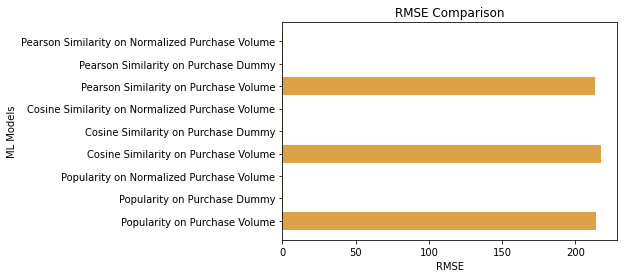

In [226]:
# Plot with no adjustment on axis scale
x = [popularity_rmse, pop_dummy_rmse, pop_norm_rmse, \
     cos_rmse, cos_dummy_rmse, cos_norm_rmse, \
     pear_rmse, pear_dummy_rmse, pear_norm_rmse]
y = ['Popularity on Purchase Volume', 'Popularity on Purchase Dummy', \
     'Popularity on Normalized Purchase Volume', 'Cosine Similarity on Purchase Volume', \
     'Cosine Similarity on Purchase Dummy', 'Cosine Similarity on Normalized Purchase Volume', \
     'Pearson Similarity on Purchase Volume', 'Pearson Similarity on Purchase Dummy', \
     'Pearson Similarity on Normalized Purchase Volume']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.title('RMSE Comparison')
plt.show()

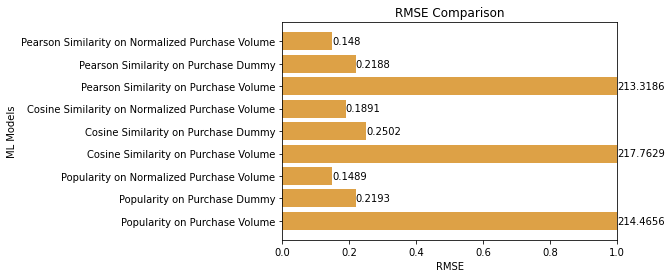

In [225]:
# Plot with adjusted on axis scale
x = [popularity_rmse, pop_dummy_rmse, pop_norm_rmse, \
     cos_rmse, cos_dummy_rmse, cos_norm_rmse, \
     pear_rmse, pear_dummy_rmse, pear_norm_rmse]
y = ['Popularity on Purchase Volume', 'Popularity on Purchase Dummy', \
     'Popularity on Normalized Purchase Volume', 'Cosine Similarity on Purchase Volume', \
     'Cosine Similarity on Purchase Dummy', 'Cosine Similarity on Normalized Purchase Volume', \
     'Pearson Similarity on Purchase Volume', 'Pearson Similarity on Purchase Dummy', \
     'Pearson Similarity on Normalized Purchase Volume']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.xlim(0, 1)
for i, v in enumerate(x):
  ax.text(min([v,1]), i, str(round(v,4)), va='center')
plt.title('RMSE Comparison')
plt.show()

**Precision-Recall**

In [165]:
# Get overall Precision-Recall values for each model
popularity_pc_sf = popularity.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pop_dummy_pc_sf = pop_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pop_norm_pc_sf = pop_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_pc_sf = cos.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_dummy_pc_sf = cos_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
cos_norm_pc_sf = cos_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_pc_sf = pear.evaluate_precision_recall(test_data, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_dummy_pc_sf = pear_dummy.evaluate_precision_recall(test_data_dummy, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']
pear_norm_pc_sf = pear_norm.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']

recommendations finished on 1000/1830 queries. users per second: 10707.1

recommendations finished on 1000/1841 queries. users per second: 2561.69

recommendations finished on 1000/1837 queries. users per second: 9577.72

recommendations finished on 1000/1830 queries. users per second: 5170.92

recommendations finished on 1000/1841 queries. users per second: 549.642

recommendations finished on 1000/1837 queries. users per second: 5076.97

recommendations finished on 1000/1830 queries. users per second: 4802.98

recommendations finished on 1000/1841 queries. users per second: 503.878

recommendations finished on 1000/1837 queries. users per second: 4657.21

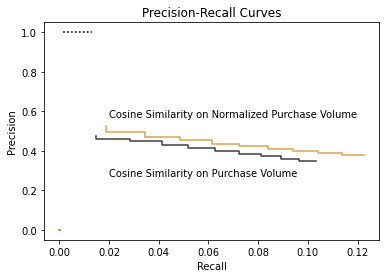

In [224]:
# Plot Precision-Recall Curve
fig, ax = plt.subplots()
ax.plot(list(popularity_pc_sf['recall']), list(popularity_pc_sf['precision']))
ax.step(list(pop_dummy_pc_sf['recall']), list(pop_dummy_pc_sf['precision']), ':k')
ax.step(list(pop_norm_pc_sf['recall']), list(pop_norm_pc_sf['precision']), ':y')
ax.step(list(cos_pc_sf['recall']), list(cos_pc_sf['precision']), color='#3A3A3A')
ax.step(list(cos_dummy_pc_sf['recall']), list(cos_dummy_pc_sf['precision']), ':m')
ax.step(list(cos_norm_pc_sf['recall']), list(cos_norm_pc_sf['precision']), color='#dda146')
ax.step(list(pear_pc_sf['recall']), list(pear_pc_sf['precision']))
ax.step(list(pear_dummy_pc_sf['recall']), list(pear_dummy_pc_sf['precision']), ':g')
ax.step(list(pear_norm_pc_sf['recall']), list(pear_norm_pc_sf['precision']))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.02, 0.57, 'Cosine Similarity on Normalized Purchase Volume')
plt.text(0.02, 0.27, 'Cosine Similarity on Purchase Volume')
plt.title('Precision-Recall Curves')
plt.show()

## Evaluation Summary

We select the ML model using **Cosine Similarity on Normalized Purchase Volume** approach as our final model for further tuning based on the following justifications:

1. Collaborative Filtering algorithms enable personalizations rather than providing the most popular items across all users (refer back to note on Baseline Summary).

2. This model has the highest precision and recall stats.

3. While the RMSE for this model is not the lowest at 0.19, we find that this is acceptable. The model with the lowest RMSE at 0.15 has significantly lower precision and recall and, and therefore is not a worthwhile trade-off. There is greater weight for a product recommender to have high precision and recall.

In [67]:
# Show the number of items observed for each user
cos_norm.get_num_items_per_user().sort('num_items', ascending = False)

CustomerID,num_items
2614,1409
4129,1309
2190,1302
2515,1208
2572,1189
2538,1176
2670,1170
4988,1145
2619,1112
2603,1098


In [68]:
# Show the number of users observed for each item
cos_norm.get_num_users_per_item().sort('num_users', ascending = False)

StockCode,num_users
11788,1295
26826,1249
38176,1234
36308,1203
11296,1193
64858,1129
10807,1123
11776,1121
64864,1115
42716,1114


In [69]:
# Get the 10 most similar items for each item in items (item-based collaborative filtering)
cos_norm.get_similar_items().print_rows(num_rows=20)

+-----------+---------+---------------------+------+
| StockCode | similar |        score        | rank |
+-----------+---------+---------------------+------+
|   37994   |  64864  |  0.5554326772689819 |  1   |
|   37994   |  43334  |  0.5504680275917053 |  2   |
|   37994   |  11774  |  0.4851314425468445 |  3   |
|   37994   |  37991  |  0.4846411347389221 |  4   |
|   37994   |  19064  | 0.46784138679504395 |  5   |
|   37994   |  11294  | 0.45855826139450073 |  6   |
|   37994   |  64858  | 0.44777601957321167 |  7   |
|   37994   |  10803  |  0.4459558129310608 |  8   |
|   37994   |  11290  |  0.4407411813735962 |  9   |
|   37994   |  43124  |  0.4368494749069214 |  10  |
|   57144   |  57157  |  0.6460562944412231 |  1   |
|   57144   |  57120  |  0.6060313582420349 |  2   |
|   57144   |  80058  |  0.6023102402687073 |  3   |
|   57144   |  57129  |  0.6008680462837219 |  4   |
|   57144   |  57125  |  0.5502657294273376 |  5   |
|   57144   |  57181  |  0.5454883575439453 | 

# **Incorporating Pre-Defined Similar Items to our Chosen Model**

Based on our evaluation, we use our chosen model to provide nearest neighbors graph using the keyword argument nearest_items.

Using the function get_similar_items, we save an SFrame with a list of items, the nearest items for each item listed and the similarity score between them.

These similarity scores are then passed as a parameter in a new model to be used for recommendations.

In [71]:
name = 'cosine' 
target = 'scaled_purchase_freq' 

nn = cos_norm.get_similar_items()
m2 = tc.item_similarity_recommender.create(train_data_norm, user_id=user_id, item_id=item_id, 
                                           target=target, similarity_type=name, 
                                           nearest_items=nn)

Preparing data set.

Data has 354720 observations with 1839 users and 3040 items.

Data prepared in: 0.615889s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.041045s

In [72]:
# Evaluate the new model
m2.evaluate(test_data_norm)

recommendations finished on 1000/1837 queries. users per second: 7161.02


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5732172019597171 |  0.021612695274958  |
|   2    |  0.5345672291780071 | 0.03840212217709201 |
|   3    |  0.5002721829069131 | 0.05289832682643321 |
|   4    | 0.46788241698421357 | 0.06428306085074464 |
|   5    |  0.4433315187806205 | 0.07507208565950228 |
|   6    | 0.42415169660678653 |  0.0854145968779308 |
|   7    | 0.40827436037016845 | 0.09523283775957157 |
|   8    |  0.3912629286880784 |  0.1037981929768877 |
|   9    | 0.37936248714691834 |  0.1129404172542877 |
|   10   |  0.3668481219379422 | 0.11999363804939901 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1912043706383709

Per User RMSE (best)
+------------+------+-------+
| CustomerID | rmse | count |
+------------+------+-------+
|    5614 

{'precision_recall_by_user': Columns:
 	CustomerID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 33066
 
 Data:
 +------------+--------+--------------------+---------------------+-------+
 | CustomerID | cutoff |     precision      |        recall       | count |
 +------------+--------+--------------------+---------------------+-------+
 |    4876    |   1    |        1.0         | 0.02564102564102564 |   39  |
 |    4876    |   2    |        1.0         | 0.05128205128205128 |   39  |
 |    4876    |   3    |        1.0         | 0.07692307692307693 |   39  |
 |    4876    |   4    |        1.0         | 0.10256410256410256 |   39  |
 |    4876    |   5    |        1.0         |  0.1282051282051282 |   39  |
 |    4876    |   6    |        1.0         | 0.15384615384615385 |   39  |
 |    4876    |   7    | 0.8571428571428571 | 0.15384615384615385 |   39  |
 |    4876    |   8    |       0.875        |  0.1794871794871795 |   39  |
 |    4876    |   9    | 0.

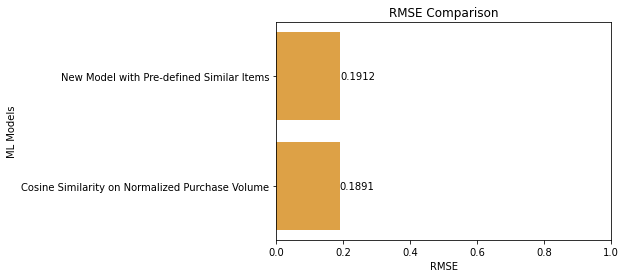

In [227]:
# Compare the 2 models (new model and chosen model) - RMSE
m2_rmse = m2.evaluate_rmse(test_data_norm, 'scaled_purchase_freq')['rmse_overall']

# Plot with adjusted on axis scale
x = [cos_norm_rmse, m2_rmse]
y = ['Cosine Similarity on Normalized Purchase Volume', \
     'New Model with Pre-defined Similar Items']

fig, ax = plt.subplots()
plt.barh(y, x, color='#dda146')
plt.ylabel('ML Models')
plt.xlabel('RMSE')
plt.xlim(0, 1)
for i, v in enumerate(x):
  ax.text(min([v,1]), i, str(round(v,4)), va='center')
plt.title('RMSE Comparison')
plt.show()

recommendations finished on 1000/1837 queries. users per second: 8561.42

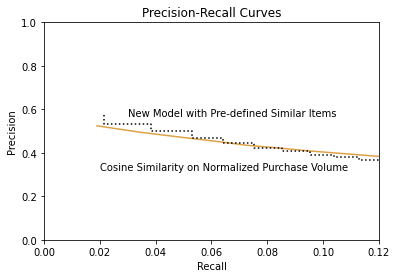

In [235]:
# Compare the 2 models (new model and chosen model) - Precision-Recall
m2_pc_sf = m2.evaluate_precision_recall(test_data_norm, cutoffs=[1,2,3,4,5,6,7,8,9,10])['precision_recall_overall']

fig, ax = plt.subplots()
ax.plot(list(cos_norm_pc_sf['recall']), list(cos_norm_pc_sf['precision']), color='#dda146')
ax.step(list(m2_pc_sf['recall']), list(m2_pc_sf['precision']), ':k')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.03, 0.57, 'New Model with Pre-defined Similar Items')
plt.text(0.02, 0.32, 'Cosine Similarity on Normalized Purchase Volume')
plt.title('Precision-Recall Curves')
plt.xlim(0,0.12)
plt.ylim(0,1)
plt.show()

**Evaluation Summary**

We have decided to select the new model as the final model for our product recommender for the following reasons:
Given that the model accuracy is comparable

1.   Marginally higher Precision-Recall 
2.   Model accuracy is comparable 



In [73]:
# Input: Customer ID
m2.recommend().print_rows(num_rows=20)

recommendations finished on 1000/1839 queries. users per second: 16940.8

+------------+-----------+-----------------------+------+
| CustomerID | StockCode |         score         | rank |
+------------+-----------+-----------------------+------+
|    4876    |   11774   |  0.016915631758702265 |  1   |
|    4876    |   48099   |  0.010211764992057504 |  2   |
|    4876    |   10804   |  0.009418653977381718 |  3   |
|    4876    |   88290   |  0.007298006639852152 |  4   |
|    4876    |   38006   |  0.006582276000605001 |  5   |
|    4876    |   64858   |  0.005253892827343631 |  6   |
|    4876    |   64711   |   0.0050791660686592  |  7   |
|    4876    |   87403   |  0.004081902178851041 |  8   |
|    4876    |   86670   |  0.003994000809533256 |  9   |
|    4876    |   38176   |  0.003914609357908175 |  10  |
|    2551    |   38176   |  0.008940411597183071 |  1   |
|    2551    |   86670   | 0.0044101623120586485 |  2   |
|    2551    |   58838   |  0.004076595056507596 |  3   |
|    2551    |   29119   | 0.0023088895578154993 |  4   |
|    2551    |

In [74]:
# Input: StockCode
m2.recommend_from_interactions(test_items, k=10)

StockCode,score,rank
18348,0.44924354553222656,1
944650,0.4460524022579193,2
28868,0.4456981122493744,3
962094,0.4453620910644531,4
989289,0.4448971450328827,5
987514,0.4443680942058563,6
930746,0.443901002407074,7
936600,0.4405471086502075,8
989287,0.44017428159713745,9
908806,0.436821848154068,10


# **Final Output**

**Collaborative Filtering**

In [75]:
# Rerun the model using the whole dataset, as we came to a final model using train data and evaluated with test set
final_model = tc.item_similarity_recommender.create(tc.SFrame(norm_data), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq', 
                                            similarity_type='cosine',
                                            nearest_items=nn)
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 443400 observations with 1840 users and 3044 items.

Data prepared in: 0.686531s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.045813s

recommendations finished on 1000/446139 queries. users per second: 9958.27

recommendations finished on 2000/446139 queries. users per second: 9447.24

recommendations finished on 3000/446139 queries. users per second: 9303.13

recommendations finished on 4000/446139 queries. users per second: 9108.98

recommendations finished on 5000/446139 queries. users per second: 8899.12

recommendations finished on 6000/446139 queries. users per second: 8826.53

recommendations finished on 7000/446139 queries. users per second: 8861.47

recommendations finished on 8000/446139 queries. users per second: 8851.29

recommendations finished on 9000/446139 queries. users per second: 8817.02

recommendations finished on 10000/446139 queries. users per second: 8837.53

recommendations finished on 11000/446139 queries. users per second: 8759.05

recommendations finished on 12000/446139 queries. users per second: 8692.54

recommendations finished on 13000/446139 queries. users per second: 8744.62

recommendations finished on 14000/446139 queries. users per second: 8729.4

recommendations finished on 15000/446139 queries. users per second: 8626.1

recommendations finished on 16000/446139 queries. users per second: 8487.26

recommendations finished on 17000/446139 queries. users per second: 8471.96

recommendations finished on 18000/446139 queries. users per second: 8515.82

recommendations finished on 19000/446139 queries. users per second: 8528.15

recommendations finished on 20000/446139 queries. users per second: 8592.81

recommendations finished on 21000/446139 queries. users per second: 8610.65

recommendations finished on 22000/446139 queries. users per second: 8595.97

recommendations finished on 23000/446139 queries. users per second: 8573.53

recommendations finished on 24000/446139 queries. users per second: 8582.19

recommendations finished on 25000/446139 queries. users per second: 8579.62

recommendations finished on 26000/446139 queries. users per second: 8552.31

recommendations finished on 27000/446139 queries. users per second: 8548.92

recommendations finished on 28000/446139 queries. users per second: 8561.68

recommendations finished on 29000/446139 queries. users per second: 8607.48

recommendations finished on 30000/446139 queries. users per second: 8641.62

recommendations finished on 31000/446139 queries. users per second: 8677.24

recommendations finished on 32000/446139 queries. users per second: 8712.12

recommendations finished on 33000/446139 queries. users per second: 8754.46

recommendations finished on 34000/446139 queries. users per second: 8770.33

recommendations finished on 35000/446139 queries. users per second: 8780.21

recommendations finished on 36000/446139 queries. users per second: 8781.56

recommendations finished on 37000/446139 queries. users per second: 8815.51

recommendations finished on 38000/446139 queries. users per second: 8831.37

recommendations finished on 39000/446139 queries. users per second: 8863.27

recommendations finished on 40000/446139 queries. users per second: 8881.34

recommendations finished on 41000/446139 queries. users per second: 8896.82

recommendations finished on 42000/446139 queries. users per second: 8931.9

recommendations finished on 43000/446139 queries. users per second: 8923.79

recommendations finished on 44000/446139 queries. users per second: 8955.26

recommendations finished on 45000/446139 queries. users per second: 8972.15

recommendations finished on 46000/446139 queries. users per second: 8981.5

recommendations finished on 47000/446139 queries. users per second: 8981.47

recommendations finished on 48000/446139 queries. users per second: 9004.46

recommendations finished on 49000/446139 queries. users per second: 9009.3

recommendations finished on 50000/446139 queries. users per second: 9030.18

recommendations finished on 51000/446139 queries. users per second: 9020.58

recommendations finished on 52000/446139 queries. users per second: 9024.49

recommendations finished on 53000/446139 queries. users per second: 8995.14

recommendations finished on 54000/446139 queries. users per second: 8954.62

recommendations finished on 55000/446139 queries. users per second: 8941.31

recommendations finished on 56000/446139 queries. users per second: 8943.81

recommendations finished on 57000/446139 queries. users per second: 8934.17

recommendations finished on 58000/446139 queries. users per second: 8928.59

recommendations finished on 59000/446139 queries. users per second: 8899.27

recommendations finished on 60000/446139 queries. users per second: 8859.85

recommendations finished on 61000/446139 queries. users per second: 8810.04

recommendations finished on 62000/446139 queries. users per second: 8757.21

recommendations finished on 63000/446139 queries. users per second: 8709.33

recommendations finished on 64000/446139 queries. users per second: 8668.32

recommendations finished on 65000/446139 queries. users per second: 8624.1

recommendations finished on 66000/446139 queries. users per second: 8586.56

recommendations finished on 67000/446139 queries. users per second: 8549.81

recommendations finished on 68000/446139 queries. users per second: 8519.43

recommendations finished on 69000/446139 queries. users per second: 8477.01

recommendations finished on 70000/446139 queries. users per second: 8456.13

recommendations finished on 71000/446139 queries. users per second: 8429.17

recommendations finished on 72000/446139 queries. users per second: 8403.9

recommendations finished on 73000/446139 queries. users per second: 8383.3

recommendations finished on 74000/446139 queries. users per second: 8361.02

recommendations finished on 75000/446139 queries. users per second: 8332.24

recommendations finished on 76000/446139 queries. users per second: 8302.22

recommendations finished on 77000/446139 queries. users per second: 8283.31

recommendations finished on 78000/446139 queries. users per second: 8256.9

recommendations finished on 79000/446139 queries. users per second: 8233.49

recommendations finished on 80000/446139 queries. users per second: 8213.4

recommendations finished on 81000/446139 queries. users per second: 8197.6

recommendations finished on 82000/446139 queries. users per second: 8174.19

recommendations finished on 83000/446139 queries. users per second: 8138.8

recommendations finished on 84000/446139 queries. users per second: 8125.37

recommendations finished on 85000/446139 queries. users per second: 8101.06

recommendations finished on 86000/446139 queries. users per second: 8082.08

recommendations finished on 87000/446139 queries. users per second: 8058.18

recommendations finished on 88000/446139 queries. users per second: 8038.11

recommendations finished on 89000/446139 queries. users per second: 8022.13

recommendations finished on 90000/446139 queries. users per second: 8000.39

recommendations finished on 91000/446139 queries. users per second: 7981.19

recommendations finished on 92000/446139 queries. users per second: 7963.84

recommendations finished on 93000/446139 queries. users per second: 7956.36

recommendations finished on 94000/446139 queries. users per second: 7940.32

recommendations finished on 95000/446139 queries. users per second: 7930.38

recommendations finished on 96000/446139 queries. users per second: 7921.3

recommendations finished on 97000/446139 queries. users per second: 7902.9

recommendations finished on 98000/446139 queries. users per second: 7885.73

recommendations finished on 99000/446139 queries. users per second: 7877.3

recommendations finished on 100000/446139 queries. users per second: 7867.91

recommendations finished on 101000/446139 queries. users per second: 7851.85

recommendations finished on 102000/446139 queries. users per second: 7846.39

recommendations finished on 103000/446139 queries. users per second: 7835.13

recommendations finished on 104000/446139 queries. users per second: 7818.33

recommendations finished on 105000/446139 queries. users per second: 7804.93

recommendations finished on 106000/446139 queries. users per second: 7798.37

recommendations finished on 107000/446139 queries. users per second: 7779

recommendations finished on 108000/446139 queries. users per second: 7771.67

recommendations finished on 109000/446139 queries. users per second: 7771.17

recommendations finished on 110000/446139 queries. users per second: 7764.89

recommendations finished on 111000/446139 queries. users per second: 7754.22

recommendations finished on 112000/446139 queries. users per second: 7749.27

recommendations finished on 113000/446139 queries. users per second: 7741.52

recommendations finished on 114000/446139 queries. users per second: 7735.19

recommendations finished on 115000/446139 queries. users per second: 7729.02

recommendations finished on 116000/446139 queries. users per second: 7722.17

recommendations finished on 117000/446139 queries. users per second: 7711.07

recommendations finished on 118000/446139 queries. users per second: 7694.76

recommendations finished on 119000/446139 queries. users per second: 7684.35

recommendations finished on 120000/446139 queries. users per second: 7680.68

recommendations finished on 121000/446139 queries. users per second: 7672.24

recommendations finished on 122000/446139 queries. users per second: 7669.81

recommendations finished on 123000/446139 queries. users per second: 7670.27

recommendations finished on 124000/446139 queries. users per second: 7676.69

recommendations finished on 125000/446139 queries. users per second: 7672.97

recommendations finished on 126000/446139 queries. users per second: 7681.69

recommendations finished on 127000/446139 queries. users per second: 7685.86

recommendations finished on 128000/446139 queries. users per second: 7692.26

recommendations finished on 129000/446139 queries. users per second: 7697.3

recommendations finished on 130000/446139 queries. users per second: 7701.18

recommendations finished on 131000/446139 queries. users per second: 7702.43

recommendations finished on 132000/446139 queries. users per second: 7710.25

recommendations finished on 133000/446139 queries. users per second: 7705.03

recommendations finished on 134000/446139 queries. users per second: 7706.28

recommendations finished on 135000/446139 queries. users per second: 7708.2

recommendations finished on 136000/446139 queries. users per second: 7710.24

recommendations finished on 137000/446139 queries. users per second: 7713.5

recommendations finished on 138000/446139 queries. users per second: 7719.79

recommendations finished on 139000/446139 queries. users per second: 7726.16

recommendations finished on 140000/446139 queries. users per second: 7736.71

recommendations finished on 141000/446139 queries. users per second: 7743.84

recommendations finished on 142000/446139 queries. users per second: 7751.16

recommendations finished on 143000/446139 queries. users per second: 7761.06

recommendations finished on 144000/446139 queries. users per second: 7772.86

recommendations finished on 145000/446139 queries. users per second: 7763.06

recommendations finished on 146000/446139 queries. users per second: 7770.57

recommendations finished on 147000/446139 queries. users per second: 7782.05

recommendations finished on 148000/446139 queries. users per second: 7783.76

recommendations finished on 149000/446139 queries. users per second: 7775.57

recommendations finished on 150000/446139 queries. users per second: 7776.14

recommendations finished on 151000/446139 queries. users per second: 7774.52

recommendations finished on 152000/446139 queries. users per second: 7771.15

recommendations finished on 153000/446139 queries. users per second: 7764.21

recommendations finished on 154000/446139 queries. users per second: 7764.64

recommendations finished on 155000/446139 queries. users per second: 7758.62

recommendations finished on 156000/446139 queries. users per second: 7763.07

recommendations finished on 157000/446139 queries. users per second: 7772.43

recommendations finished on 158000/446139 queries. users per second: 7782.04

recommendations finished on 159000/446139 queries. users per second: 7778.58

recommendations finished on 160000/446139 queries. users per second: 7783.66

recommendations finished on 161000/446139 queries. users per second: 7774.04

recommendations finished on 162000/446139 queries. users per second: 7775.58

recommendations finished on 163000/446139 queries. users per second: 7779.14

recommendations finished on 164000/446139 queries. users per second: 7778.08

recommendations finished on 165000/446139 queries. users per second: 7770.76

recommendations finished on 166000/446139 queries. users per second: 7756.19

recommendations finished on 167000/446139 queries. users per second: 7751

recommendations finished on 168000/446139 queries. users per second: 7746.89

recommendations finished on 169000/446139 queries. users per second: 7741.04

recommendations finished on 170000/446139 queries. users per second: 7734.56

recommendations finished on 171000/446139 queries. users per second: 7731.11

recommendations finished on 172000/446139 queries. users per second: 7730.06

recommendations finished on 173000/446139 queries. users per second: 7728.6

recommendations finished on 174000/446139 queries. users per second: 7731.68

recommendations finished on 175000/446139 queries. users per second: 7735.43

recommendations finished on 176000/446139 queries. users per second: 7736.35

recommendations finished on 177000/446139 queries. users per second: 7738.47

recommendations finished on 178000/446139 queries. users per second: 7740.21

recommendations finished on 179000/446139 queries. users per second: 7740.44

recommendations finished on 180000/446139 queries. users per second: 7737.44

recommendations finished on 181000/446139 queries. users per second: 7729.36

recommendations finished on 182000/446139 queries. users per second: 7722.47

recommendations finished on 183000/446139 queries. users per second: 7720.88

recommendations finished on 184000/446139 queries. users per second: 7717.13

recommendations finished on 185000/446139 queries. users per second: 7712.62

recommendations finished on 186000/446139 queries. users per second: 7705.24

recommendations finished on 187000/446139 queries. users per second: 7697.64

recommendations finished on 188000/446139 queries. users per second: 7688.9

recommendations finished on 189000/446139 queries. users per second: 7688.93

recommendations finished on 190000/446139 queries. users per second: 7691.94

recommendations finished on 191000/446139 queries. users per second: 7692.96

recommendations finished on 192000/446139 queries. users per second: 7696.26

recommendations finished on 193000/446139 queries. users per second: 7700.8

recommendations finished on 194000/446139 queries. users per second: 7703.25

recommendations finished on 195000/446139 queries. users per second: 7704.57

recommendations finished on 196000/446139 queries. users per second: 7701.82

recommendations finished on 197000/446139 queries. users per second: 7702.48

recommendations finished on 198000/446139 queries. users per second: 7702.03

recommendations finished on 199000/446139 queries. users per second: 7702.4

recommendations finished on 200000/446139 queries. users per second: 7703.09

recommendations finished on 201000/446139 queries. users per second: 7703.92

recommendations finished on 202000/446139 queries. users per second: 7704.8

recommendations finished on 203000/446139 queries. users per second: 7705.14

recommendations finished on 204000/446139 queries. users per second: 7699.78

recommendations finished on 205000/446139 queries. users per second: 7696.69

recommendations finished on 206000/446139 queries. users per second: 7695.38

recommendations finished on 207000/446139 queries. users per second: 7697.39

recommendations finished on 208000/446139 queries. users per second: 7700.63

recommendations finished on 209000/446139 queries. users per second: 7704.34

recommendations finished on 210000/446139 queries. users per second: 7709.11

recommendations finished on 211000/446139 queries. users per second: 7710.21

recommendations finished on 212000/446139 queries. users per second: 7707.08

recommendations finished on 213000/446139 queries. users per second: 7705.33

recommendations finished on 214000/446139 queries. users per second: 7703.46

recommendations finished on 215000/446139 queries. users per second: 7701.34

recommendations finished on 216000/446139 queries. users per second: 7700.83

recommendations finished on 217000/446139 queries. users per second: 7696.33

recommendations finished on 218000/446139 queries. users per second: 7701.78

recommendations finished on 219000/446139 queries. users per second: 7707.21

recommendations finished on 220000/446139 queries. users per second: 7711.21

recommendations finished on 221000/446139 queries. users per second: 7715.79

recommendations finished on 222000/446139 queries. users per second: 7719.98

recommendations finished on 223000/446139 queries. users per second: 7720.85

recommendations finished on 224000/446139 queries. users per second: 7721.84

recommendations finished on 225000/446139 queries. users per second: 7721.35

recommendations finished on 226000/446139 queries. users per second: 7722.71

recommendations finished on 227000/446139 queries. users per second: 7724.55

recommendations finished on 228000/446139 queries. users per second: 7720.93

recommendations finished on 229000/446139 queries. users per second: 7716.27

recommendations finished on 230000/446139 queries. users per second: 7715.85

recommendations finished on 231000/446139 queries. users per second: 7719.95

recommendations finished on 232000/446139 queries. users per second: 7722.03

recommendations finished on 233000/446139 queries. users per second: 7725.22

recommendations finished on 234000/446139 queries. users per second: 7728.38

recommendations finished on 235000/446139 queries. users per second: 7731.29

recommendations finished on 236000/446139 queries. users per second: 7731.62

recommendations finished on 237000/446139 queries. users per second: 7729.61

recommendations finished on 238000/446139 queries. users per second: 7732.85

recommendations finished on 239000/446139 queries. users per second: 7734.31

recommendations finished on 240000/446139 queries. users per second: 7738.51

recommendations finished on 241000/446139 queries. users per second: 7740.58

recommendations finished on 242000/446139 queries. users per second: 7738.14

recommendations finished on 243000/446139 queries. users per second: 7736.33

recommendations finished on 244000/446139 queries. users per second: 7736.34

recommendations finished on 245000/446139 queries. users per second: 7734.93

recommendations finished on 246000/446139 queries. users per second: 7731.89

recommendations finished on 247000/446139 queries. users per second: 7731.07

recommendations finished on 248000/446139 queries. users per second: 7728.73

recommendations finished on 249000/446139 queries. users per second: 7723.92

recommendations finished on 250000/446139 queries. users per second: 7718.58

recommendations finished on 251000/446139 queries. users per second: 7714.42

recommendations finished on 252000/446139 queries. users per second: 7709.63

recommendations finished on 253000/446139 queries. users per second: 7704.98

recommendations finished on 254000/446139 queries. users per second: 7701.31

recommendations finished on 255000/446139 queries. users per second: 7697.13

recommendations finished on 256000/446139 queries. users per second: 7695.5

recommendations finished on 257000/446139 queries. users per second: 7691.7

recommendations finished on 258000/446139 queries. users per second: 7689.83

recommendations finished on 259000/446139 queries. users per second: 7690.4

recommendations finished on 260000/446139 queries. users per second: 7691.26

recommendations finished on 261000/446139 queries. users per second: 7689.74

recommendations finished on 262000/446139 queries. users per second: 7687.39

recommendations finished on 263000/446139 queries. users per second: 7685.8

recommendations finished on 264000/446139 queries. users per second: 7685.9

recommendations finished on 265000/446139 queries. users per second: 7687.74

recommendations finished on 266000/446139 queries. users per second: 7687.98

recommendations finished on 267000/446139 queries. users per second: 7687.43

recommendations finished on 268000/446139 queries. users per second: 7690.8

recommendations finished on 269000/446139 queries. users per second: 7696.14

recommendations finished on 270000/446139 queries. users per second: 7699.79

recommendations finished on 271000/446139 queries. users per second: 7701.52

recommendations finished on 272000/446139 queries. users per second: 7704.3

recommendations finished on 273000/446139 queries. users per second: 7707.42

recommendations finished on 274000/446139 queries. users per second: 7708.94

recommendations finished on 275000/446139 queries. users per second: 7708.7

recommendations finished on 276000/446139 queries. users per second: 7713.78

recommendations finished on 277000/446139 queries. users per second: 7712.62

recommendations finished on 278000/446139 queries. users per second: 7716.37

recommendations finished on 279000/446139 queries. users per second: 7717.83

recommendations finished on 280000/446139 queries. users per second: 7720.95

recommendations finished on 281000/446139 queries. users per second: 7718.81

recommendations finished on 282000/446139 queries. users per second: 7718.62

recommendations finished on 283000/446139 queries. users per second: 7713.53

recommendations finished on 284000/446139 queries. users per second: 7713.99

recommendations finished on 285000/446139 queries. users per second: 7715.49

recommendations finished on 286000/446139 queries. users per second: 7716.27

recommendations finished on 287000/446139 queries. users per second: 7713.74

recommendations finished on 288000/446139 queries. users per second: 7714.02

recommendations finished on 289000/446139 queries. users per second: 7713.13

recommendations finished on 290000/446139 queries. users per second: 7712.61

recommendations finished on 291000/446139 queries. users per second: 7710.61

recommendations finished on 292000/446139 queries. users per second: 7708.12

recommendations finished on 293000/446139 queries. users per second: 7706.58

recommendations finished on 294000/446139 queries. users per second: 7706

recommendations finished on 295000/446139 queries. users per second: 7703.3

recommendations finished on 296000/446139 queries. users per second: 7698.73

recommendations finished on 297000/446139 queries. users per second: 7695

recommendations finished on 298000/446139 queries. users per second: 7688.65

recommendations finished on 299000/446139 queries. users per second: 7685.71

recommendations finished on 300000/446139 queries. users per second: 7682.86

recommendations finished on 301000/446139 queries. users per second: 7679.48

recommendations finished on 302000/446139 queries. users per second: 7675.83

recommendations finished on 303000/446139 queries. users per second: 7673.12

recommendations finished on 304000/446139 queries. users per second: 7670.45

recommendations finished on 305000/446139 queries. users per second: 7665.13

recommendations finished on 306000/446139 queries. users per second: 7659.48

recommendations finished on 307000/446139 queries. users per second: 7657.72

recommendations finished on 308000/446139 queries. users per second: 7651.29

recommendations finished on 309000/446139 queries. users per second: 7648.86

recommendations finished on 310000/446139 queries. users per second: 7648.49

recommendations finished on 311000/446139 queries. users per second: 7646.45

recommendations finished on 312000/446139 queries. users per second: 7643

recommendations finished on 313000/446139 queries. users per second: 7640.32

recommendations finished on 314000/446139 queries. users per second: 7638.24

recommendations finished on 315000/446139 queries. users per second: 7633.54

recommendations finished on 316000/446139 queries. users per second: 7630.8

recommendations finished on 317000/446139 queries. users per second: 7628.79

recommendations finished on 318000/446139 queries. users per second: 7624.97

recommendations finished on 319000/446139 queries. users per second: 7621.92

recommendations finished on 320000/446139 queries. users per second: 7620.31

recommendations finished on 321000/446139 queries. users per second: 7617.82

recommendations finished on 322000/446139 queries. users per second: 7613.53

recommendations finished on 323000/446139 queries. users per second: 7609.55

recommendations finished on 324000/446139 queries. users per second: 7605.49

recommendations finished on 325000/446139 queries. users per second: 7603.02

recommendations finished on 326000/446139 queries. users per second: 7600.88

recommendations finished on 327000/446139 queries. users per second: 7599.11

recommendations finished on 328000/446139 queries. users per second: 7596.36

recommendations finished on 329000/446139 queries. users per second: 7596.69

recommendations finished on 330000/446139 queries. users per second: 7594.39

recommendations finished on 331000/446139 queries. users per second: 7595.56

recommendations finished on 332000/446139 queries. users per second: 7598.86

recommendations finished on 333000/446139 queries. users per second: 7603.42

recommendations finished on 334000/446139 queries. users per second: 7607.49

recommendations finished on 335000/446139 queries. users per second: 7611.07

recommendations finished on 336000/446139 queries. users per second: 7614.39

recommendations finished on 337000/446139 queries. users per second: 7619.05

recommendations finished on 338000/446139 queries. users per second: 7620.35

recommendations finished on 339000/446139 queries. users per second: 7622.39

recommendations finished on 340000/446139 queries. users per second: 7625.76

recommendations finished on 341000/446139 queries. users per second: 7629.76

recommendations finished on 342000/446139 queries. users per second: 7632.57

recommendations finished on 343000/446139 queries. users per second: 7634.48

recommendations finished on 344000/446139 queries. users per second: 7639.31

recommendations finished on 345000/446139 queries. users per second: 7643.25

recommendations finished on 346000/446139 queries. users per second: 7647.45

recommendations finished on 347000/446139 queries. users per second: 7650.51

recommendations finished on 348000/446139 queries. users per second: 7655.01

recommendations finished on 349000/446139 queries. users per second: 7657.25

recommendations finished on 350000/446139 queries. users per second: 7656.63

recommendations finished on 351000/446139 queries. users per second: 7658.86

recommendations finished on 352000/446139 queries. users per second: 7661.64

recommendations finished on 353000/446139 queries. users per second: 7661.34

recommendations finished on 354000/446139 queries. users per second: 7663.34

recommendations finished on 355000/446139 queries. users per second: 7668.28

recommendations finished on 356000/446139 queries. users per second: 7673.96

recommendations finished on 357000/446139 queries. users per second: 7678.81

recommendations finished on 358000/446139 queries. users per second: 7684.46

recommendations finished on 359000/446139 queries. users per second: 7689.12

recommendations finished on 360000/446139 queries. users per second: 7689.13

recommendations finished on 361000/446139 queries. users per second: 7689.41

recommendations finished on 362000/446139 queries. users per second: 7691.77

recommendations finished on 363000/446139 queries. users per second: 7694.07

recommendations finished on 364000/446139 queries. users per second: 7695.9

recommendations finished on 365000/446139 queries. users per second: 7696.1

recommendations finished on 366000/446139 queries. users per second: 7694.61

recommendations finished on 367000/446139 queries. users per second: 7691.65

recommendations finished on 368000/446139 queries. users per second: 7689.35

recommendations finished on 369000/446139 queries. users per second: 7686.04

recommendations finished on 370000/446139 queries. users per second: 7683.07

recommendations finished on 371000/446139 queries. users per second: 7679.62

recommendations finished on 372000/446139 queries. users per second: 7675.81

recommendations finished on 373000/446139 queries. users per second: 7671.66

recommendations finished on 374000/446139 queries. users per second: 7668.36

recommendations finished on 375000/446139 queries. users per second: 7664.51

recommendations finished on 376000/446139 queries. users per second: 7662.85

recommendations finished on 377000/446139 queries. users per second: 7660.97

recommendations finished on 378000/446139 queries. users per second: 7657.44

recommendations finished on 379000/446139 queries. users per second: 7654.86

recommendations finished on 380000/446139 queries. users per second: 7652.41

recommendations finished on 381000/446139 queries. users per second: 7649.24

recommendations finished on 382000/446139 queries. users per second: 7644.89

recommendations finished on 383000/446139 queries. users per second: 7642.31

recommendations finished on 384000/446139 queries. users per second: 7643.8

recommendations finished on 385000/446139 queries. users per second: 7642.96

recommendations finished on 386000/446139 queries. users per second: 7639.36

recommendations finished on 387000/446139 queries. users per second: 7637.26

recommendations finished on 388000/446139 queries. users per second: 7634.92

recommendations finished on 389000/446139 queries. users per second: 7632.05

recommendations finished on 390000/446139 queries. users per second: 7630.21

recommendations finished on 391000/446139 queries. users per second: 7631.38

recommendations finished on 392000/446139 queries. users per second: 7633.43

recommendations finished on 393000/446139 queries. users per second: 7635.13

recommendations finished on 394000/446139 queries. users per second: 7636.17

recommendations finished on 395000/446139 queries. users per second: 7635.15

recommendations finished on 396000/446139 queries. users per second: 7633.84

recommendations finished on 397000/446139 queries. users per second: 7631.63

recommendations finished on 398000/446139 queries. users per second: 7630.27

recommendations finished on 399000/446139 queries. users per second: 7629.41

recommendations finished on 400000/446139 queries. users per second: 7629.12

recommendations finished on 401000/446139 queries. users per second: 7627.31

recommendations finished on 402000/446139 queries. users per second: 7624.54

recommendations finished on 403000/446139 queries. users per second: 7623.23

recommendations finished on 404000/446139 queries. users per second: 7620.41

recommendations finished on 405000/446139 queries. users per second: 7620.29

recommendations finished on 406000/446139 queries. users per second: 7620.72

recommendations finished on 407000/446139 queries. users per second: 7620.11

recommendations finished on 408000/446139 queries. users per second: 7619.71

recommendations finished on 409000/446139 queries. users per second: 7618.76

recommendations finished on 410000/446139 queries. users per second: 7619.48

recommendations finished on 411000/446139 queries. users per second: 7616.45

recommendations finished on 412000/446139 queries. users per second: 7610.9

recommendations finished on 413000/446139 queries. users per second: 7606.53

recommendations finished on 414000/446139 queries. users per second: 7602.01

recommendations finished on 415000/446139 queries. users per second: 7595.94

recommendations finished on 416000/446139 queries. users per second: 7591.62

recommendations finished on 417000/446139 queries. users per second: 7585.84

recommendations finished on 418000/446139 queries. users per second: 7574.6

recommendations finished on 419000/446139 queries. users per second: 7567.26

recommendations finished on 420000/446139 queries. users per second: 7560.17

recommendations finished on 421000/446139 queries. users per second: 7554.16

recommendations finished on 422000/446139 queries. users per second: 7545.96

recommendations finished on 423000/446139 queries. users per second: 7544.8

recommendations finished on 424000/446139 queries. users per second: 7541.89

recommendations finished on 425000/446139 queries. users per second: 7541.96

recommendations finished on 426000/446139 queries. users per second: 7541.69

recommendations finished on 427000/446139 queries. users per second: 7541.73

recommendations finished on 428000/446139 queries. users per second: 7541.55

recommendations finished on 429000/446139 queries. users per second: 7542.44

recommendations finished on 430000/446139 queries. users per second: 7540.34

recommendations finished on 431000/446139 queries. users per second: 7538.67

recommendations finished on 432000/446139 queries. users per second: 7535.89

recommendations finished on 433000/446139 queries. users per second: 7533.15

recommendations finished on 434000/446139 queries. users per second: 7531.07

recommendations finished on 435000/446139 queries. users per second: 7528.42

recommendations finished on 436000/446139 queries. users per second: 7519.32

recommendations finished on 437000/446139 queries. users per second: 7509.34

recommendations finished on 438000/446139 queries. users per second: 7500.74

recommendations finished on 439000/446139 queries. users per second: 7496.12

recommendations finished on 440000/446139 queries. users per second: 7492.27

recommendations finished on 441000/446139 queries. users per second: 7488.14

recommendations finished on 442000/446139 queries. users per second: 7491.49

recommendations finished on 443000/446139 queries. users per second: 7494.7

recommendations finished on 444000/446139 queries. users per second: 7497.16

recommendations finished on 445000/446139 queries. users per second: 7492.55

recommendations finished on 446000/446139 queries. users per second: 7495.89

+------------+-----------+----------------------+------+
| CustomerID | StockCode |        score         | rank |
+------------+-----------+----------------------+------+
|    3814    |   10628   | 0.05548687430395596  |  1   |
|    3814    |   17958   | 0.05441101737644361  |  2   |
|    3814    |   21236   | 0.03878499113995096  |  3   |
|    3814    |   43316   | 0.03529813237812208  |  4   |
|    3814    |    4716   | 0.03221182892287987  |  5   |
|    3814    |   28279   | 0.027287662893101788 |  6   |
|    3814    |   26828   | 0.027282248372616974 |  7   |
|    3814    |   40329   | 0.026519557704096256 |  8   |
|    3814    |   21598   | 0.021965812081876007 |  9   |
|    3814    |   32238   | 0.01893269065497578  |  10  |
+------------+-----------+----------------------+------+
[4461390 rows x 4 columns]



In [76]:
# Save final model for collaborative filtering
final_model.save("gdrive/My Drive/drinkupiowa-C")

**Popularity**

In [246]:
popularity.recommend().print_rows(num_rows=30)

+------------+-----------+-------------------+------+
| CustomerID | StockCode |       score       | rank |
+------------+-----------+-------------------+------+
|    2367    |   936600  |      60716.25     |  1   |
|    2367    |   962094  |      21420.0      |  2   |
|    2367    |   936859  | 9458.166666666666 |  3   |
|    2367    |   908806  |       8127.0      |  4   |
|    2367    |   989291  |       7056.0      |  5   |
|    2367    |   989289  |       7056.0      |  6   |
|    2367    |   944650  |       5208.0      |  7   |
|    2367    |   930746  |       4368.0      |  8   |
|    2367    |   987514  |       3780.0      |  9   |
|    2367    |   989292  |       3696.0      |  10  |
+------------+-----------+-------------------+------+
[10 rows x 4 columns]



In [242]:
# Save popularity model to recommend "Best Selling Items"
popularity.save("gdrive/My Drive/drinkupiowa-C-popular")